In [ ]:
!nvidia-smi

Sat Aug 22 10:33:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install youtokentome
!pip install pyonmttok
!pip install unidecode

     |████████████████████████████████| 1.7MB 6.9MB/s 
     |████████████████████████████████| 2.2MB 7.3MB/s 
     |████████████████████████████████| 245kB 7.4MB/s 


In [ ]:
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-10.1'

In [ ]:
!echo $CUDA_HOME

/usr/local/cuda-10.1


In [ ]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir ./
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd ..

Cloning into 'apex'...
remote: Enumerating objects: 7431, done.
remote: Total 7431 (delta 0), reused 0 (delta 0), pack-reused 7431
Receiving objects: 100% (7431/7431), 13.90 MiB | 3.44 MiB/s, done.
Resolving deltas: 100% (5024/5024), done.
/content/apex
Created temporary directory: /tmp/pip-ephem-wheel-cache-yuj4o78i
Created temporary directory: /tmp/pip-req-tracker-ncwg_q_x
Created requirements tracker '/tmp/pip-req-tracker-ncwg_q_x'
Created temporary directory: /tmp/pip-install-cjfupvcy
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-gsy2a5pg
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-ncwg_q_x'
    Running setup.py (path:/tmp/pip-req-build-gsy2a5pg/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.6.0+cu101


    running egg_info
    creating /tmp/pip-req-build-gsy2a5pg/pip-egg-info/apex.egg-info
    writing /tmp/pip-req-build-gsy2a5pg/pip-egg-info/apex

In [ ]:
import copy
import math
import random
import re
import time

from apex import amp
import nltk
import numpy as np
import youtokentome as yttm
import pyonmttok
import torch
import torch.nn as nn
import torch.nn.functional as F
import unidecode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
pad = 0
sos = 2
eos = 3

#zenbat_handitu_helb = 6
#zenbat_handitu_jat = 4

max_seq_len = 120
vocab_size = 20000
d_model = 512    # Hitza adierazteko bektoreen luzera
N = 6            # Geruza kopurua
heads = 8        # Attention-head kopurua

batch_size = 90#128
batch_size_val = 50
epochs = 40
zenbatero_idatzi = 100
#dev_kop = 1000
#zenbatero_balidatu = 1000
#zenbatero_gorde = 10000

fp16 = True

In [ ]:
bpe_hirurak = yttm.BPE(model='HACOSDatuak/bpe_hirurak.model')
#bpe_hirurak = yttm.BPE(model='EhuHac/bpe_hirurak2.model')

# Transformer-a

In [ ]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        # Orain dagoen moduan, max_seq_len aldagai globalak definituta egon
        # behar du
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe.unsqueeze_(0) # Lista -> [Lista]. in-place egiteak ezer aldatzen du?
        # batch_size dimentsioa gehitzeko
        # Zergatik tentsoreekin bai eta zenbakiekin (d_model) ez?
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # Hasierako embedding-ak pisu handiagoa izateko, suposatzen da:
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        # Bi adibideetan hemen Variable torch.tensor-en ordez:
        # x = x + torch.tensor(self.pe[:,:seq_len], requires_grad=False).cuda()
        #print("Size x: " + str(x.size()))
        #print("Size pe: " + str(self.pe.size()))
        x = x + self.pe[:,:seq_len] # <- Hau bakarrik eginda zer aldatzen da?
        # Bai beste adibidean eta honen GitHub-eko kodean: 
        # return self.dropout(x)
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        # Suposatzen da tamainak ez duela zertan hori izan behar, baina
        # multi-head izateagatik kalkulu gehiago egitea saihesten du
        self.h = heads
        
        # Attention head guztiak batera:
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)     
        self.out = nn.Linear(d_model, d_model)  # Artikuluko WO matrizea
    
    def forward(self, q, k, v, mask=None):
        
        # Encoder-etan, q, k eta v-tik gauza bera iritsiko zaio, 
        # sarrera embedding-arekin (edo aurreko geruzako irteera). 
        # Decoder-etan, 1.an, irteerako aurrekoak hiruretatik (edo aurreko 
        # geruzakoa).
        # 2.ean, q-tik 1.aren emaitza, eta k eta v-tik encoder-aren irteera.
        
        bs = q.size(0)
        
        # Buru guztiak elkartuta k, q eta v lortu, eta gero buruak banatu
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # sl = sentence length
        
        # transpose to get dimensions bs * h * sl * d_k
        # Artikuluan d_k beharrean d_model jartzen du
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        # Dimentsioak: bs*h*sl*d_k
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        # Uste dut reshape() egitea edo contiguous() + view() berdina dela
        
        # Dimentsioak = bs*sl*d_model (d_model = d_k*heads delako, 
        # bestela handiagoa izan zitekeen)
        
        output = self.out(concat)
        
        # Dimentsioak = bs*sl*d_model
    
        return output

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    # Lehenengo 2 dimentsioak, bs eta h, independente mantentzen dira
    # Beste 2ekin, sl eta d_k, matrize-biderketa normala, 
    # batch eta head bakoitzean. Emaitza: bs*h*sl*sl, hitz bakoitzeko esaldiko 
    # beste hitz bakoitzari eman beharreko "garrantzia".
    
    if mask is not None:
        mask = mask.unsqueeze(1) # Head-i dagokion dimentsioa sortzeko
        #print("Maskara " + str(mask.size()))
        #print("Scores " + str(scores.size()))
        #print(mask)
        scores = scores.masked_fill(mask == 0, -1e4)
        #print("Scores: ")
        #print(scores)
        # Maskaran dagokion balioa 0 denean, mask == 0 True (1), 
        # -1e9 jartzen du, -1 000 000 000 (-inf 'illustrated' artikuluan)
        # Zergatik? Nonbaitetik etor daitezke negatiboak?
    scores = F.softmax(scores, dim=-1)
    # softmax azkeneko dimentsioan zehar
    
    #print("Scores softmax: ")
    #print(scores)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    # Dimentsioak: bs*h*sl*d_k
    
    #print("Output: ")
    #print(output)
    
    return output

In [ ]:
# Posizioka exekutatuko da. Posizio desberdinek parametroak partekatuta,
# baina geruza desberdinek ez
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # d_ff = ezkutuko geruzaren tamaina, originalean 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model # forward-en ez da erabiltzen. Zertarako gorde?
        # Normalizazioa doitzeko parametroak. Zergatik?
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # dimentsioak = bs*sl*1
        std = x.std(dim=-1, keepdim=True)
        norm = self.alpha * (x - mean) / (std + self.eps) + self.bias
        return norm

In [ ]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # Zergatik normalizazioak hor eta ez artikuluan bezala?
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model) #.cuda()
  
    def forward(self, x, e_outputs, src_mask, trg_mask):
          # e_outputs: encoder-aren irteera
          # src_mask: paddind-erako maskara, encoder-ean erabiltzen dena,
          #    e_outputs-i aplikatzeko
          # trg_mask: nopeek_mask gehitzen dio besteari
          x2 = self.norm_1(x)
          x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
          x2 = self.norm_2(x)
          x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
          src_mask))
          x2 = self.norm_3(x)
          x = x + self.dropout_3(self.ff(x2))
          return x

In [ ]:
class DualDecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        self.norm_4 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        self.dropout_4 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.attn_3 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
  
    def forward(self, x, e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask):
          # e1_outputs: SRC encoder-aren irteeera
          # e2_outputs: MT encoder-aren irteera
          # src1_mask: SRCko esaldien maskara
          # src2_mask: MTko esaldien maskara
          x2 = self.norm_1(x)
          x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
          x2 = self.norm_2(x)
          x = x + self.dropout_2(self.attn_2(x2, e2_outputs, e2_outputs,
          src2_mask))
          x2 = self.norm_3(x)
          x = x + self.dropout_3(self.attn_3(x2, e1_outputs, e1_outputs,
          src1_mask))
          x2 = self.norm_4(x)
          x = x + self.dropout_4(self.ff(x2))
          return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model) # Ez dio max_seq pasatzen
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [ ]:
class DualDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DualDecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask)
        return self.norm(x)

In [ ]:
class SharedEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model) # Ez dio max_seq pasatzen
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        # src Embedder-etik pasata jaso behar du
        x = self.pe(src)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
      
class SharedDualDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DualDecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask):
        # trg Embedder-etik pasata jaso behar du
        x = self.pe(trg)
        for i in range(self.N):
            #print('2a:', i, torch.cuda.memory_allocated(0))
            x = self.layers[i](x, e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask)
        return self.norm(x)

In [ ]:
class SharedDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e1_outputs, src1_mask, trg_mask):
        # trg Embedder-etik pasata jaso behar du
        x = self.pe(trg)
        for i in range(self.N):
            #print('2a:', i, torch.cuda.memory_allocated(0))
            x = self.layers[i](x, e1_outputs, src1_mask, trg_mask)
        return self.norm(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

In [ ]:
class DualTransformer(nn.Module):
    def __init__(self, src1_vocab, src2_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder1 = Encoder(src1_vocab, d_model, N, heads)
        self.encoder2 = Encoder(src2_vocab, d_model, N, heads)
        self.decoder = DualDecoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src1, src2, trg, src1_mask, src2_mask, trg_mask):
        e1_outputs = self.encoder1(src1, src1_mask)
        e2_outputs = self.encoder2(src2, src2_mask)
        d_output = self.decoder(trg, e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask)
        output = self.out(d_output)
        return output

In [ ]:
class SharedDualTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)       
        self.encoder = SharedEncoder(vocab_size, d_model, N, heads)
        self.decoder = SharedDualDecoder(vocab_size, d_model, N, heads)
        self.out = nn.Linear(d_model, vocab_size)
    def forward(self, src1, src2, trg, src1_mask, src2_mask, trg_mask):
        emb = self.embed(src1)
        e1_outputs = self.encoder(emb, src1_mask)
        emb = self.embed(src2)
        e2_outputs = self.encoder(emb, src2_mask)
        emb = self.embed(trg)
        d_output = self.decoder(emb, e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask)
        output = self.out(d_output)
        return output

In [ ]:
class SharedTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)       
        self.encoder = SharedEncoder(vocab_size, d_model, N, heads)
        self.decoder = SharedDecoder(vocab_size, d_model, N, heads)
        self.out = nn.Linear(d_model, vocab_size)
    def forward(self, src1, trg, src1_mask, trg_mask):
        emb = self.embed(src1)
        e1_outputs = self.encoder(emb, src1_mask)
        emb = self.embed(trg)
        d_output = self.decoder(emb, e1_outputs, src1_mask, trg_mask)
        output = self.out(d_output)
        return output

# Parametro kopurua

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

70950432


In [ ]:
model = SharedTransformer(vocab_size, d_model, N, heads)
print(count_parameters(model))

64640544


# Garbiketa

## Azentuak euskarazko hitzetan

In [ ]:
with open('EhuHac/EhuHac-eu.txt') as fitx:
    hitzak = fitx.read().split()

hiztegia = dict()
for hitza in hitzak:
    if hitza in hiztegia:
        hiztegia[hitza] += 1
    else:
        if re.search('[áéíóúàèìòùÁÉÍÓÚÀÈÌÒÙ]', hitza):
            hiztegia[hitza] = 1

In [ ]:
hiztegia_list = list(hiztegia.items())

In [ ]:
len(hiztegia_list)

1483

300-400, 700->1300

In [ ]:
hiztegia_list[700:1300]

[('matiné', 1),
 ('barátom.', 1),
 ('Három', 1),
 ('éljen!', 1),
 ('Písek,', 1),
 ('Kontuszówka', 1),
 ('"à', 4),
 ('fénrich,', 1),
 ('Holarjó,', 1),
 ('holarjó,', 1),
 ('Khún', 1),
 ('biró', 1),
 ('anyát,', 1),
 ('Márját,', 1),
 ('atyádot,', 1),
 ('világot!.', 1),
 ('Napló"', 1),
 ('Napló",', 1),
 ('Napló"-n:', 1),
 ('Savanyú', 1),
 ('áld', 1),
 ('"Zdrávstvuitte,', 1),
 ('kraitsová', 1),
 ('porypaná,', 1),
 ('vám', 1),
 ('-"Velké', 1),
 ('rechnungsfeldvébl-ak.', 1),
 ('rechnungsfeldvébl', 3),
 ('-Rechnungsfeldvébl', 2),
 ('rechnungsfeldvébl-ak', 2),
 ('rechnungsfeldvébl-a', 2),
 ('Klófatsch.', 1),
 ('feldmäßigschießübungách', 1),
 ('ezagútu.', 1),
 ('izangó', 1),
 ('Nicolás', 1),
 ('Loubère-k', 1),
 ("D'où", 1),
 ('là?', 1),
 ('pénitence', 1),
 ('Caporál-a', 1),
 ('generál-a', 1),
 ('caporál-a-agertu', 1),
 ('generál', 6),
 ('generál,', 1),
 ('-Generál', 1),
 ('"Generál', 2),
 ('caporál', 1),
 ('Capitán', 3),
 ('-Caporál', 1),
 ('Caporál', 1),
 ('capitán', 5),
 ('Capitán-a', 1),
 ('Pa

In [ ]:
adizkiak = [hitza for hitza in hiztegia_list if re.search(r'[àèòù]n\b', hitza[0])]

In [ ]:
len(adizkiak)

251

In [ ]:
adizkiak

[('zèn', 341),
 ('zuèn', 456),
 ('zihoàn', 15),
 ('zitzaièn', 6),
 ('zetorrèn', 15),
 ('"mignàn', 1),
 ('("Milàn', 1),
 ('Milàn!"),', 1),
 ('Niccolòn', 1),
 ('Cohèn', 6),
 ('Cohèn,', 1),
 ('nuèn', 164),
 ('ninduèn', 24),
 ('genuèn', 22),
 ('zizkidatèn', 4),
 ('nintzèn', 65),
 ('nengoèn', 9),
 ('nerabilèn', 2),
 ('nentzàn', 1),
 ('zukeèn', 41),
 ('nituèn', 63),
 ('zirèn', 150),
 ('zebilèn', 5),
 ('zidàn', 54),
 ('neukàn', 20),
 ('ziharduèn', 8),
 ('bazuèn', 2),
 ('zituèn', 165),
 ('zitzaiòn', 50),
 ('zièn', 26),
 ('zutèn', 113),
 ('zekarkiotèn', 2),
 ('zegoèn', 82),
 ('zeukatèn', 9),
 ('ziòn', 100),
 ('nintzatekeèn', 1),
 ('zekiketèn', 1),
 ('zeramàn', 20),
 ('zeudekeèn', 4),
 ('zeritzòn', 5),
 ('genituèn', 21),
 ('zerabilèn', 6),
 ('zetozèn', 4),
 ('zekièn', 5),
 ('zitzaigùn', 3),
 ('geniòn', 2),
 ('zezakeèn', 40),
 ('ziezaiokeèn', 6),
 ('zituztèn', 35),
 ('genizkiòn', 4),
 ('zeukàn', 51),
 ('zirudièn', 21),
 ('nukeèn', 15),
 ('zekidakeèn', 1),
 ('zituzkeèn', 11),
 ('nezakeèn', 5),
 ('

In [ ]:
print(re.sub(r'[àèòù]n\b', lambda x: unidecode.unidecode(x.group()), 'eta Rubének galdetu zion zeukàn liburua non zegoèn.'))

eta Rubének galdetu zion zeukan liburua non zegoen.


In [ ]:
with open('EhuHac/EhuHac-eu.txt') as f_orig, \
     open('EhuHac/EhuHac-2-eu.txt', 'w') as f_berria:
    orig = f_orig.read()
    garbia = re.sub(r'[àèòù]n\b', 
                    lambda x: unidecode.unidecode(x.group()), 
                    orig)
    f_berria.write(garbia)

## Errepikatuak kendu

In [ ]:
with open('EhuHac/EhuHac-eu.txt') as f_eu_orig, \
     open('EhuHac/EhuHac-2-eu.txt', 'w') as f_eu_berria, \
     open('EhuHac/EhuHac-es.txt') as f_es_orig, \
     open('EhuHac/EhuHac-2-es.txt', 'w') as f_es_berria, \
     open('EhuHac/EhuHac-en.txt') as f_en_orig, \
     open('EhuHac/EhuHac-2-en.txt', 'w') as f_en_berria:
    aurrekoa_eu = ''
    aurrekoa_es = ''
    aurrekoa_en = ''
    for lerroa, línea, line in zip(f_eu_orig, f_es_orig, f_en_orig):
        if (lerroa != aurrekoa_eu 
                or línea != aurrekoa_es 
                or line != aurrekoa_en):
            f_eu_berria.write(lerroa)
            f_es_berria.write(línea)
            f_en_berria.write(line)
            aurrekoa_eu = lerroa
            aurrekoa_es = línea
            aurrekoa_en = line

# Errepikatuak begiratu

In [ ]:
with open('EhuHac/EhuHac-trainorig-es.txt') as fitx:
    train_es = fitx.read().split('\n')
with open('EhuHac/EhuHac-trainorig-en.txt') as fitx:
    train_en = fitx.read().split('\n')
with open('EhuHac/EhuHac-trainorig-eu.txt') as fitx:
    train_eu = fitx.read().split('\n')

with open('EhuHac/EhuHac-val-es.txt') as fitx:
    val_es = fitx.read().split('\n')
with open('EhuHac/EhuHac-val-en.txt') as fitx:
    val_en = fitx.read().split('\n')
with open('EhuHac/EhuHac-val-eu.txt') as fitx:
    val_eu = fitx.read().split('\n')

esaldiak_train = set()
print('Entrenamenduan:')
kont = 0
for es, en, eu in zip(train_es, train_en, train_eu):
    tupla = (es, en, eu)
    if tupla in esaldiak_train:
        print(tupla)
        kont += 1
    else:
        esaldiak_train.add(tupla)
print(kont)

Se han truncado las últimas 5000 líneas del flujo de salida.
('-Sí.', '"Yes.', '-Bai.')
('-Sí.', '"Yeah."', '-Bai.')
('-¿Dónde?', '"Where?"', '-Non?')
('-¿Por qué?', '"Why?"', '-Zergatik?')
('-¿Por qué no?', '"Why not?"', '-Zergatik ez?')
('-¿Sí?', '"Yeah?"', '-Bai?')
('', '', '-Kaixo!')
('', '', '-galdetu nion.')
('-¿Sí?', '"Yeah?"', '-Bai?')
('-Nada.', '"Nothing.', '-Ezer ez.')
('-No.', '"No."', '-Ez.')
('-¡Reno!', '"Reno!"', '-Reno!')
('Le dije:', 'I said:', 'Nik esan nion:')
('-Sí.', '"Yeah.', '-Bai.')
('-No.', '"No.', '-Ez.')
('-No.', '"No."', '-Ez.')
('-Sí.', '"Yes.', '-Bai.')
('-No lo sé.', '"I don\'t know.', '-Ez dakit.')
('-Sí...', '"Yes...', '-Bai...')
('-No, gracias.', '"No, thanks."', '-Ez, eskerrik asko.')
('-No lo sé.', '"I don\'t know.', '-Ez dakit.')
('-No lo sé.', '"I don\'t know.', '-Ez dakit.')
('-No.', '"No."', '-Ez.')
('-Nada.', '"Nothing.', '-Ezer ez.')
('-No.', '"No."', '-Ez.')
('-No.', '"No."', '-Ez.')
('-No.', '"No."', '-Ez.')
('-Sí.', '"Yes."', '-Bai.')
('No l

In [ ]:
esaldiak_val = set()
print('Balidazioan:')
kont = 0
for es, en, eu in zip(val_es, val_en, val_eu):
    tupla = (es, en, eu)
    if tupla in esaldiak_val:
        print(tupla)
        kont += 1
    else:
        esaldiak_val.add(tupla)
print(kont)

Balidazioan:
0


In [ ]:
print('Balidaziokoak entrenamenduan:')
kont = 0
for es, en, eu in zip(val_es, val_en, val_eu):
    tupla = (es, en, eu)
    if tupla in esaldiak_train:
        print(tupla)
        kont += 1
print(kont)

Balidaziokoak entrenamenduan:
('-¡Ralph!', '"Ralph!', '-Ralph!')
('¡Ah!', 'Ah!', 'A!')
('¿Eh?', 'Eh?', 'E?')
('STEPHEN', 'STEPHEN:', 'STEPHEN')
('-¿Qué quieres decir?', '"What do you mean?"', '-Zer esan nahi duzu?')
('-¿Cuándo?', '"When?"', '-Noiz?')
('-No sé.', "'I don't know.", '-Ez dakit.')
7


In [ ]:
with open('EhuHac/EhuHac-trainhobea-es.txt') as fitx:
    hobea_es = fitx.read().split('\n')
with open('EhuHac/EhuHac-trainhobea-en.txt') as fitx:
    hobea_en = fitx.read().split('\n')
with open('EhuHac/EhuHac-trainhobea-eu.txt') as fitx:
    hobea_eu = fitx.read().split('\n')

In [ ]:
esaldiak_hobea = set()
print('Entrenamendu "hobetuan":')
kont = 0
for es, en, eu in zip(hobea_es, hobea_en, hobea_eu):
    tupla = (es, en, eu)
    if tupla in esaldiak_hobea:
        print(tupla)
        kont += 1
    else:
        esaldiak_hobea.add(tupla)
print(kont)

Se han truncado las últimas 5000 líneas del flujo de salida.
('Capítulo XI', '11', 'xi')
('Capítulo XII', '12', 'xii')
('Capítulo II', '2', 'ii')
('Capítulo IV', '4', 'iv')
('Capítulo V', '5', 'v')
('Capítulo VI', '6', 'vi')
('Capítulo VII', '7', 'vii')
('Capítulo IX', '9', 'ix')
('Capítulo primero', '1', 'i')
('Capítulo II', '2', 'ii')
('Capítulo III', '3', 'iii')
('Capítulo V', '5', 'v')
('Capítulo VI', '6', 'vi')
('Capítulo VIII', '8', 'viii')
('Capítulo IX', '9', 'ix')
('Capítulo III', '3', 'iii')
('Capítulo VI', '6', 'vi')
('Capítulo IX', '9', 'ix')
('Capítulo X', '10', 'x')
('Capítulo XI', '11', 'xi')
('Capítulo IV', '4', 'iv')
('Capítulo V', '5', 'v')
('Capítulo VIII', '8', 'viii')
('Capítulo IX', '9', 'ix')
('Capítulo X', '10', 'x')
('Capítulo XI', '11', 'xi')
('Capítulo XII', '12', 'xii')
('Capítulo primero', '1', 'i')
('Capítulo III', '3', 'iii')
('Capítulo V', '5', 'v')
('Capítulo VI', '6', 'vi')
('Capítulo VIII', '8', 'viii')
('Capítulo X', '10', 'x')
('Capítulo XI', '11', 

In [ ]:
print('Balidaziokoak entrenamendu "hobetuan":')
kont = 0
for es, en, eu in zip(val_es, val_en, val_eu):
    tupla = (es, en, eu)
    if tupla in esaldiak_hobea:
        print(tupla)
        kont += 1
print(kont)

Balidaziokoak entrenamendu "hobetuan":
('-¡Ralph!', '"Ralph!', '-Ralph!')
('¡Ah!', 'Ah!', 'A!')
('¿Eh?', 'Eh?', 'E?')
('STEPHEN', 'STEPHEN:', 'STEPHEN')
('-¿Qué quieres decir?', '"What do you mean?"', '-Zer esan nahi duzu?')
('-¿Cuándo?', '"When?"', '-Noiz?')
('-No sé.', "'I don't know.", '-Ez dakit.')
7


# Lehen tokenizazioa eta BPE ikasi

In [ ]:
!cat EhuHac/EhuHac-trainorig-es.txt OpenSubtitles/OS-train-es.txt > HACOSDatuak/origetaos1-train-es.txt

In [ ]:
!cat EhuHac/EhuHac-trainorig-en.txt OpenSubtitles/OS-train-en.txt > HACOSDatuak/origetaos1-train-en.txt

In [ ]:
!cat EhuHac/EhuHac-trainorig-eu.txt OpenSubtitles/OS-train-eu.txt > HACOSDatuak/origetaos1-train-eu.txt

In [ ]:
tokenizer = pyonmttok.Tokenizer("conservative", joiner_annotate=True, case_markup=True, soft_case_regions=True)

In [ ]:
tokens, _ = tokenizer.tokenize("Hotzak \n ordea!...")
tokens

['｟mrk_case_modifier_C｠', 'hotzak', 'ordea', '￭!', '￭.', '￭.', '￭.']

In [ ]:
tokens, _ = tokenizer.tokenize("eReader-a")
tokens

['e￭', '｟mrk_case_modifier_C｠', 'reader-a']

In [ ]:
tokenizer.detokenize(tokens)

'eReader-a'

In [ ]:
def tokenizatu(f_jatorrizkoa, f_tokenizatua):
    for lerroa in f_jatorrizkoa:
        tokens, _ = tokenizer.tokenize(lerroa)
        lerroa_tok = ' '.join(tokens)
        lerroa_tok = lerroa_tok.replace('｟mrk_case_modifier_C｠', '｟C')
        lerroa_tok = lerroa_tok.replace('｟mrk_begin_case_region_U｠', '｟B')
        lerroa_tok = lerroa_tok.replace('｟mrk_end_case_region_U｠', '｟E')
        f_tokenizatua.write(lerroa_tok+'\n')

In [ ]:
def tokenizatu_str(lerroa):
    tokens, _ = tokenizer.tokenize(lerroa)
    lerroa_tok = ' '.join(tokens)
    lerroa_tok = lerroa_tok.replace('｟mrk_case_modifier_C｠', '｟C')
    lerroa_tok = lerroa_tok.replace('｟mrk_begin_case_region_U｠', '｟B')
    lerroa_tok = lerroa_tok.replace('｟mrk_end_case_region_U｠', '｟E')
    return lerroa_tok

In [ ]:
# Balidazio-multzoko helburukoan erabiltzeko
def tokenizatu_konparatzeko(f_jatorrizkoa, f_tokenizatua):
    tokenizer_konp = pyonmttok.Tokenizer("conservative")#, joiner_annotate=True)
    for lerroa in f_jatorrizkoa:
        tokens, _ = tokenizer_konp.tokenize(lerroa)
        lerroa_tok = ' '.join(tokens)
        f_tokenizatua.write(lerroa_tok+'\n')

In [ ]:
def tokenizatu_konparatzeko_str(lerroa):
    tokenizer_konp = pyonmttok.Tokenizer("conservative")#, joiner_annotate=True)
    tokens, _ = tokenizer_konp.tokenize(lerroa)
    lerroa_tok = ' '.join(tokens)
    return lerroa_tok

In [ ]:
with open('OpenSubtitles/OS-train2-es.txt') as f_jatorrizkoa, \
    open('OpenSubtitles/OS-train2-tok-es.txt', 'w') as f_tokenizatua:
    tokenizatu(f_jatorrizkoa, f_tokenizatua)

In [ ]:
with open('OpenSubtitles/OS-train2-en.txt') as f_jatorrizkoa, \
    open('OpenSubtitles/OS-train2-tok-en.txt', 'w') as f_tokenizatua:
    tokenizatu(f_jatorrizkoa, f_tokenizatua)

In [ ]:
with open('OpenSubtitles/OS-train2-eu.txt') as f_jatorrizkoa, \
    open('OpenSubtitles/OS-train2-tok-eu.txt', 'w') as f_tokenizatua:
    tokenizatu(f_jatorrizkoa, f_tokenizatua)

In [ ]:
with open('OpenSubtitles/OS-val-es.txt') as f_jatorrizkoa, \
    open('OpenSubtitles/OS-val-tok-es.txt', 'w') as f_tokenizatua:
    tokenizatu(f_jatorrizkoa, f_tokenizatua)

In [ ]:
with open('OpenSubtitles/OS-val-en.txt') as f_jatorrizkoa, \
    open('OpenSubtitles/OS-val-tok-en.txt', 'w') as f_tokenizatua:
    tokenizatu(f_jatorrizkoa, f_tokenizatua)

In [ ]:
with open('OpenSubtitles/OS-val-eu.txt') as f_jatorrizkoa, \
    open('OpenSubtitles/OS-val-tok-eu.txt', 'w') as f_tokenizatua:
    tokenizatu_konparatzeko(f_jatorrizkoa, f_tokenizatua)

In [ ]:
with open('EhuHac/EhuHac-val-eu.txt') as f_jatorrizkoa, \
    open('EhuHac/EhuHac-val-tok-eu.txt', 'w') as f_tokenizatua:
    tokenizatu_konparatzeko(f_jatorrizkoa, f_tokenizatua)

In [ ]:
!cat EhuHac/EhuHac-trainorig-tok-es.txt EhuHac/EhuHac-trainorig-tok-en.txt EhuHac/EhuHac-trainorig-tok-eu.txt > botatzeko.txt

In [ ]:
bpe_hirurak = yttm.BPE.train('botatzeko.txt', 'EhuHac/bpe_hirurak2.model', 20000, 0.9999)

In [ ]:
with open('EhuHac/EhuHac-trainorig-tok-en.txt') as f:
  for i, lerroa in enumerate(f):
    print(' '.join(
        bpe_hirurak.encode([lerroa], output_type=yttm.OutputType.SUBWORD)[0]))
    if i > 20:
      break

▁｟C ▁arrival ▁at ▁｟C ▁grandmother ▁￭'￭ ▁s
▁｟C ▁we ▁arrive ▁from ▁the ▁｟C ▁big ▁｟C ▁town ▁￭.
▁｟C ▁we ▁￭'￭ ▁ve ▁been ▁travel ing ▁all ▁night ▁￭.
▁｟C ▁mother ▁￭'￭ ▁s ▁eyes ▁are ▁red ▁￭.
▁｟C ▁she ▁￭'￭ ▁s ▁carrying ▁a ▁big ▁card board ▁box ▁￭, ▁and ▁the ▁two ▁of ▁us ▁are ▁each ▁carrying ▁a ▁small ▁suit case ▁con taining ▁our ▁clothes ▁￭, ▁pl us ▁｟C ▁father ▁￭'￭ ▁s ▁big ▁dic tion ary ▁￭, ▁which ▁we ▁pass ▁back ▁and ▁forth ▁when ▁our ▁arms ▁get ▁tired ▁￭.
▁｟C ▁we ▁walk ▁for ▁a ▁long ▁time ▁￭.
▁｟C ▁grandmother ▁￭'￭ ▁s ▁house ▁is ▁far ▁from ▁the ▁station ▁￭, ▁at ▁the ▁other ▁end ▁of ▁the ▁｟C ▁little ▁｟C ▁town ▁￭.
▁｟C ▁there ▁are ▁no ▁tra ms ▁￭, ▁bus es ▁￭, ▁or ▁cars ▁here ▁￭.
▁｟C ▁just ▁a ▁few ▁army ▁truck s ▁driving ▁around ▁￭.
▁｟C ▁there ▁aren ▁￭'￭ ▁t ▁many ▁people ▁in ▁the ▁streets ▁￭.
▁｟C ▁the ▁town ▁is ▁very ▁quiet ▁￭.
▁｟C ▁our ▁fo ots te ps ▁echo ▁on ▁the ▁pa vement ▁￭;
▁we ▁walk ▁without ▁speaking ▁￭, ▁｟C ▁mother ▁in ▁the ▁middle ▁￭, ▁between ▁the ▁two ▁of ▁us ▁￭.
▁｟C ▁when ▁we ▁get ▁to 

In [ ]:
with open('EhuHac/EhuHac-trainorig-tok-es.txt') as f:
  for i, lerroa in enumerate(f):
    print(' '.join(
        bpe_hirurak.encode([lerroa], output_type=yttm.OutputType.SUBWORD)[0]))
    if i > 20:
      break

▁｟C ▁la ▁llegada ▁a ▁casa ▁de ▁la ▁abuela
▁｟C ▁ven imos ▁de ▁la ▁ciudad ▁￭.
▁｟C ▁hemos ▁via jado ▁toda ▁la ▁noche ▁￭.
▁｟C ▁nuestra ▁madre ▁tiene ▁los ▁ojos ▁ro jos ▁￭.
▁｟C ▁lleva ▁una ▁caja ▁de ▁cart ón ▁grande ▁￭, ▁y ▁nosotros ▁dos ▁una ▁maleta ▁pequeña ▁cada ▁uno ▁con ▁su ▁ropa ▁￭, ▁y ▁además ▁el ▁dic cion ario ▁grande ▁de ▁nuestro ▁padre ▁￭, ▁que ▁nos ▁vamos ▁pasando ▁cuando ▁tenemos ▁los ▁brazos ▁cans ados ▁￭.
▁｟C ▁and amos ▁mucho ▁rato ▁￭.
▁｟C ▁la ▁casa ▁de ▁la ▁abuela ▁está ▁lejos ▁de ▁la ▁estación ▁￭, ▁en ▁la ▁otra ▁punta ▁del ▁pueblo ▁￭.
▁｟C ▁aquí ▁no ▁hay ▁tran vía ▁￭, ▁ni ▁autob ús ▁￭, ▁ni ▁coches ▁￭.
▁｟C ▁sólo ▁circ ulan ▁algunos ▁cam iones ▁militar es ▁￭.
▁｟C ▁los ▁camin antes ▁son ▁poco ▁num erosos ▁￭, ▁el ▁pueblo ▁está ▁silen cioso ▁￭.
▁｟C ▁se ▁oye ▁el ▁ruido ▁de ▁nuestros ▁pasos ▁￭.

▁｟C ▁camin amos ▁sin ▁hablar ▁￭, ▁nuestra ▁madre ▁en ▁medio ▁￭, ▁entre ▁nosotros ▁dos ▁￭.
▁｟C ▁ante ▁la ▁puerta ▁del ▁jardín ▁de ▁la ▁abuela ▁￭, ▁nuestra ▁madre ▁dice ▁￭:
▁-￭ ▁｟C ▁esper adme

In [ ]:
with open('EhuHac/EhuHac-trainorig-tok-eu.txt') as f:
  for i, lerroa in enumerate(f):
    print(' '.join(
        bpe_hirurak.encode([lerroa], output_type=yttm.OutputType.SUBWORD)[0]))
    if i > 20:
      break

▁｟C ▁amon aren era
▁｟C ▁hiri ▁｟C ▁hand itik ▁g atoz ▁￭.
▁｟C ▁gau ▁osoan ▁bida iatu ▁dugu ▁￭.
▁｟C ▁amak ▁gor rit urik ▁da uzka ▁begiak ▁￭.
▁｟C ▁kar to izko ▁kutxa ▁handi ▁bat ▁darama ▁￭; ▁eta ▁guk ▁biok ▁mal et atxo ▁bana ▁￭, ▁nork ▁bere ▁arrop ekin ▁￭, ▁eta ▁aitaren ▁hiz tegi ▁handia ▁￭, ▁zeina ▁￭, ▁besoak ▁nek atzen ▁zaizk ig unean ▁￭, ▁batak ▁besteari ▁pasatzen ▁baitio gu ▁￭.
▁｟C ▁ibili ▁g abiltza ▁luzaroan ▁￭.
▁｟C ▁amon aren ▁etxea ▁gelto k itik ▁urrun ▁dago ▁￭, ▁｟C ▁hiri ▁｟C ▁txik iaren ▁beste ▁mut urrean ▁￭.
▁｟C ▁hemen ▁ez ▁dago ▁tran bi arik ▁￭, ▁ez ▁autob us ik ▁￭, ▁ez ▁aut orik ▁￭.
▁｟C ▁kalean ▁ez ▁dabiltza ▁kam ioi ▁militar ▁batzuk ▁baino ▁￭.
▁｟C ▁jende ▁gutxi ▁dabil ▁kalean ▁￭;
▁hiria ▁isilik ▁dago ▁￭.
▁｟C ▁geure ▁pauso en ▁hotsa ▁entzun ▁dezakegu ▁￭;
▁hitzik ▁egin ▁gabe ▁goaz ▁￭, ▁｟C ▁ama ▁erdian ▁￭, ▁gu ▁bion ▁artean ▁￭.
▁｟C ▁amon aren ▁etxeko ▁bar atzearen ▁atean ▁￭, ▁｟C ▁amak ▁dios k u ▁￭:
▁-￭ ▁｟C ▁itxaro idazue ▁hementxe ▁￭.
▁｟C ▁apur ▁batean ▁itxaron ▁eta ▁bar atzean ▁s

# Entrenatu edo probatu baino lehen

## Orain erabiltzen ez ditudanak

In [ ]:
denak = []
luzeegiak = []

with open('EhuHac/EhuHac-tok-es.txt') as f_jat1, \
     open('EhuHac/EhuHac-tok-en.txt') as f_jat2, \
     open('EhuHac/EhuHac-tok-eu.txt') as f_helb:

    for i, (l_jat1, l_jat2, l_helb) in enumerate(zip(f_jat1, f_jat2, f_helb), 
                                                 1):
        enc_jat1 = bpe_hirurak.encode([l_jat1], 
                                      output_type=yttm.OutputType.ID)[0]
        enc_jat2 = bpe_hirurak.encode([l_jat2], 
                                      output_type=yttm.OutputType.ID)[0]
        enc_helb = bpe_hirurak.encode([l_helb], 
                                      output_type=yttm.OutputType.ID)[0]
        if denak:
            azkena = denak[-1]
            if not all(azkena):
                denak.pop()
                enc_jat1 = azkena[0] + enc_jat1
                enc_jat2 = azkena[1] + enc_jat2
                enc_helb = azkena[2] + enc_helb
        gehitu = True
        if len(enc_jat1) > max_seq_len:
            luzeegiak.append(f'{i}_jat1')
            gehitu = False
        if len(enc_jat2) > max_seq_len:
            luzeegiak.append(f'{i}_jat2')
            gehitu = False
        if len(enc_helb) > max_seq_len-2:
            luzeegiak.append(f'{i}_helb')
            gehitu = False
        if gehitu:
            denak.append([enc_jat1, enc_jat2, enc_helb])

In [ ]:
for esaldia in denak:
    esaldia[2] = [sos]+esaldia[2]+[eos]

In [ ]:
len(denak)

607328

In [ ]:
len(luzeegiak)

33766

In [ ]:
random.Random(4).shuffle(denak)
dev = denak[:dev_kop]
train = denak[dev_kop:]

## Hauek bai

In [ ]:
train_testua = set()
with open('EhuHac/EhuHac-trainhobea3-tok-es.txt') as f_jat1, \
     open('EhuHac/EhuHac-trainhobea3-tok-en.txt') as f_jat2, \
     open('EhuHac/EhuHac-trainhobea3-tok-eu.txt') as f_helb:
    for l_jat1, l_jat2, l_helb in zip(f_jat1, f_jat2, f_helb):
        train_testua.add((l_jat1, l_jat2, l_helb))

In [ ]:
len(train_testua)

576755

In [ ]:
berriak = []
with open('OpenSubtitles/OS-train2-tok-es.txt') as f_jat1, \
     open('OpenSubtitles/OS-train2-tok-en.txt') as f_jat2, \
     open('OpenSubtitles/OS-train2-tok-eu.txt') as f_helb:
    for hirukotea in zip(f_jat1, f_jat2, f_helb):
        if hirukotea not in train_testua:
            train_testua.add(hirukotea)
            berriak.append(hirukotea)

In [ ]:
len(berriak), len(train_testua)

(676842, 1318714)

In [ ]:
berriak[100_000:100_020]

[('¡￭ ｟C en la canasta ￭!\n',
  '｟C put it in the basket ￭, ｟C chief ￭!\n',
  '｟C sartu saskian ￭, buruzagia ￭!\n'),
 ('｟C las apuestas ￭.\n', '｟C make the bets ￭.\n', '｟C egin apustu ￭.\n'),
 ('¿￭ ｟C qué es esto ￭?\n',
  "- ｟C what ￭'￭ s this ￭?\n",
  '- ｟C zer da hau ￭?\n'),
 ('｟C hagan sus apuestas ￭.\n',
  '- ｟C make the bets ￭.\n',
  '- ｟C egin apustu ￭.\n'),
 ('｟C son diez centavos ￭.\n',
  "｟C it ￭'￭ s a dime ￭, ｟C martini ￭.\n",
  '｟C hamar zentimo ￭, ｟C martini ￭.\n'),
 ('｟C apuesto cinco centavos ￭.\n',
  '｟C i bet a nickel ￭.\n',
  '｟C bost jokatuko ditut ￭.\n'),
 ('｟C diez centavos es lo mínimo ￭.\n',
  "｟C a dime ￭'￭ s the limit ￭, ｟C martini ￭.\n",
  '｟C muga hamar da ￭, ｟C martini ￭.\n'),
 ('｟C apuesto diez centavos ￭.\n',
  '｟C i bet a dime ￭.\n',
  '｟C hamar jokatuko ditut ￭.\n'),
 ('｟C esto no vale diez centavos ￭, ｟C martini ￭.\n',
  '｟C this is not a dime ￭, ｟C martini ￭.\n',
  '｟C hau ez da hamarrekoa ￭, ｟C martini ￭.\n'),
 ('｟C esto vale diez centavos ￭.\n',
  '｟C

In [ ]:
train = []
hutsak = []
luzeegiak = []
guztira = 0

for i, (l_jat1, l_jat2, l_helb) in enumerate(train_testua, 1):    
    enc_jat1 = bpe_hirurak.encode([l_jat1], 
                                    output_type=yttm.OutputType.ID)[0]
    enc_jat2 = bpe_hirurak.encode([l_jat2], 
                                    output_type=yttm.OutputType.ID)[0]
    enc_helb = bpe_hirurak.encode([l_helb], 
                                    output_type=yttm.OutputType.ID)[0]
    gehitu = True
    if not enc_jat1 or not enc_jat2 or not enc_helb:
        hutsak.append(str(i))
        gehitu = False
    if len(enc_jat1) > max_seq_len:
        luzeegiak.append(f'{i}_jat1')
        gehitu = False
    if len(enc_jat2) > max_seq_len:
        luzeegiak.append(f'{i}_jat2')
        gehitu = False
    if len(enc_helb) > max_seq_len-2:
        luzeegiak.append(f'{i}_helb')
        gehitu = False
    if gehitu:
        train.append([enc_jat1, enc_jat2, enc_helb])
    guztira += 1

In [ ]:
# max_seq_len-2 jartzen duen tokian max_seq_len-1 izan beharko luke,
# eta decoder-ak ez luke azpihitzen ondoren 'eos' jaso beharko.
# Orain ez dut aldatuko.

In [ ]:
for esaldia in train:
    esaldia[2] = [sos]+esaldia[2]+[eos]

In [ ]:
                                  # Luzeragatik kendutako kasuak      Esaldi luzeegiak guztira     
guztira, len(train), len(hutsak), guztira - len(train) - len(hutsak), len(luzeegiak)

(576755, 562360, 6853, 7542, 13549)

In [ ]:
dev1 = []

with open('EhuHac/EhuHac-val-tok-es.txt') as f_jat1, \
     open('EhuHac/EhuHac-val-tok-en.txt') as f_jat2, \
     open('EhuHac/EhuHac-val-tok-eu.txt') as f_helb:

    for i, (l_jat1, l_jat2, l_helb) in enumerate(zip(f_jat1, f_jat2, f_helb), 
                                                 1):
        enc_jat1 = bpe_hirurak.encode([l_jat1], 
                                      output_type=yttm.OutputType.ID)[0]
        enc_jat2 = bpe_hirurak.encode([l_jat2], 
                                      output_type=yttm.OutputType.ID)[0]
        if len(enc_jat1) > max_seq_len:
            print(f'{i}_jat1')
        if len(enc_jat2) > max_seq_len:
            print(f'{i}_jat2')
        dev1.append([enc_jat1[:max_seq_len], 
                     enc_jat2[:max_seq_len], 
                     l_helb])

16_jat1
16_jat2
26_jat1
28_jat1
28_jat2
35_jat1
35_jat2
42_jat2
60_jat1
60_jat2
69_jat1
85_jat1
85_jat2
137_jat1
229_jat1
238_jat1
242_jat2
243_jat1
243_jat2
319_jat1
319_jat2
358_jat2
504_jat2
598_jat2
725_jat1


In [ ]:
dev2 = []

with open('OpenSubtitles/OS-val-tok-es.txt') as f_jat1, \
     open('OpenSubtitles/OS-val-tok-en.txt') as f_jat2, \
     open('OpenSubtitles/OS-val-tok-eu.txt') as f_helb:

    for i, (l_jat1, l_jat2, l_helb) in enumerate(zip(f_jat1, f_jat2, f_helb), 
                                                 1):
        enc_jat1 = bpe_hirurak.encode([l_jat1], 
                                      output_type=yttm.OutputType.ID)[0]
        enc_jat2 = bpe_hirurak.encode([l_jat2], 
                                      output_type=yttm.OutputType.ID)[0]
        if len(enc_jat1) > max_seq_len:
            print(f'{i}_jat1')
        if len(enc_jat2) > max_seq_len:
            print(f'{i}_jat2')
        dev2.append([enc_jat1[:max_seq_len], 
                     enc_jat2[:max_seq_len], 
                     l_helb])

In [ ]:
def ordenatzeko(elem):
    return len(elem[0])

def ordenatzeko1(elem):
    return len(elem[1])

In [ ]:
def sartu_padding(esaldia, luzera):
    return esaldia + (luzera-len(esaldia))*[pad]

In [ ]:
def zuzendu_zenbakitua(model, src, b_s):
	
    hasi = time.time()

    model.eval()
   
    src = [(esaldia[0], esaldia[1], i) for i, esaldia in enumerate(src)]
    src.sort(key=ordenatzeko)
    idazteko = len(src) * ["\n"]
	
    for i in range(0, len(src), b_s):
        batch = src[i : i+b_s]
        luzeena = len(batch[-1][0])
        src1 = [sartu_padding(esaldia[0], luzeena) for esaldia in batch]
        luzeena = max([len(esaldia[1]) for esaldia in batch])
        src2 = [sartu_padding(esaldia[1], luzeena) for esaldia in batch]
        src1 = torch.LongTensor(src1)
        src2 = torch.LongTensor(src2)
	  
        src1_mask = (src1 != pad).unsqueeze(-2).cuda()
        src2_mask = (src2 != pad).unsqueeze(-2).cuda()
        emb1 = model.embed(src1.cuda())
        e1_outputs = model.encoder(emb1, src1_mask)
        emb2 = model.embed(src2.cuda())
        e2_outputs = model.encoder(emb2, src2_mask)

        outputs = torch.zeros(len(src1), max_seq_len, dtype=src1.dtype).cuda()

        outputs[:, 0] = torch.LongTensor([sos])

        for pos in range(1, max_seq_len):	 
            trg_mask = torch.tril(torch.ones(
                1, pos, pos, dtype=torch.uint8)).cuda()
            out = model.out(model.decoder(model.embed(outputs[:, :pos]), 
                                          e1_outputs, e2_outputs, 
                                          src1_mask, src2_mask, trg_mask))
            out = F.softmax(out, dim=-1)
            val, ix = out[:, -1].topk(1)
            outputs[:, pos] = ix[:, 0]
            # Esaldi guztiek jada "eos" badute, gelditu
            if outputs.eq(eos).any(1).all():
                break

        for batch_ix, esaldia in enumerate(outputs):
            for pos in range(max_seq_len):
                if esaldia[pos] == eos:
                    break
            deskodetuta = bpe_hirurak.decode(esaldia[1:pos].tolist())[0]
            ordenatuko_ix = i + batch_ix
            jatorrizko_ix = src[ordenatuko_ix][2]
            idazteko[jatorrizko_ix] = deskodetuta
	
    print("{} segundo behar izan ditu zuzentzeko.".format(time.time()-hasi))
    return idazteko

In [ ]:
# src-n jatorrizko bi hizkuntzak datoz. lang = 0 edo 1 hizkuntza aukeratzeko.
def zuzendu_zenbakitua_bakarra(model, src, lang, b_s):
	
    hasi = time.time()

    model.eval()
   
    src = [(esaldia[lang], i) for i, esaldia in enumerate(src)]
    src.sort(key=ordenatzeko)
    idazteko = len(src) * ["\n"]
	
    for i in range(0, len(src), b_s):
        batch = src[i : i+b_s]
        luzeena = len(batch[-1][0])
        src1 = [sartu_padding(esaldia[0], luzeena) for esaldia in batch]
        src1 = torch.LongTensor(src1)
	  
        src1_mask = (src1 != pad).unsqueeze(-2).cuda()
        emb1 = model.embed(src1.cuda())
        e1_outputs = model.encoder(emb1, src1_mask)

        outputs = torch.zeros(len(src1), max_seq_len, dtype=src1.dtype).cuda()

        outputs[:, 0] = torch.LongTensor([sos])

        for pos in range(1, max_seq_len):	 
            trg_mask = torch.tril(torch.ones(
                1, pos, pos, dtype=torch.uint8)).cuda()
            out = model.out(model.decoder(model.embed(outputs[:, :pos]), 
                                          e1_outputs, 
                                          src1_mask, trg_mask))
            out = F.softmax(out, dim=-1)
            val, ix = out[:, -1].topk(1)
            outputs[:, pos] = ix[:, 0]
            # Esaldi guztiek jada "eos" badute, gelditu
            if outputs.eq(eos).any(1).all():
                break

        for batch_ix, esaldia in enumerate(outputs):
            for pos in range(max_seq_len):
                if esaldia[pos] == eos:
                    break
            deskodetuta = bpe_hirurak.decode(esaldia[1:pos].tolist())[0]
            ordenatuko_ix = i + batch_ix
            jatorrizko_ix = src[ordenatuko_ix][1]
            idazteko[jatorrizko_ix] = deskodetuta
	
    print("{} segundo behar izan ditu zuzentzeko.".format(time.time()-hasi))
    return idazteko

In [ ]:
def berrezarri_maiuskulak(lerroa):
    destokenizer = pyonmttok.Tokenizer("conservative", joiner_annotate=True, 
                                    case_markup=True, soft_case_regions=True)
    bertokenizer = pyonmttok.Tokenizer("conservative")#, joiner_annotate=True)
    lerroa = lerroa.replace('<UNK>', '')
    lerroa = lerroa.replace('｟C', '｟mrk_case_modifier_C｠')
    lerroa = lerroa.replace('｟B', '｟mrk_begin_case_region_U｠')
    lerroa = lerroa.replace('｟E', '｟mrk_end_case_region_U｠')
    jatorrizkoa = destokenizer.detokenize(lerroa.split())
    tokenizatua = bertokenizer.tokenize(jatorrizkoa)[0]
    # badaezpada, sinbolorik geratu bada:
    tokenizatua = [tok for tok in tokenizatua 
                   if tok not in ['｟mrk_case_modifier_C｠', 
                                  '｟mrk_begin_case_region_U｠',
                                  '｟mrk_end_case_region_U｠']]
    return tokenizatua

# Entrenatzeko

In [ ]:
def lortu_batchak():
    random.shuffle(train)
    for i in range(0, len(train), 10*batch_size):
        multzoa = train[i : i+10*batch_size]
        multzoa.sort(key=ordenatzeko)
        for j in range(0, len(multzoa), batch_size):
            batch = multzoa[j : j+batch_size]
            luzeena = len(batch[-1][0])
            jat1 = [sartu_padding(esaldia[0], luzeena) for esaldia in batch]
            luzeena = max([len(esaldia[1]) for esaldia in batch])
            jat2 = [sartu_padding(esaldia[1], luzeena) for esaldia in batch]
            luzeena = max([len(esaldia[2]) for esaldia in batch])
            helb = [sartu_padding(esaldia[2], luzeena) for esaldia in batch]
            
            jat1 = torch.LongTensor(jat1)
            jat2 = torch.LongTensor(jat2)
            helb = torch.LongTensor(helb)
            
            itzultzeko = {'Jatorrizkoa1' : jat1, 
                          'Jatorrizkoa2' : jat2,
                          'Itzulpena' : helb}
            yield itzultzeko

In [ ]:
def sortu_maskarak_dual(input_seq1, input_seq2, trg_input):

    input_mask1 = (input_seq1 != pad).unsqueeze(-2)

    input_mask2 = (input_seq2 != pad).unsqueeze(-2)

    target_mask = (trg_input != pad).unsqueeze(-2)
    size = trg_input.size(1)
    nopeek_mask = torch.tril(torch.ones(1, size, size, dtype=torch.bool))
    target_mask = (target_mask & nopeek_mask)

    return input_mask1, input_mask2, target_mask

In [ ]:
def balidatu(dev):
    model.eval()

    print("--- Balidazioa ---")

    references = [[esaldia[2].split()] for esaldia in dev]
	
    zuzendua = zuzendu_zenbakitua(model, dev, batch_size_val)
    candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
    
    bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
	
    print("Hasierakoak:")
    print(zuzendua[:20])
    print("BLEU puntuazioa: {}".format(bleu))
	
    model.train()
  
    return bleu

In [ ]:
def balidatu2(dev1, dev2):
    print("--- Balidazioa ---")

    references1 = [[esaldia[2].split()] for esaldia in dev1]
	
    zuzendua1 = zuzendu_zenbakitua(model, dev1, batch_size_val)
    candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
    
    bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

    print("Batzuk (1):")
    print(zuzendua1[:20])
    print("BLEU puntuazioa (1): {}".format(bleu1))

    references2 = [[esaldia[2].split()] for esaldia in dev2]
	
    zuzendua2 = zuzendu_zenbakitua(model, dev2, batch_size_val)
    candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
    
    bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

    print("Batzuk (2):")
    print(zuzendua2[100:120])
    print("BLEU puntuazioa (2): {}".format(bleu2))

    bleu3 = nltk.translate.bleu_score.corpus_bleu(references1 + references2,
                                                  candidates1 + candidates2)*100

    print("BLEU puntuazioa (biak): {}".format(bleu3))

    model.train()
  
    return bleu3

In [ ]:
def entrenatu(hasi_epoch=0):

    start = time.time()
    temp = start

    total_loss = 0

    model.train()

    for epoch in range(hasi_epoch, epochs):

        for i, batch in enumerate(lortu_batchak(), 1):
            src1 = batch['Jatorrizkoa1']
            src2 = batch['Jatorrizkoa2']
            trg = batch['Itzulpena']

            trg_input = trg[:, :-1]

            targets = trg[:, 1:].reshape(-1)

            src_mask1, src_mask2, trg_mask = sortu_maskarak_dual(src1, src2, 
                                                                 trg_input)

            preds = model(src1.cuda(), src2.cuda(), trg_input.cuda(), 
                        src_mask1.cuda(), src_mask2.cuda(), trg_mask.cuda())

            loss = F.cross_entropy(preds.view(-1, preds.size(-1)),
                targets.cuda(), ignore_index=pad)
            
            optim.zero_grad()

            if fp16:
                with amp.scale_loss(loss, optim) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            optim.step()

            total_loss += loss.item()
            
            if i % zenbatero_idatzi == 0:
                loss_avg = total_loss / zenbatero_idatzi
                print("time = {}, epoch {}, iter = {}, loss = {}, {} s per {} iters".format(
                (time.time() - start) // 60,
                epoch, i, loss_avg, time.time() - temp, zenbatero_idatzi))
                total_loss = 0
                #print("Hartutako memoria", torch.cuda.max_memory_allocated(0))
                temp = time.time()  
        
        #torch.save(model.state_dict(), f"EhuHac/modeloaorig-{epoch}.pt")
        if fp16:
            checkpoint = {
                'model': model.state_dict(),
                #'optimizer': optim.state_dict(),
                'amp': amp.state_dict(),
            }
        else:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optim.state_dict(),
            }
        torch.save(checkpoint, f"HACOSDatuak/origetaos2-{epoch}.pt")

        balidatu2(dev1, dev2)
        
        temp = time.time()        
        total_loss = 0

# Iturri bakarrarekin entrenatzeko

In [ ]:
def lortu_batchak_bakarra(lang):
    random.shuffle(train)
    for i in range(0, len(train), 10*batch_size):
        multzoa = train[i : i+10*batch_size]
        if lang == 0:
            multzoa.sort(key=ordenatzeko)
        else:
            multzoa.sort(key=ordenatzeko1)
        for j in range(0, len(multzoa), batch_size):
            batch = multzoa[j : j+batch_size]
            luzeena = len(batch[-1][lang])
            jat1 = [sartu_padding(esaldia[lang], luzeena) for esaldia in batch]
            luzeena = max([len(esaldia[2]) for esaldia in batch])
            helb = [sartu_padding(esaldia[2], luzeena) for esaldia in batch]
            
            jat1 = torch.LongTensor(jat1)
            helb = torch.LongTensor(helb)
            
            itzultzeko = {'Jatorrizkoa1' : jat1,
                          'Itzulpena' : helb}
            yield itzultzeko

In [ ]:
def sortu_maskarak(input_seq, trg_input):

  input_mask = (input_seq != pad).unsqueeze(-2)

  target_mask = (trg_input != pad).unsqueeze(-2)
  size = trg_input.size(1)
  nopeek_mask = torch.tril(torch.ones(1, size, size, dtype=torch.bool))
  target_mask = (target_mask & nopeek_mask)

  return input_mask, target_mask

In [ ]:
def balidatu2_bakarra(dev1, dev2, lang):
    print("--- Balidazioa ---")

    references1 = [[esaldia[2].split()] for esaldia in dev1]
	
    zuzendua1 = zuzendu_zenbakitua_bakarra(model, dev1, lang, batch_size_val)
    candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
    
    bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

    print("Batzuk (1):")
    print(zuzendua1[:20])
    print("BLEU puntuazioa (1): {}".format(bleu1))

    references2 = [[esaldia[2].split()] for esaldia in dev2]
	
    zuzendua2 = zuzendu_zenbakitua_bakarra(model, dev2, lang, batch_size_val)
    candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
    
    bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

    print("Batzuk (2):")
    print(zuzendua2[100:120])
    print("BLEU puntuazioa (2): {}".format(bleu2))

    bleu3 = nltk.translate.bleu_score.corpus_bleu(references1 + references2,
                                                  candidates1 + candidates2)*100

    print("BLEU puntuazioa (biak): {}".format(bleu3))

    model.train()
  
    return bleu3

In [ ]:
def entrenatu_bakarra(lang, hasi_epoch=0):

    start = time.time()
    temp = start

    total_loss = 0

    model.train()

    for epoch in range(hasi_epoch, epochs):

        for i, batch in enumerate(lortu_batchak_bakarra(lang), 1):
            src1 = batch['Jatorrizkoa1']
            trg = batch['Itzulpena']

            trg_input = trg[:, :-1]

            targets = trg[:, 1:].reshape(-1)

            src_mask1, trg_mask = sortu_maskarak(src1, trg_input)

            preds = model(src1.cuda(), trg_input.cuda(), 
                          src_mask1.cuda(), trg_mask.cuda())

            loss = F.cross_entropy(preds.view(-1, preds.size(-1)),
                targets.cuda(), ignore_index=pad)
            
            optim.zero_grad()

            if fp16:
                with amp.scale_loss(loss, optim) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            optim.step()

            total_loss += loss.item()
            
            if i % zenbatero_idatzi == 0:
                loss_avg = total_loss / zenbatero_idatzi
                print("time = {}, epoch {}, iter = {}, loss = {}, {} s per {} iters".format(
                (time.time() - start) // 60,
                epoch, i, loss_avg, time.time() - temp, zenbatero_idatzi))
                total_loss = 0
                #print("Hartutako memoria", torch.cuda.max_memory_allocated(0))
                temp = time.time()
        
        #torch.save(model.state_dict(), f"EhuHac/modeloaorig-{epoch}.pt")
        if fp16:
            checkpoint = {
                'model': model.state_dict(),
                #'optimizer': optim.state_dict(),
                'amp': amp.state_dict(),
            }
        else:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optim.state_dict(),
            }
        torch.save(checkpoint, f"HACOSDatuak/enbakarrik-{epoch}.pt")

        balidatu2_bakarra(dev1, dev2, lang)
        
        temp = time.time()        
        total_loss = 0

# Hasieratik entrenatzeko

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)

In [ ]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
model.cuda()

SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
#optim = torch.optim.Adam(model.parameters(), lr=0.001)

if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [ ]:
entrenatu()

time = 0.0, epoch 0, iter = 100, loss = 7.40493453502655, 39.09270262718201 s per 100 iters
time = 1.0, epoch 0, iter = 200, loss = 6.071168727874756, 37.91073656082153 s per 100 iters
time = 1.0, epoch 0, iter = 300, loss = 5.859578092098236, 37.97807693481445 s per 100 iters
time = 2.0, epoch 0, iter = 400, loss = 5.6731850934028625, 37.171194314956665 s per 100 iters
time = 3.0, epoch 0, iter = 500, loss = 5.598337354660035, 36.89394545555115 s per 100 iters
time = 3.0, epoch 0, iter = 600, loss = 5.486905906200409, 38.68329477310181 s per 100 iters
time = 4.0, epoch 0, iter = 700, loss = 5.327741959095001, 37.810707807540894 s per 100 iters
time = 5.0, epoch 0, iter = 800, loss = 5.208863472938537, 38.75238823890686 s per 100 iters
time = 5.0, epoch 0, iter = 900, loss = 5.124916846752167, 37.70358061790466 s per 100 iters
time = 6.0, epoch 0, iter = 1000, loss = 5.046025097370148, 37.900655031204224 s per 100 iters
time = 6.0, epoch 0, iter = 1100, loss = 5.013378136157989, 38.136

KeyboardInterrupt: ignored

# Bakarrarekin hasieratik entrenatzeko

In [ ]:
model = SharedTransformer(vocab_size, d_model, N, heads)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
#optim = torch.optim.Adam(model.parameters(), lr=0.001)

if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

entrenatu_bakarra(lang=1)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 0, iter = 100, loss = 7.424107656478882, 24.585298776626587 s per 100 iters
time = 0.0, epoch 0, iter = 200, loss = 6.111597018241882, 22.587113857269287 s per 100 iters
time = 1.0, epoch 0, iter = 300, loss = 5.91784770488739, 22.333367347717285 s per 100 iters
time = 1.0, epoch 0, 

# Checkpointetik entrenatzeko

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/origetaos2-1.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu(2)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 2, iter = 100, loss = 2.1668292355537413, 33.36848187446594 s per 100 iters
time = 1.0, epoch 2, iter = 200, loss = 2.1721127700805662, 32.900964975357056 s per 100 iters
time = 1.0, epoch 2, iter = 300, loss = 2.165080285668373, 33.767239570617676 s per 100 iters
time = 2.0, epoch 2

RuntimeError: ignored

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/origetaos2-6.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu(7)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 7, iter = 100, loss = 1.5896439117193222, 34.18616533279419 s per 100 iters
time = 1.0, epoch 7, iter = 200, loss = 1.5699071455001832, 32.63543891906738 s per 100 iters
time = 1.0, epoch 7, iter = 300, loss = 1.5812548637390136, 35.069244384765625 s per 100 iters
time = 2.0, epoch 7

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/origetaos2-7.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu(8)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 8, iter = 100, loss = 1.5246928930282593, 34.451682329177856 s per 100 iters
time = 1.0, epoch 8, iter = 200, loss = 1.5088815903663635, 34.192556381225586 s per 100 iters
time = 1.0, epoch 8, iter = 300, loss = 1.532218310236931, 32.31767678260803 s per 100 iters
time = 2.0, epoch 8

KeyboardInterrupt: ignored

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/origetaos2-9.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu(10)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 10, iter = 100, loss = 1.4374516487121582, 39.05898308753967 s per 100 iters
time = 1.0, epoch 10, iter = 200, loss = 1.4282585489749908, 37.986351013183594 s per 100 iters
time = 1.0, epoch 10, iter = 300, loss = 1.4346407687664031, 37.94548940658569 s per 100 iters
time = 2.0, epoc

KeyboardInterrupt: ignored

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/origetaos2-15.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu(16)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 16, iter = 100, loss = 1.2227581399679184, 39.07497453689575 s per 100 iters
time = 1.0, epoch 16, iter = 200, loss = 1.2316978281736375, 38.21989917755127 s per 100 iters
time = 1.0, epoch 16, iter = 300, loss = 1.2318175041675568, 38.2343475818634 s per 100 iters
time = 2.0, epoch 

KeyboardInterrupt: ignored

# Bakarrarekin checkpointetik entrenatzeko

In [ ]:
model = SharedTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/enbakarrik-8.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu_bakarra(lang=1, hasi_epoch=9)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 9, iter = 100, loss = 1.8229245960712432, 24.16276264190674 s per 100 iters
time = 0.0, epoch 9, iter = 200, loss = 1.8201310795545578, 22.809789896011353 s per 100 iters
time = 1.0, epoch 9, iter = 300, loss = 1.8307104712724687, 22.444570541381836 s per 100 iters
time = 1.0, epoch 

In [ ]:
model = SharedTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/enbakarrik-10.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu_bakarra(lang=1, hasi_epoch=11)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 11, iter = 100, loss = 1.7250559163093566, 24.351999282836914 s per 100 iters
time = 0.0, epoch 11, iter = 200, loss = 1.7205950433015824, 22.025792360305786 s per 100 iters
time = 1.0, epoch 11, iter = 300, loss = 1.7414143669605255, 22.93526530265808 s per 100 iters
time = 1.0, epo

KeyboardInterrupt: ignored

In [ ]:
model = SharedTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('HACOSDatuak/enbakarrik-15.pt')

model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(checkpoint['model'])
#optim.load_state_dict(checkpoint['optimizer'])
amp.load_state_dict(checkpoint['amp'])

entrenatu_bakarra(lang=1, hasi_epoch=16)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
time = 0.0, epoch 16, iter = 100, loss = 1.5730157738924027, 24.18692898750305 s per 100 iters
time = 0.0, epoch 16, iter = 200, loss = 1.5715276485681533, 23.327953815460205 s per 100 iters
time = 1.0, epoch 16, iter = 300, loss = 1.5803621536493302, 23.748095989227295 s per 100 iters
time = 1.0, epo

KeyboardInterrupt: ignored

# Probatu

In [ ]:
# Errorea ematen badu (tentsore bat gailu batean eta bestea bestean), begiratu
# "Itzultzailea_probatzeko" notebookeko aldaketa 

def zuzendu_beam(model, src, k, b_s):
    
    hasi = time.time()
    
    model.eval()

    with torch.no_grad():
   
        src = [(esaldia[0], esaldia[1], i) for i, esaldia in enumerate(src)]
        src.sort(key=ordenatzeko)
        idazteko = len(src) * ["\n"]
        
        # encoder-erako eta decoder-eko 1. posiziorako tamaina:
        batch_size_enc = b_s // k
        
        #for j in range(0, len(src), batch_size_enc):
        berriro_saiatu = False
        j = 0
        while j < len(src):
            
            print(torch.cuda.memory_allocated(0))

            if berriro_saiatu and batch_size_enc > 1:
                batch_size_enc //= 2
                #if batch_size_enc == 0:
                #    print("Ezin da jarraitu.")
                #    idatzi(idazteko, pe_fitx)
                #    return
            
            print("{}. esalditik aurrera zuzentzen...".format(j+1))

            batch = src[j : j+batch_size_enc]
            luzeena = len(batch[-1][0])
            src1 = [sartu_padding(esaldia[0], luzeena) for esaldia in batch]
            luzeena = max([len(esaldia[1]) for esaldia in batch])
            src2 = [sartu_padding(esaldia[1], luzeena) for esaldia in batch]
            src1 = torch.LongTensor(src1)
            src2 = torch.LongTensor(src2)

            src1_mask = (src1 != pad).unsqueeze(-2).cuda()
            src2_mask = (src2 != pad).unsqueeze(-2).cuda()
            emb1 = model.embed(src1.cuda())
            e1_outputs = model.encoder(emb1, src1_mask)
            emb2 = model.embed(src2.cuda())
            e2_outputs = model.encoder(emb2, src2_mask)

            # Lehenengo hitzerako aukerak lortu:

            trg_mask = torch.tril(torch.ones(1, 1, 1, dtype=torch.uint8)).cuda()

            hasierakoa = torch.full(
                (len(src1), 1), sos, dtype=src1.dtype).cuda()
            embed = model.embed(hasierakoa)
            out = model.out(model.decoder(embed, 
                e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask))
            out = F.softmax(out, dim=-1)

            val, ix = out[:, -1].topk(k)

            # Hurrengo hitzetarako begizta prestatu:

            batch_size_dec = k*len(src1)
            outputs = torch.zeros(
                batch_size_dec, max_seq_len, dtype=src1.dtype)#.cuda()
            outputs[:, 0] = torch.LongTensor([sos])
            outputs[:, 1] = ix.flatten()
            beam_prob = val.flatten().log().float()

            src1_mask = src1_mask.repeat_interleave(k, dim=0)
            src2_mask = src2_mask.repeat_interleave(k, dim=0)
            e1_outputs = e1_outputs.repeat_interleave(k, dim=0)
            e2_outputs = e2_outputs.repeat_interleave(k, dim=0)

            bukatu_du = batch_size_dec*[False]
            
            berriro_saiatu = False

            # Hurrengo hitzetarako begizta:

            for i in range(2, max_seq_len):

                if torch.cuda.memory_allocated(0) > 12_000_000_000 and \
                    batch_size_enc > 1:
                    print("Memoria betetzen ari da.")
                    berriro_saiatu = True
                    break

                trg_mask = torch.tril(torch.ones(1, i, i, dtype=torch.uint8)).cuda()
                embed = model.embed(outputs[:, :i].cuda())
                out = model.decoder(embed, 
                    e1_outputs, e2_outputs, src1_mask, src2_mask, trg_mask)
                out = model.out(out)
                out = out[:, -1]
                out = F.softmax(out, dim=-1)
                out = out.log()
                out = out.cpu()
                out = out.float()

                outputs_berria = torch.zeros_like(outputs)
                bukatu_du_berria = batch_size_dec*[False]

                for batch_ix in range(0, batch_size_dec, k):
                    aukera_guztiak = torch.tensor([])
                    for k_ix in range(k):
                        if not bukatu_du[batch_ix+k_ix]:
                            berriak = beam_prob[batch_ix+k_ix]+ \
                                out[batch_ix+k_ix]
                            aukera_guztiak = torch.cat((aukera_guztiak, berriak))
                        else:
                            # Aukera hau <eos>era iritsi bada, ez dugu zabaldu nahi,
                            # baina aukera bezala utzi nahi dugu. Beraz, behin
                            # sartzen da, eta gainontzeko tokiak -inf-ekin betetzen
                            # dira.
                            berriak = torch.tensor(
                            [beam_prob[batch_ix+k_ix]]+(vocab_size-1)*[-math.inf])
                            aukera_guztiak = torch.cat((aukera_guztiak, berriak))

                    val, ix = aukera_guztiak.topk(k)

                    for k_ix in range(k):
                        # zenbatgarren aukeratik datorren:
                        ix_zahar = ix[k_ix] // vocab_size 
                        # hitz berriaren zenbakia:
                        hitza = ix[k_ix] % vocab_size

                        # bukatu_du eguneratu:
                        if hitza == eos:
                            bukatu_du_berria[batch_ix+k_ix] = True
                        else:
                            bukatu_du_berria[batch_ix+k_ix] = \
                                bukatu_du[batch_ix+ix_zahar]

                        # Aurreko hitzak hartu:
                        outputs_berria[batch_ix+k_ix] = outputs[batch_ix+ix_zahar]

                        # Hitz berria gehitu:
                        outputs_berria[batch_ix+k_ix, i] = hitza
                        # Aukeren probabilitateak eguneratu:
                        beam_prob[batch_ix+k_ix] = val[k_ix]

                outputs = outputs_berria
                bukatu_du = bukatu_du_berria

                # Aukera guztiak bukatu badira, hurrengo batch-era pasa
                if not (False in bukatu_du):
                    break

            if berriro_saiatu:
                continue
                    
            # Aukera onena hartu eta idatzi:
            #for esaldia in outputs:
            for batch_ix in range(0, batch_size_dec, k):
                max_ix = beam_prob[batch_ix : batch_ix+k].argmax()
                onena = outputs[batch_ix + max_ix]
                for pos in range(max_seq_len):
                    if onena[pos] == eos:
                        break
                deskodetuta = bpe_hirurak.decode(onena[1:pos].tolist())[0]
                ordenatuko_ix = j + batch_ix//k
                jatorrizko_ix = src[ordenatuko_ix][2]
                idazteko[jatorrizko_ix] = deskodetuta
                
            j = j + batch_size_enc
        
    print("{} minutu behar izan ditu.".format((time.time()-hasi)/60))
    return idazteko

In [ ]:
def zuzendu_beam_bakarra(model, src, lang, k, b_s):
    
    hasi = time.time()
    
    model.eval()

    with torch.no_grad():
   
        src = [(esaldia[lang], i) for i, esaldia in enumerate(src)]
        src.sort(key=ordenatzeko)
        idazteko = len(src) * ["\n"]
        
        # encoder-erako eta decoder-eko 1. posiziorako tamaina:
        batch_size_enc = b_s // k
        
        #for j in range(0, len(src), batch_size_enc):
        berriro_saiatu = False
        j = 0
        while j < len(src):
            
            print(torch.cuda.memory_allocated(0))

            if berriro_saiatu and batch_size_enc > 1:
                batch_size_enc //= 2
                #if batch_size_enc == 0:
                #    print("Ezin da jarraitu.")
                #    idatzi(idazteko, pe_fitx)
                #    return
            
            print("{}. esalditik aurrera zuzentzen...".format(j+1))

            batch = src[j : j+batch_size_enc]
            luzeena = len(batch[-1][0])
            src1 = [sartu_padding(esaldia[0], luzeena) for esaldia in batch]
            src1 = torch.LongTensor(src1)

            src1_mask = (src1 != pad).unsqueeze(-2).cuda()
            emb1 = model.embed(src1.cuda())
            e1_outputs = model.encoder(emb1, src1_mask)

            # Lehenengo hitzerako aukerak lortu:

            trg_mask = torch.tril(torch.ones(1, 1, 1, dtype=torch.uint8)).cuda()

            hasierakoa = torch.full(
                (len(src1), 1), sos, dtype=src1.dtype).cuda()
            embed = model.embed(hasierakoa)
            out = model.out(model.decoder(embed, 
                e1_outputs, src1_mask, trg_mask))
            out = F.softmax(out, dim=-1)

            val, ix = out[:, -1].topk(k)

            # Hurrengo hitzetarako begizta prestatu:

            batch_size_dec = k*len(src1)
            outputs = torch.zeros(
                batch_size_dec, max_seq_len, dtype=src1.dtype)#.cuda()
            outputs[:, 0] = torch.LongTensor([sos])
            outputs[:, 1] = ix.flatten()
            beam_prob = val.flatten().log().float()

            src1_mask = src1_mask.repeat_interleave(k, dim=0)
            e1_outputs = e1_outputs.repeat_interleave(k, dim=0)

            bukatu_du = batch_size_dec*[False]
            
            berriro_saiatu = False

            # Hurrengo hitzetarako begizta:

            for i in range(2, max_seq_len):

                if torch.cuda.memory_allocated(0) > 12_000_000_000 and \
                    batch_size_enc > 1:
                    print("Memoria betetzen ari da.")
                    berriro_saiatu = True
                    break

                trg_mask = torch.tril(torch.ones(1, i, i, dtype=torch.uint8)).cuda()
                embed = model.embed(outputs[:, :i].cuda())
                out = model.decoder(embed, 
                    e1_outputs, src1_mask, trg_mask)
                out = model.out(out)
                out = out[:, -1]
                out = F.softmax(out, dim=-1)
                out = out.log()
                out = out.cpu()
                out = out.float()

                outputs_berria = torch.zeros_like(outputs)
                bukatu_du_berria = batch_size_dec*[False]

                for batch_ix in range(0, batch_size_dec, k):
                    aukera_guztiak = torch.tensor([])
                    for k_ix in range(k):
                        if not bukatu_du[batch_ix+k_ix]:
                            berriak = beam_prob[batch_ix+k_ix]+ \
                                out[batch_ix+k_ix]
                            aukera_guztiak = torch.cat((aukera_guztiak, berriak))
                        else:
                            # Aukera hau <eos>era iritsi bada, ez dugu zabaldu nahi,
                            # baina aukera bezala utzi nahi dugu. Beraz, behin
                            # sartzen da, eta gainontzeko tokiak -inf-ekin betetzen
                            # dira.
                            berriak = torch.tensor(
                            [beam_prob[batch_ix+k_ix]]+(vocab_size-1)*[-math.inf])
                            aukera_guztiak = torch.cat((aukera_guztiak, berriak))

                    val, ix = aukera_guztiak.topk(k)

                    for k_ix in range(k):
                        # zenbatgarren aukeratik datorren:
                        ix_zahar = ix[k_ix] // vocab_size 
                        # hitz berriaren zenbakia:
                        hitza = ix[k_ix] % vocab_size

                        # bukatu_du eguneratu:
                        if hitza == eos:
                            bukatu_du_berria[batch_ix+k_ix] = True
                        else:
                            bukatu_du_berria[batch_ix+k_ix] = \
                                bukatu_du[batch_ix+ix_zahar]

                        # Aurreko hitzak hartu:
                        outputs_berria[batch_ix+k_ix] = outputs[batch_ix+ix_zahar]

                        # Hitz berria gehitu:
                        outputs_berria[batch_ix+k_ix, i] = hitza
                        # Aukeren probabilitateak eguneratu:
                        beam_prob[batch_ix+k_ix] = val[k_ix]

                outputs = outputs_berria
                bukatu_du = bukatu_du_berria

                # Aukera guztiak bukatu badira, hurrengo batch-era pasa
                if not (False in bukatu_du):
                    break

            if berriro_saiatu:
                continue
                    
            # Aukera onena hartu eta idatzi:
            #for esaldia in outputs:
            for batch_ix in range(0, batch_size_dec, k):
                max_ix = beam_prob[batch_ix : batch_ix+k].argmax()
                onena = outputs[batch_ix + max_ix]
                for pos in range(max_seq_len):
                    if onena[pos] == eos:
                        break
                deskodetuta = bpe_hirurak.decode(onena[1:pos].tolist())[0]
                ordenatuko_ix = j + batch_ix//k
                jatorrizko_ix = src[ordenatuko_ix][1]
                idazteko[jatorrizko_ix] = deskodetuta
                
            j = j + batch_size_enc
        
    print("{} minutu behar izan ditu.".format((time.time()-hasi)/60))
    return idazteko

In [ ]:
def batezbeste3(izena1, izena2, izena3):
    model = SharedDualTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)
    model1, optim = amp.initialize(model, optim, opt_level='O2')
    model1.load_state_dict(torch.load(izena1)['model'])

    model = SharedDualTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)
    model2, optim = amp.initialize(model, optim, opt_level='O2')
    model2.load_state_dict(torch.load(izena2)['model'])

    model = SharedDualTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)
    model3, optim = amp.initialize(model, optim, opt_level='O2')
    model3.load_state_dict(torch.load(izena3)['model'])

    params1 = model1.named_parameters()
    dict_params2 = model2.state_dict()
    dict_params3 = model3.state_dict()


    for name1, param1 in params1:
        if name1 in dict_params2:
            dict_params2[name1].data.copy_(1/3*param1.data + 
                                        1/3*dict_params2[name1].data + 
                                        1/3*dict_params3[name1].data)

    model = SharedDualTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    model = amp.initialize(model, opt_level='O2')
    model.load_state_dict(dict_params2)

    model.eval()

    return model

In [ ]:
def batezbeste3_bakarra(izena1, izena2, izena3):
    model = SharedTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)
    model1, optim = amp.initialize(model, optim, opt_level='O2')
    model1.load_state_dict(torch.load(izena1)['model'])

    model = SharedTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)
    model2, optim = amp.initialize(model, optim, opt_level='O2')
    model2.load_state_dict(torch.load(izena2)['model'])

    model = SharedTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)
    model3, optim = amp.initialize(model, optim, opt_level='O2')
    model3.load_state_dict(torch.load(izena3)['model'])

    params1 = model1.named_parameters()
    dict_params2 = model2.state_dict()
    dict_params3 = model3.state_dict()


    for name1, param1 in params1:
        if name1 in dict_params2:
            dict_params2[name1].data.copy_(1/3*param1.data + 
                                        1/3*dict_params2[name1].data + 
                                        1/3*dict_params3[name1].data)

    model = SharedTransformer(vocab_size, d_model, N, heads)
    model.cuda()
    model = amp.initialize(model, opt_level='O2')
    model.load_state_dict(dict_params2)

    model.eval()

    return model

## Emaitzak 'hobea'

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('EhuHac/modeloahobea-22.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua = zuzendu_zenbakitua(model, dev1, 50)

26.728488206863403 segundo behar izan ditu zuzentzeko.


In [ ]:
references = [[esaldia[2].split()] for esaldia in dev1]

In [ ]:
references[0]

[['Impius', 'hæc', 'tam', 'culta', 'novalia', 'miles', 'habebit', '!']]

In [ ]:
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]

In [ ]:
# EMAITZA ZAHARRA
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

12.20753612864055

In [ ]:
# BERRIA
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

12.214403846809434

In [ ]:
for reference in references[:30]:
    print(' '.join(reference[0]))

Impius hæc tam culta novalia miles habebit !
" Zure lagun " .
Baina beranduegi da :
Baina zer zen hura ?
Rosanna Spearman
Ez da bitxia ?
Colin berriro gelditu zen .
- Ralph !
Hain da melodiatsu eta betea .
Eta haren Dulcinea ?
Afarian lehen aldiz jan zuen ondo Siziliako itsasertzak ikutu zituenetik , eta nesken edertasunak , aita Pirroneren austeritateak eta Don Fabrizioren manera handiek sinestarazi egin zioten azkenik Donnafugatako jauregia ez zela Capraro bandiduaren kobazuloa eta segur aski bizirik irtengo zela handik ;
Denak erosten ari ziren .
Ederra zen .
A !
Orain bi dauzkat .
epailetzako eta exekutiboko magistratuak eta beste funtzionari batzuk dituzu artikulazio artifizialak ; saria eta zigorra , berriz , subiranotasunaren guneari loturik dauden artikulazio eta gorputzadarrak mugiarazten dituztenak bakoitzak bere eginkizuna bete dezan , zainak dituzu , gorputz naturalean eginkizun huraxe bera dutenak ; menbro partikular bakoitzaren dirua eta aberastasunak , indarra dira ; sal

In [ ]:
for candidate in candidates[:30]:
    print(' '.join(candidate))

Impius haec tam culta novalia miles habebit !
- Zure laguna .
Baina beranduegi da :
Baina , zer zen hura ?
Rosanna Spearman " .
Ez al da arraroa ?
Colin beste behin gelditu zen .
- Ralph !
Hain da melodiatsua eta betea .
Eta Dulcinea bera ?
Afarian , Siziliako itsasertzean oinez joan zenetik , eta nesken xarma , aita Pirronearen austeritatea eta Don Fabriziaren portaera bikainaz jabetu ziren Donnafugata jauregia ez zela Kapraroko bandidoaren antropua , eta ziur aski bizirik aterako zela .
Denak erosten ari ziren .
Ederra zen .
Ah !
Orain bi ditut .
magistratuak eta epailetza eta exekuzio-propuntuak dira ; saria eta zigorra ( subiranotasunaren egoitza betetzeko erkide diren zati bakoitza bere eginkizuna betetzeko mugiarazten duten zigorrak ) gorputz naturalean gauza bera egiten duten nerbioak dira ; dirua eta aberastasunak , gorputz naturalean , gizartearen aberastasunak , edo herriaren boterea , edo segurtasuna , haren kontseilari artifizialak , haren gorputz artifizialak , zeintzuk ga

In [ ]:
# ZAHARRA
zuzendua_train = zuzendu_zenbakitua(model, train[:1000], batch_size)
references = [[berrezarri_maiuskulak(bpe_hirurak.decode(esaldia[2][1:-1])[0])]
              for esaldia in train[:1000]]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua_train]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

9.237994194030762 segundo behar izan ditu zuzentzeko.


57.98044292675848

In [ ]:
itzultzeko = [['el trabajo que yo hice estaba muy bien',
               'the work ｟C i did was very good'],
              ['el trabajo que yo hice estaba muy bien ￭.',
               'the work ｟C i did was very good ￭.'],
              ['el trabajo que él hizo estaba muy bien',
               'the work he did was very well done'],
              ['mi nombre es ｟C jokin ￭.',
               'my name is ｟C jokin ￭.'],
              ['｟C bittor está completamente de acuerdo',
               '｟C bittor completely agrees with it'],
              ['｟C irá a ｟C croacia a estudiar el año que viene ￭.',
              '｟C she will study in ｟C croatia next year ￭.'],
              ['｟C el secretario general del ｟C parlament inicia los trámites para relevar a ｟C torra como diputado',
               '｟C the general secretary of the ｟C parliament of ｟C catalonia begins the procedures to relieve ｟C torra as a deputy'],
              ['｟C pese a todo ￭, le expliqué cómo me estaba sintiendo yo',
               '｟C nevertheless ￭, I told him how I was feeling'],
              ['｟C mientras lo llevaba a casa ￭, lo saqué del envoltorio ￭.',
               '｟C as ｟C i was taking it home, ｟C i took it out of the package ￭.'],
              ['lo que dijo era parcialmente correcto',
               'what she said was partially correct'],
              ['｟C este va a ser un ejemplo bastante largo ￭. ｟C veremos si funciona hasta el final o no ￭, ya que a veces suele dar problemas si se alarga mucho ￭.',
              '｟C this will be a quite long example ￭. ｟C we will see if it works until the end or not ￭, since sometimes it has problems if it gets too long']]
itzultzeko_zenb = [[bpe_hirurak.encode(jat[0]), bpe_hirurak.encode(jat[1])] 
                   for jat in itzultzeko]

In [ ]:
zuzendua = zuzendu_zenbakitua(model, itzultzeko_zenb, batch_size)
zuzendua

0.936241626739502 segundo behar izan ditu zuzentzeko.


['egin nuen lana oso ongi egina zen',
 'egin nuen lana oso ongi egina zen ￭.',
 'ondo egin zuen lana',
 '｟C carin dut izena ￭.',
 '｟C bittor erabat ados dago horrekin ￭.',
 '｟C datorren urtean ikasiko du ｟C croarekin ￭.',
 '｟C kataliaren ｟C parlamentuko idazkari nagusiak diputatu gisa ｟C torra arintzeko dakartzan egiturak ￭.',
 '｟C dena den ￭, nik nola sentitzen nuen azaldu nion ￭.',
 '｟C etxera nindoala ￭, fardeletik atera nuen ￭.',
 'partzialki zuzena esan zuena zen',
 '｟C adibide hori askoz luzerakoa izango da ￭. ｟C ikusiko dugu ea amaierara arte funtzionatzen duen ￭, batzuetan arazoak izaten dituen luzeegi bada ￭.']

In [ ]:
zuzendua = zuzendu_beam(model, itzultzeko_zenb, 4)
zuzendua

142639104
1. esalditik aurrera zuzentzen...
0.04213618040084839 minutu behar izan ditu.


['egin nuen lana oso ongi egina zen',
 'oso lan ona egin nuen ￭.',
 'ondo egin zuen lana',
 '｟C carin dut izena ￭.',
 '｟C bittor erabat ados dago horrekin ￭.',
 '｟C datorren urtean ikasiko du ｟C croarekin ￭.',
 '｟C kataliaren ｟C parlamentuko idazkari nagusiak diputatu gisa ｟C torra desegin nahi du ￭.',
 '｟C dena den ￭, nik nola sentitzen nuen azaldu nion ￭.',
 '｟C etxera nindoala ￭, fardeletik atera nuen ￭.',
 'partzialki zuzena esan zuena zen',
 '｟C honek adibide luze samarra izango du ￭.']

In [ ]:
# ZAHARRA:
zuzendua = zuzendu_beam(model, dev, 4)
references = [[esaldia[2].split()] for esaldia in dev]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

142639104
1. esalditik aurrera zuzentzen...
12263878144
23. esalditik aurrera zuzentzen...
1315690496
45. esalditik aurrera zuzentzen...
3915663360
67. esalditik aurrera zuzentzen...
1905872384
89. esalditik aurrera zuzentzen...
2943360512
111. esalditik aurrera zuzentzen...
Memoria betetzen ari da.
12245062656
111. esalditik aurrera zuzentzen...
Memoria betetzen ari da.
12365991424
111. esalditik aurrera zuzentzen...
550857216
116. esalditik aurrera zuzentzen...
Memoria betetzen ari da.
12214205952
116. esalditik aurrera zuzentzen...
Memoria betetzen ari da.
12219828224
116. esalditik aurrera zuzentzen...
279988736
117. esalditik aurrera zuzentzen...
211061248
118. esalditik aurrera zuzentzen...
197590016
119. esalditik aurrera zuzentzen...
220463616
120. esalditik aurrera zuzentzen...
7721610752
121. esalditik aurrera zuzentzen...
296026624
122. esalditik aurrera zuzentzen...
234877440
123. esalditik aurrera zuzentzen...
188675584
124. esalditik aurrera zuzentzen...
429393408
125. es

12.53922210132088

In [ ]:
# BERRIA

with torch.no_grad():
    zuzendua = zuzendu_beam(model, dev1, 4, batch_size_val)
#with open('hobea1beam1.txt', 'w') as f:
#    f.write('\n'.join(zuzendua))
references = [[esaldia[2].split()] for esaldia in dev1]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100


142639104
1. esalditik aurrera zuzentzen...
144829952
13. esalditik aurrera zuzentzen...
143969280
25. esalditik aurrera zuzentzen...
143944704
37. esalditik aurrera zuzentzen...
144006144
49. esalditik aurrera zuzentzen...
144399360
61. esalditik aurrera zuzentzen...
144227328
73. esalditik aurrera zuzentzen...
144412160
85. esalditik aurrera zuzentzen...
144288768
97. esalditik aurrera zuzentzen...
144866816
109. esalditik aurrera zuzentzen...
149980160
121. esalditik aurrera zuzentzen...
145382912
133. esalditik aurrera zuzentzen...
145088000
145. esalditik aurrera zuzentzen...
145125376
157. esalditik aurrera zuzentzen...
144965632
169. esalditik aurrera zuzentzen...
145420288
181. esalditik aurrera zuzentzen...
145346560
193. esalditik aurrera zuzentzen...
145469440
205. esalditik aurrera zuzentzen...
145469440
217. esalditik aurrera zuzentzen...
145924608
229. esalditik aurrera zuzentzen...
145887232
241. esalditik aurrera zuzentzen...
145690624
253. esalditik aurrera zuzentzen..

In [ ]:
bleu

12.555426657563137

In [ ]:
for candidate in candidates[:30]:
    print(' '.join(candidate))

Impius haec tam culta novalia miles habebit !
- Zure adiskidea .
Baina beranduegi da :
Baina , zer zen hura ?
Rosanna Spearman " .
Ez al da arraroa ?
Colin berriro gelditu zen .
- Ralph !
Hain da melodiatsua eta betea .
Eta bere Dulcinea ?
Afarian , Siziliako itsasertzetan lehorreratu zenetik , eta nesken xarma , aita Pirronearen austeritatea eta Don Fabriziaren portaera handiak konbentzitu zuten Donnafugata jauregia ez zela Kapraroko bandidoaren deskubrua , eta ziur aski bizirik irtengo zela .
Denak erosten ari ziren .
Ederra zen .
Ah !
Orain bi ditut .
magistratuak eta epailetza eta exekuzio artifizialaren beste ofizial batzuk ; saria eta zigorra ( subiranotasunaren egoitza betetzeko erkide diren zati bakoitza bere eginkizuna betetzeko mugi dadin ) , gorputz naturalean gauza bera egiten duten nerbioak dira ; dirua eta aberastasunak , kualitate partikular bakoitzaren indarra , salus populuaren edo segurtasuna da , haren kontseilari artifizialak , haren gorputz artifizialak beharrezkoa

In [ ]:
luzerak_es = [len(esaldia[0]) for esaldia in dev1]

In [ ]:
luzerak_es = np.array(luzerak_es)

In [ ]:
l_sort = np.sort(luzerak_es)
print(l_sort[249])
print(l_sort[499])
print(l_sort[574])
print(l_sort[999])

15
27
31
120


In [ ]:
indizeak = luzerak_es.argsort()

In [ ]:
references_ord = [references[i] for i in indizeak]
candidates_ord = [candidates[i] for i in indizeak]

In [ ]:
# ZAHARRA:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[:250], 
                                             candidates_ord[:250])*100
bleu

27.679988144489755

In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[250:500], 
                                             candidates_ord[250:500])*100
bleu

17.73227442765904

In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[500:750], 
                                             candidates_ord[500:750])*100
bleu

11.748609887457283

In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[750:], 
                                             candidates_ord[750:])*100
bleu

9.011854293752503

In [ ]:
# BERRIA:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[:250], 
                                             candidates_ord[:250])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[250:500], 
                                             candidates_ord[250:500])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[500:750], 
                                             candidates_ord[500:750])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[750:], 
                                             candidates_ord[750:])*100
print(bleu)

27.69981759750736
17.73457374739113
11.89313866067449
8.962512903319245


### OpenSubtitles proba

In [ ]:
itzultzeko = []
erreferentziak = []
with open('OpenSubtitles/OSprobatzeko-es.txt') as f_es,\
     open('OpenSubtitles/OSprobatzeko-en.txt') as f_en,\
     open('OpenSubtitles/OSprobatzeko-eu.txt') as f_eu:
    for lerroa_es, lerroa_en, lerroa_eu in zip(f_es, f_en, f_eu):
        itzultzeko.append([tokenizatu_str(lerroa_es), 
                           tokenizatu_str(lerroa_en)])
        erreferentziak.append([tokenizatu_konparatzeko_str(lerroa_eu).split()])
itzultzeko_zenb = [[bpe_hirurak.encode(jat[0])[:max_seq_len], 
                    bpe_hirurak.encode(jat[1])[:max_seq_len]] 
                   for jat in itzultzeko]

In [ ]:
zuzendua = zuzendu_beam(model, itzultzeko_zenb, 4)

8898122240
1. esalditik aurrera zuzentzen...
Memoria betetzen ari da.
12240512000
1. esalditik aurrera zuzentzen...
9585114624
12. esalditik aurrera zuzentzen...
10756860928
23. esalditik aurrera zuzentzen...
10072006656
34. esalditik aurrera zuzentzen...
9385370112
45. esalditik aurrera zuzentzen...
9480626688
56. esalditik aurrera zuzentzen...
9605915136
67. esalditik aurrera zuzentzen...
11274030080
78. esalditik aurrera zuzentzen...
9493271040
89. esalditik aurrera zuzentzen...
9892434432
100. esalditik aurrera zuzentzen...
9591986688
111. esalditik aurrera zuzentzen...
Memoria betetzen ari da.
12118494720
111. esalditik aurrera zuzentzen...
9106714624
116. esalditik aurrera zuzentzen...
11831613952
121. esalditik aurrera zuzentzen...
9160329728
126. esalditik aurrera zuzentzen...
9506221568
131. esalditik aurrera zuzentzen...
9289573888
136. esalditik aurrera zuzentzen...
9761620992
141. esalditik aurrera zuzentzen...
9180479488
146. esalditik aurrera zuzentzen...
9111875584
151. 

In [ ]:
for jatorrizkoa, itzulpena in zip(erreferentziak[:50], zuzendua[:50]):
    print('JAT:', ' '.join(jatorrizkoa[0]))
    print('ITZ:', ' '.join(berrezarri_maiuskulak(itzulpena)))
    print()

JAT: Ez duzu galtzen ezer 2016ra begira ￭.
ITZ: 2016an ez du inolako aukerarik ￭.

JAT: Uste dut bazela zerbait Charlesek zuen hitzordu baten gainekoa ￭.
ITZ: Charlesek egondako zita bati buruz zerbait bazela iruditzen zait ￭. Norekin ￭?

JAT: Goazen ￭!
ITZ: - Hortxe izango da ￭. Tira ￭.

JAT: Zorionez ￭, nire ahizpa hilik dago . ￭. ￭.
ITZ: Zorionez nere ahizpa hila da ￭.

JAT: -￭ Zer ￭? -￭ Zeri egiten diozu barre ￭?
ITZ: - Zeri egiten diok barre ￭?

JAT: -￭ Nola du izena ￭?
ITZ: - Nola du izena ￭?

JAT: Bera zen falta zitzaidan bakarra ￭. Street Art-eko jendeak esaten zuen ￭: "￭ Ez dauka telefonorik ￭. ￭"
ITZ: Bera bezalakoa zen ￭. ￭. ￭. nik ez nuen bakarra ￭. Eta kalean egondako jendeak esaten ziaten ￭: "￭ Bai ￭, ez dauka telefonorik ￭" ￭.

JAT: Hauxe da familia ￭.
ITZ: Hura ￭, familia da ￭.

JAT: Hamaika urtetik hona ￭.
ITZ: Hamaika urte ￭.

JAT: Azkar ￭.
ITZ: Idatzi behar da ￭.

JAT: Eta min egiten zizun hori jada ez dagoela espero dut ￭.
ITZ: Eta traba egiten dizun hura joana dela

In [ ]:
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(erreferentziak, candidates)*100
bleu

15.005688280254311

## Emaitzak 'orig'

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('EhuHac/modeloaorig-20.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua = zuzendu_zenbakitua(model, dev1, 50)

26.068169116973877 segundo behar izan ditu zuzentzeko.


In [ ]:
references = [[esaldia[2].split()] for esaldia in dev1]

In [ ]:
references[0]

[['Impius', 'hæc', 'tam', 'culta', 'novalia', 'miles', 'habebit', '!']]

In [ ]:
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]

In [ ]:
# ZAHARRA:
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

12.427221417960189

In [ ]:
# BERRIA:
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

12.423759826841561

In [ ]:
for reference in references[:30]:
    print(' '.join(reference[0]))

Impius hæc tam culta novalia miles habebit !
" Zure lagun " .
Baina beranduegi da :
Baina zer zen hura ?
Rosanna Spearman
Ez da bitxia ?
Colin berriro gelditu zen .
- Ralph !
Hain da melodiatsu eta betea .
Eta haren Dulcinea ?
Afarian lehen aldiz jan zuen ondo Siziliako itsasertzak ikutu zituenetik , eta nesken edertasunak , aita Pirroneren austeritateak eta Don Fabrizioren manera handiek sinestarazi egin zioten azkenik Donnafugatako jauregia ez zela Capraro bandiduaren kobazuloa eta segur aski bizirik irtengo zela handik ;
Denak erosten ari ziren .
Ederra zen .
A !
Orain bi dauzkat .
epailetzako eta exekutiboko magistratuak eta beste funtzionari batzuk dituzu artikulazio artifizialak ; saria eta zigorra , berriz , subiranotasunaren guneari loturik dauden artikulazio eta gorputzadarrak mugiarazten dituztenak bakoitzak bere eginkizuna bete dezan , zainak dituzu , gorputz naturalean eginkizun huraxe bera dutenak ; menbro partikular bakoitzaren dirua eta aberastasunak , indarra dira ; sal

In [ ]:
for candidate in candidates[:30]:
    print(' '.join(candidate))

Impius haec tam culta novalia miles habebit !
" Zure adiskidea " .
Baina beranduegi duk :
Baina zer gertatzen zen hura ?
Rosanna Spearman
Ez al da arraroa ?
Colin gelditu egin zen berriro .
- Ralph !
Hain da melodiatsua eta betea .
Eta bere Dulcinea ?
Afarian ongi jan zuen aurreneko aldiz Sizilia orbanean lehorreratu zenetik , eta nesken xarma , aita Pirrone-ren austeritatea eta Don Fabriziorako manera onak , Donnafugatako jauregia ez zela Capraro bandiduaren antroa , eta ziurrenik bizirik aterako zela uste izan zuen .
Erosten ari ziren denak .
Zoragarria zen .
A !
Orain bi dauzkat .
magistratu eta beste ofizialak , epailearen eta exekutiboaren beste artikulazio artifizialak ; subiranotasunaren egikaritzari dagozkion boto eta zigorrari , zeinetatik subiranotasunaren egikaritzen diren guztiak higitzen diren , gorputz naturalean gauza bera egiten duten zainak dira ; eta gorputz partikular bakoitzaren dirua eta aberastasunak , salus populi-a , edo herriaren segurtasuna , kontseilari komun

In [ ]:
zuzendua_train = zuzendu_zenbakitua(model, train[:1000], batch_size)
references = [[berrezarri_maiuskulak(bpe_hirurak.decode(esaldia[2][1:-1])[0])]
              for esaldia in train[:1000]]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua_train]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

8.939042568206787 segundo behar izan ditu zuzentzeko.


51.13598484058552

In [ ]:
itzultzeko = [['el trabajo que yo hice estaba muy bien',
               'the work ｟C i did was very good'],
              ['el trabajo que yo hice estaba muy bien ￭.',
               'the work ｟C i did was very good ￭.'],
              ['el trabajo que él hizo estaba muy bien',
               'the work he did was very well done'],
              ['mi nombre es ｟C jokin ￭.',
               'my name is ｟C jokin ￭.'],
              ['｟C bittor está completamente de acuerdo',
               '｟C bittor completely agrees with it'],
              ['｟C irá a ｟C croacia a estudiar el año que viene ￭.',
              '｟C she will study in ｟C croatia next year ￭.'],
              ['｟C el secretario general del ｟C parlament inicia los trámites para relevar a ｟C torra como diputado',
               '｟C the general secretary of the ｟C parliament of ｟C catalonia begins the procedures to relieve ｟C torra as a deputy'],
              ['｟C pese a todo ￭, le expliqué cómo me estaba sintiendo yo',
               '｟C nevertheless ￭, I told him how I was feeling'],
              ['｟C mientras lo llevaba a casa ￭, lo saqué del envoltorio ￭.',
               '｟C as ｟C i was taking it home, ｟C i took it out of the package ￭.'],
              ['lo que dijo era parcialmente correcto',
               'what she said was partially correct'],
              ['｟C este va a ser un ejemplo bastante largo ￭. ｟C veremos si funciona hasta el final o no ￭, ya que a veces suele dar problemas si se alarga mucho ￭.',
              '｟C this will be a quite long example ￭. ｟C we will see if it works until the end or not ￭, since sometimes it has problems if it gets too long']]
itzultzeko_zenb = [[bpe_hirurak.encode(jat[0]), bpe_hirurak.encode(jat[1])] 
                   for jat in itzultzeko]

In [ ]:
zuzendua = zuzendu_zenbakitua(model, itzultzeko_zenb, batch_size)
zuzendua

0.960953950881958 segundo behar izan ditu zuzentzeko.


['egin nuen lana oso ondo zegoen ￭, oso ongi egina ￭;',
 'egin nuen lana oso ona zen ￭.',
 'berak eginiko lana ￭, oso ongi egina zegoen ￭, oso ongi egina ￭;',
 'nire izena ｟C txantxin ￭.',
 '｟C bittor erabat ados dago berarekin ￭.',
 '｟C datorren urtean ikasiko du ｟C croaziara ￭.',
 '｟C parlamentuko idazkari orokorra ｟C torra obra-emaile gisa ｟C demokratikoa errezitatzen hasten da antzerki-idatzia ￭.',
 '｟C hala ere ￭, esan nion nola nengoen ni kutsatuta ￭.',
 '｟C etxera neraman bezala ￭, fardeletik atera nuen ￭.',
 'zentzu aldetik ￭, zuzen esan zuena zen ￭.',
 '｟C adibide luze samarra izango da hau ￭. ｟C ikusiko dugu bukaeraraino funtzionatzen duela ￭, batzuetan arazoak izaten baititu luzeegi agertzen bada ￭.']

In [ ]:
zuzendua = zuzendu_beam(model, itzultzeko_zenb, 4)
zuzendua

285769216
1. esalditik aurrera zuzentzen...
0.06228185494740804 minutu behar izan ditu.


['egin nuen lana ￭, oso ongi egina nuen ￭;',
 'egin nuen lana oso ona zen ￭.',
 '｟C berak eginiko lana ￭, oso ongi egina zegoen ￭.',
 'nire izena ｟C txantxin ￭.',
 '｟C bittor erabat ados dago berarekin ￭.',
 '｟C datorren urtean ikasiko du ｟C croaziara ￭.',
 '｟C parlamentuko idazkari orokorra ￭, ｟C torra diputatu gisa ｟C parlamenturako antzerki-lanak egiten hasten da ￭.',
 '｟C halere ￭, nola nengoen garbi azaldu nion ￭.',
 '｟C etxera nentorrela ￭, fardeletik atera nuen ￭.',
 'zentzu aldetik ￭, zuzen esan zuena zen ￭.',
 '｟C adibide luze samarra izango da hau ￭. ｟C ikusiko dugu bukaera arte funtzionatzen badu edo ez ￭, batzuetan arazoak izaten baititu luzeegiz gero ￭.']

In [ ]:
# ZAHARRA:
zuzendua = zuzendu_beam(model, dev, 4)
references = [[esaldia[2].split()] for esaldia in dev]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

285769216
1. esalditik aurrera zuzentzen...
1210313216
23. esalditik aurrera zuzentzen...
2548736000
45. esalditik aurrera zuzentzen...
3660364288
67. esalditik aurrera zuzentzen...
2046572544
89. esalditik aurrera zuzentzen...
3093535744
111. esalditik aurrera zuzentzen...
3503674368
133. esalditik aurrera zuzentzen...
3912965120
155. esalditik aurrera zuzentzen...
3984106496
177. esalditik aurrera zuzentzen...
6280136192
199. esalditik aurrera zuzentzen...
6065921024
221. esalditik aurrera zuzentzen...
6472404480
243. esalditik aurrera zuzentzen...
6037266432
265. esalditik aurrera zuzentzen...
5960889856
287. esalditik aurrera zuzentzen...
7697933824
309. esalditik aurrera zuzentzen...
9592717824
331. esalditik aurrera zuzentzen...
8594131456
353. esalditik aurrera zuzentzen...
9973641216
375. esalditik aurrera zuzentzen...
9193249280
397. esalditik aurrera zuzentzen...
9931862528
419. esalditik aurrera zuzentzen...
10977886720
441. esalditik aurrera zuzentzen...
Memoria betetzen ar

12.609771845250894

In [ ]:
# BERRIA:
zuzendua = zuzendu_beam(model, dev1, 4, batch_size_val)
references = [[esaldia[2].split()] for esaldia in dev1]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100

284786176
1. esalditik aurrera zuzentzen...
285796864
13. esalditik aurrera zuzentzen...
285870592
25. esalditik aurrera zuzentzen...
286288384
37. esalditik aurrera zuzentzen...
286153216
49. esalditik aurrera zuzentzen...
286497280
61. esalditik aurrera zuzentzen...
286374400
73. esalditik aurrera zuzentzen...
286510080
85. esalditik aurrera zuzentzen...
286435840
97. esalditik aurrera zuzentzen...
286964736
109. esalditik aurrera zuzentzen...
287001600
121. esalditik aurrera zuzentzen...
287038464
133. esalditik aurrera zuzentzen...
287136768
145. esalditik aurrera zuzentzen...
287174144
157. esalditik aurrera zuzentzen...
287112704
169. esalditik aurrera zuzentzen...
287419904
181. esalditik aurrera zuzentzen...
287346176
193. esalditik aurrera zuzentzen...
287665664
205. esalditik aurrera zuzentzen...
287616512
217. esalditik aurrera zuzentzen...
288219136
229. esalditik aurrera zuzentzen...
287985152
241. esalditik aurrera zuzentzen...
287985152
253. esalditik aurrera zuzentzen..

In [ ]:
bleu

12.654898160896588

In [ ]:
for candidate in candidates[:30]:
    print(' '.join(candidate))

Impius haec tam culta novalia miles habebit !
" Zure adiskidea " .
Baina beranduegi duk :
Baina zer gertatzen zen hura ?
Rosanna Spearman
Ez al da arraroa ?
Colin gelditu egin zen berriro .
- Ralph !
Hain da melodiatsua eta betea .
Eta bere Dulcinea ?
Afarian ondo jan zuen aurreneko aldiz Siziliako itsasertzean lehorreratu zenetik , eta nesken xarma , aita Pirrone-ren austeritatea eta Don Fabrizioren portaerak garbi utzi zuten Donnafugatako jauregia ez zela Capraro bandiduaren antroa , eta ziurrenik bizirik aterako zela .
Erosten ari ziren denak .
Zoragarria zen .
A !
Orain bi dauzkat .
magistratu eta beste ofizialak , epailearen eta exekutiboko artikulazio artifizialak ; saria eta zigorra ( subiranotasunaren egikaritzari dagozkionak eta kide bakoitzari bere eginkizuna betetzeko mugimendua ematen diotenak ) , gorputz naturalean gauza bera egiten duten nerbioak dira ; gorputz partikular bakoitzaren dirua eta aberastasunak , Salus populi-a , edo herriaren segurtasuna , kontseilariak dira

In [ ]:
luzerak_es = [len(esaldia[0]) for esaldia in dev1]

In [ ]:
luzerak_es = np.array(luzerak_es)

In [ ]:
l_sort = np.sort(luzerak_es)
print(l_sort[249])
print(l_sort[499])
print(l_sort[574])
print(l_sort[999])

15
27
31
120


In [ ]:
indizeak = luzerak_es.argsort()

In [ ]:
references_ord = [references[i] for i in indizeak]
candidates_ord = [candidates[i] for i in indizeak]

In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[:250], 
                                             candidates_ord[:250])*100
bleu

24.960448267164285

In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[250:500], 
                                             candidates_ord[250:500])*100
bleu

17.344031393809992

In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[500:750], 
                                             candidates_ord[500:750])*100
bleu

11.75114176172635

In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[750:], 
                                             candidates_ord[750:])*100
bleu

9.750787941488738

In [ ]:
# BERRIA:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[:250], 
                                             candidates_ord[:250])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[250:500], 
                                             candidates_ord[250:500])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[500:750], 
                                             candidates_ord[500:750])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[750:], 
                                             candidates_ord[750:])*100
print(bleu)

24.962305374696587
17.188752248415938
11.770046076655099
9.888378952833154


In [ ]:
itzultzeko = [['｟C ya lo había dicho ￭.',
               '｟C she had already said it ￭.'],
              ['｟C ya lo había dicho ￭.',
               '｟C i had already said it ￭.'],
              ['｟C fui solo una vez ￭.',
               '｟C i just went once ￭.'],
              ['｟C fui solo una vez ￭.',
               '｟C i went alone once ￭.'],
              ['｟C el tiempo vuela como una flecha',
               '｟C time flies like an arrow'],
              ['｟C a las moscas del tiempo les gusta una flecha',
              '｟C time flies like an arrow'],
              ['｟C todavía estaba tocando cuando yo llegué ￭.',
              '｟C he was still playing when ｟C I arrived ￭.'],
              #HAU KONPONDU
              ['｟C todavía estaba jugando cuando yo llegué ￭.',
              '｟C he was still playing when ｟C I arrived ￭.']]
itzultzeko_zenb = [[bpe_hirurak.encode(jat[0]), bpe_hirurak.encode(jat[1])] 
                   for jat in itzultzeko]

In [ ]:
zuzendua = zuzendu_beam(model, itzultzeko_zenb, 4)
zuzendua

285769216
1. esalditik aurrera zuzentzen...
0.011868894100189209 minutu behar izan ditu.


['｟C esana zion lehenago ere ￭.',
 '｟C esana nuen jada ￭.',
 '｟C behin bakarrik joan nintzen ￭.',
 '｟C behin bakarrik joan nintzen ￭.',
 '｟C denbora gezi batek bezala hegan doa ￭.',
 '｟C denborako euliei gezi bat gustatzen zaie',
 '｟C oraindik jotzen ari zen ni iritsi nintzenean ￭.',
 '｟C oraindik jostatzen ari zen ni iritsi nintzenean ￭.']

### OpenSubtitles proba

In [ ]:
itzultzeko = []
erreferentziak = []
with open('OpenSubtitles/OSprobatzeko-es.txt') as f_es,\
     open('OpenSubtitles/OSprobatzeko-en.txt') as f_en,\
     open('OpenSubtitles/OSprobatzeko-eu.txt') as f_eu:
    for lerroa_es, lerroa_en, lerroa_eu in zip(f_es, f_en, f_eu):
        itzultzeko.append([tokenizatu_str(lerroa_es), 
                           tokenizatu_str(lerroa_en)])
        erreferentziak.append([tokenizatu_konparatzeko_str(lerroa_eu).split()])
itzultzeko_zenb = [[bpe_hirurak.encode(jat[0])[:max_seq_len], 
                    bpe_hirurak.encode(jat[1])[:max_seq_len]] 
                   for jat in itzultzeko]

In [ ]:
zuzendua = zuzendu_beam(model, itzultzeko_zenb, 4)

142639104
1. esalditik aurrera zuzentzen...
3486068224
23. esalditik aurrera zuzentzen...
1898571264
45. esalditik aurrera zuzentzen...
1311242752
67. esalditik aurrera zuzentzen...
2559486464
89. esalditik aurrera zuzentzen...
1844401152
111. esalditik aurrera zuzentzen...
3189087744
133. esalditik aurrera zuzentzen...
1658264576
155. esalditik aurrera zuzentzen...
1866757120
177. esalditik aurrera zuzentzen...
1561817088
199. esalditik aurrera zuzentzen...
1967369216
221. esalditik aurrera zuzentzen...
2487075328
243. esalditik aurrera zuzentzen...
2932886528
265. esalditik aurrera zuzentzen...
2432647168
287. esalditik aurrera zuzentzen...
2190689280
309. esalditik aurrera zuzentzen...
1851227136
331. esalditik aurrera zuzentzen...
2553499648
353. esalditik aurrera zuzentzen...
2225278464
375. esalditik aurrera zuzentzen...
3251493888
397. esalditik aurrera zuzentzen...
2610380800
419. esalditik aurrera zuzentzen...
2279762432
441. esalditik aurrera zuzentzen...
3311970304
463. esal

In [ ]:
for jatorrizkoa, itzulpena in zip(erreferentziak[:50], zuzendua[:50]):
    print('JAT:', ' '.join(jatorrizkoa[0]))
    print('ITZ:', ' '.join(berrezarri_maiuskulak(itzulpena)))
    print()

JAT: Ez duzu galtzen ezer 2016ra begira ￭.
ITZ: 2016koa ez da zure aukera ￭.

JAT: Uste dut bazela zerbait Charlesek zuen hitzordu baten gainekoa ￭.
ITZ: Charlesek egin zuen hitzaldiaz zerbait esan zela uste dut ￭.

JAT: Goazen ￭!
ITZ: Goazen ￭.

JAT: Zorionez ￭, nire ahizpa hilik dago . ￭. ￭.
ITZ: Eskerrak ￭, nire arreba hil zen ￭. ￭. ￭.

JAT: -￭ Zer ￭? -￭ Zeri egiten diozu barre ￭?
ITZ: -￭ Zer ￭? -￭ Nolatan egiten duk barre ￭?

JAT: -￭ Nola du izena ￭?
ITZ: -￭ Nola du izena ￭?

JAT: Bera zen falta zitzaidan bakarra ￭. Street Art-eko jendeak esaten zuen ￭: "￭ Ez dauka telefonorik ￭. ￭"
ITZ: Bera zen ￭. ￭. ￭. nik ez nuen bakarra ￭. Eta kaleko jendeak ￭, berriz ￭, denek esaten zizun ￭: "￭ Bai ￭, ez du telefonorik ￭" ￭.

JAT: Hauxe da familia ￭.
ITZ: Hau ￭, Aita ￭.

JAT: Hamaika urtetik hona ￭.
ITZ: Hamaika urte ￭.

JAT: Azkar ￭.
ITZ: Hara ￭.

JAT: Eta min egiten zizun hori jada ez dagoela espero dut ￭.
ITZ: Eta gogaitzen hinduena joan zitzaizula ￭.

JAT: Ni ez naiz horrelakoa ￭.
ITZ: Et

In [ ]:
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(erreferentziak, candidates)*100
bleu

14.309749273337669

## origetaos1

### Balidazio elkartuak

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('HACOSDatuak/origetaos1-13.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
balidatu2(dev1, dev2)

--- Balidazioa ---
35.766823053359985 segundo behar izan ditu zuzentzeko.
Batzuk (1):
['｟C impius h<UNK>c tam culta novalia miles habebit ￭!', '"￭ ｟C zure laguna ￭. ￭"', '｟C baina beranduegi da ￭:', '｟C baina zer zen hura ￭?', '"￭ ｟C rosanna ｟C spearman ￭" ￭.', '｟C ez al da arraroa ￭?', '｟C colin gelditu egin zen berriro ￭.', '-￭ ｟C ralph ￭!', '｟C hain da dotorea eta osoa ￭.', '｟C eta bere ｟C dulcinea ￭?', '｟C afarian ￭, aurreneko aldiz jan zuen ondo ￭, ｟C siziliako itsasertzetan lehorreratu zenetik ￭, eta ｟C aita ｟C pirrone-ren austeritatea eta ｟C don ｟C fabrizioren modaluak komentzitu zuten ｟C donnafugatako jauregia ez zela ｟C caprugaradoko antroa ￭, eta seguru aski bizirik aterako zela ￭.', '｟C denak erosten ari ziren ￭.', '｟C ederra zen ￭.', '｟C ah ￭!', '｟C orain bi dauzkat ￭.', 'magistratuak eta epailetzaren eta exekutiboaren beste ofizialak ￭, saria eta zigorra ￭, subiranotasunaren jarlekura mugatzen diren bakoitza ￭, eta kide bakoitza bere eginkizuna betetzeko mugatzen diren hor

15.288110148466988

### 13ko greedy gorde

In [ ]:
zuzendua2 = zuzendu_zenbakitua(model, dev2, batch_size_val)
lerroak = [' '.join(berrezarri_maiuskulak(lerroa)) for lerroa in zuzendua2]

7.933772325515747 segundo behar izan ditu zuzentzeko.


In [ ]:
with open('OpenSubtitles/OS-val-origetaos1-13-greedy.txt', 'w') as f:
    f.write('\n'.join(lerroak))

## 'hobea2'

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('EhuHac/trainhobea2-18.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua = zuzendu_zenbakitua(model, dev1, 50)
references = [[esaldia[2].split()] for esaldia in dev1]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100
bleu

23.086646795272827 segundo behar izan ditu zuzentzeko.


12.07539327293524

In [ ]:
zuzendua = zuzendu_beam(model, dev1, 4, batch_size_val)
references = [[esaldia[2].split()] for esaldia in dev1]
candidates = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua]
bleu = nltk.translate.bleu_score.corpus_bleu(references, candidates)*100

429390848
1. esalditik aurrera zuzentzen...
430794752
13. esalditik aurrera zuzentzen...
430524416
25. esalditik aurrera zuzentzen...
430893056
37. esalditik aurrera zuzentzen...
430757888
49. esalditik aurrera zuzentzen...
430807040
61. esalditik aurrera zuzentzen...
430979072
73. esalditik aurrera zuzentzen...
431163904
85. esalditik aurrera zuzentzen...
431138816
97. esalditik aurrera zuzentzen...
431569408
109. esalditik aurrera zuzentzen...
431557120
121. esalditik aurrera zuzentzen...
431839744
133. esalditik aurrera zuzentzen...
431692288
145. esalditik aurrera zuzentzen...
431877120
157. esalditik aurrera zuzentzen...
431717376
169. esalditik aurrera zuzentzen...
432270336
181. esalditik aurrera zuzentzen...
431950848
193. esalditik aurrera zuzentzen...
433335296
205. esalditik aurrera zuzentzen...
432221184
217. esalditik aurrera zuzentzen...
433593856
229. esalditik aurrera zuzentzen...
432540672
241. esalditik aurrera zuzentzen...
432491520
253. esalditik aurrera zuzentzen..

In [ ]:
bleu

12.519417995542199

In [ ]:
luzerak_es = [len(esaldia[0]) for esaldia in dev1]
luzerak_es = np.array(luzerak_es)
l_sort = np.sort(luzerak_es)
print(l_sort[249])
print(l_sort[499])
print(l_sort[574])
print(l_sort[999])
indizeak = luzerak_es.argsort()
references_ord = [references[i] for i in indizeak]
candidates_ord = [candidates[i] for i in indizeak]


15
27
31
120


In [ ]:
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[:250], 
                                             candidates_ord[:250])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[250:500], 
                                             candidates_ord[250:500])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[500:750], 
                                             candidates_ord[500:750])*100
print(bleu)
bleu = nltk.translate.bleu_score.corpus_bleu(references_ord[750:], 
                                             candidates_ord[750:])*100
print(bleu)

25.639637013716342
17.772314065194486
11.230090942737565
9.583737621667296


## origetahobea3

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('EhuHac/origetahobea3-11.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

In [ ]:
references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

(12.265842600256383, 20.060037512163138, 14.066417453610752)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

142639104
1. esalditik aurrera zuzentzen...
143600640
13. esalditik aurrera zuzentzen...
144165888
25. esalditik aurrera zuzentzen...
143895552
37. esalditik aurrera zuzentzen...
143956992
49. esalditik aurrera zuzentzen...
144006144
61. esalditik aurrera zuzentzen...
144227328
73. esalditik aurrera zuzentzen...
144363008
85. esalditik aurrera zuzentzen...
144337920
97. esalditik aurrera zuzentzen...
144817664
109. esalditik aurrera zuzentzen...
144903680
121. esalditik aurrera zuzentzen...
144989696
133. esalditik aurrera zuzentzen...
145088000
145. esalditik aurrera zuzentzen...
145027072
157. esalditik aurrera zuzentzen...
144867328
169. esalditik aurrera zuzentzen...
145272832
181. esalditik aurrera zuzentzen...
145248256
193. esalditik aurrera zuzentzen...
145469440
205. esalditik aurrera zuzentzen...
145420288
217. esalditik aurrera zuzentzen...
146072064
229. esalditik aurrera zuzentzen...
145739776
241. esalditik aurrera zuzentzen...
145641472
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

142639104
1. esalditik aurrera zuzentzen...
143748096
13. esalditik aurrera zuzentzen...
143600640
25. esalditik aurrera zuzentzen...
143649792
37. esalditik aurrera zuzentzen...
143809536
49. esalditik aurrera zuzentzen...
143932416
61. esalditik aurrera zuzentzen...
143969280
73. esalditik aurrera zuzentzen...
143834112
85. esalditik aurrera zuzentzen...
143883264
97. esalditik aurrera zuzentzen...
143944704
109. esalditik aurrera zuzentzen...
143883264
121. esalditik aurrera zuzentzen...
144313856
133. esalditik aurrera zuzentzen...
144166400
145. esalditik aurrera zuzentzen...
143993856
157. esalditik aurrera zuzentzen...
143944704
169. esalditik aurrera zuzentzen...
143883264
181. esalditik aurrera zuzentzen...
144129536
193. esalditik aurrera zuzentzen...
144006144
205. esalditik aurrera zuzentzen...
144116736
217. esalditik aurrera zuzentzen...
144006144
229. esalditik aurrera zuzentzen...
144055296
241. esalditik aurrera zuzentzen...
144338432
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(12.473947633946947, 20.616420460142173, 14.340168208069533)

### avg

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
model1, optim = amp.initialize(model, optim, opt_level='O2')
model1.load_state_dict(torch.load('EhuHac/origetahobea3-10.pt')['model'])

model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
model2, optim = amp.initialize(model, optim, opt_level='O2')
model2.load_state_dict(torch.load('EhuHac/origetahobea3-11.pt')['model'])

model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
model3, optim = amp.initialize(model, optim, opt_level='O2')
model3.load_state_dict(torch.load('EhuHac/origetahobea3-12.pt')['model'])

params1 = model1.named_parameters()
dict_params2 = model2.state_dict()
dict_params3 = model3.state_dict()


for name1, param1 in params1:
    if name1 in dict_params2:
        dict_params2[name1].data.copy_(1/3*param1.data + 
                                       1/3*dict_params2[name1].data + 
                                       1/3*dict_params3[name1].data)

model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()
model = amp.initialize(model, opt_level='O2')
model.load_state_dict(dict_params2)

model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_we

SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

55.330010175704956 segundo behar izan ditu zuzentzeko.
18.71020793914795 segundo behar izan ditu zuzentzeko.


(12.518081216329028, 21.127925651276207, 14.520228375722727)

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

22.526533126831055 segundo behar izan ditu zuzentzeko.
9.964727640151978 segundo behar izan ditu zuzentzeko.


(12.528763788707693, 21.107329037888714, 14.520155608334576)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

2146950656
1. esalditik aurrera zuzentzen...
2148108800
13. esalditik aurrera zuzentzen...
2148133376
25. esalditik aurrera zuzentzen...
2148207104
37. esalditik aurrera zuzentzen...
2148317696
49. esalditik aurrera zuzentzen...
2148317696
61. esalditik aurrera zuzentzen...
2148538880
73. esalditik aurrera zuzentzen...
2148674560
85. esalditik aurrera zuzentzen...
2148600320
97. esalditik aurrera zuzentzen...
2149129216
109. esalditik aurrera zuzentzen...
2149166080
121. esalditik aurrera zuzentzen...
2149350400
133. esalditik aurrera zuzentzen...
2149301248
145. esalditik aurrera zuzentzen...
2149535232
157. esalditik aurrera zuzentzen...
2149178880
169. esalditik aurrera zuzentzen...
2149584384
181. esalditik aurrera zuzentzen...
2149559808
193. esalditik aurrera zuzentzen...
2149780992
205. esalditik aurrera zuzentzen...
2149780992
217. esalditik aurrera zuzentzen...
2150383616
229. esalditik aurrera zuzentzen...
2150100480
241. esalditik aurrera zuzentzen...
2149953024
253. esaldit

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

2146950656
1. esalditik aurrera zuzentzen...
2148108800
13. esalditik aurrera zuzentzen...
2148157952
25. esalditik aurrera zuzentzen...
2147961344
37. esalditik aurrera zuzentzen...
2148022784
49. esalditik aurrera zuzentzen...
2148243968
61. esalditik aurrera zuzentzen...
2148379136
73. esalditik aurrera zuzentzen...
2148145664
85. esalditik aurrera zuzentzen...
2148194816
97. esalditik aurrera zuzentzen...
2148207104
109. esalditik aurrera zuzentzen...
2148194816
121. esalditik aurrera zuzentzen...
2148477952
133. esalditik aurrera zuzentzen...
2148527104
145. esalditik aurrera zuzentzen...
2148452864
157. esalditik aurrera zuzentzen...
2148305408
169. esalditik aurrera zuzentzen...
2148194816
181. esalditik aurrera zuzentzen...
2148441088
193. esalditik aurrera zuzentzen...
2148317696
205. esalditik aurrera zuzentzen...
2148477440
217. esalditik aurrera zuzentzen...
2148366848
229. esalditik aurrera zuzentzen...
2148366848
241. esalditik aurrera zuzentzen...
2148699136
253. esaldit

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(12.87006488575248, 21.57105645659844, 14.863051725074142)

## orig2

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('EhuHac/trainorig2-12.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

33.181724309921265 segundo behar izan ditu zuzentzeko.
8.963477611541748 segundo behar izan ditu zuzentzeko.


In [ ]:
references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

(12.219797331430803, 19.403910498078528, 13.940247349969304)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

285769216
1. esalditik aurrera zuzentzen...
286730752
13. esalditik aurrera zuzentzen...
286902784
25. esalditik aurrera zuzentzen...
287222272
37. esalditik aurrera zuzentzen...
290681344
49. esalditik aurrera zuzentzen...
287136256
61. esalditik aurrera zuzentzen...
287357440
73. esalditik aurrera zuzentzen...
287493120
85. esalditik aurrera zuzentzen...
287418880
97. esalditik aurrera zuzentzen...
287947776
109. esalditik aurrera zuzentzen...
287886336
121. esalditik aurrera zuzentzen...
288070656
133. esalditik aurrera zuzentzen...
288070656
145. esalditik aurrera zuzentzen...
288206336
157. esalditik aurrera zuzentzen...
288095744
169. esalditik aurrera zuzentzen...
288648704
181. esalditik aurrera zuzentzen...
288280064
193. esalditik aurrera zuzentzen...
288648704
205. esalditik aurrera zuzentzen...
288501248
217. esalditik aurrera zuzentzen...
289103872
229. esalditik aurrera zuzentzen...
288919040
241. esalditik aurrera zuzentzen...
288919040
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

285769216
1. esalditik aurrera zuzentzen...
286730752
13. esalditik aurrera zuzentzen...
286829056
25. esalditik aurrera zuzentzen...
286829056
37. esalditik aurrera zuzentzen...
286841344
49. esalditik aurrera zuzentzen...
286915072
61. esalditik aurrera zuzentzen...
287050240
73. esalditik aurrera zuzentzen...
287013376
85. esalditik aurrera zuzentzen...
287013376
97. esalditik aurrera zuzentzen...
287025664
109. esalditik aurrera zuzentzen...
287062528
121. esalditik aurrera zuzentzen...
287394816
133. esalditik aurrera zuzentzen...
287296512
145. esalditik aurrera zuzentzen...
287074816
157. esalditik aurrera zuzentzen...
287123968
169. esalditik aurrera zuzentzen...
287013376
181. esalditik aurrera zuzentzen...
287259648
193. esalditik aurrera zuzentzen...
287136256
205. esalditik aurrera zuzentzen...
287246848
217. esalditik aurrera zuzentzen...
287185408
229. esalditik aurrera zuzentzen...
287185408
241. esalditik aurrera zuzentzen...
287517696
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(12.864441292144402, 20.158996228593566, 14.575264698797607)

### avg

In [ ]:
model = batezbeste3('EhuHac/trainorig2-11.pt', 'EhuHac/trainorig2-12.pt', 
                    'EhuHac/trainorig2-13.pt')

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_we

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

30.251888036727905 segundo behar izan ditu zuzentzeko.
8.830760478973389 segundo behar izan ditu zuzentzeko.


(12.66448762752195, 20.05259970734415, 14.42956275128919)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

572029440
1. esalditik aurrera zuzentzen...
572990976
13. esalditik aurrera zuzentzen...
573163008
25. esalditik aurrera zuzentzen...
573482496
37. esalditik aurrera zuzentzen...
573347328
49. esalditik aurrera zuzentzen...
573396480
61. esalditik aurrera zuzentzen...
573568512
73. esalditik aurrera zuzentzen...
573753344
85. esalditik aurrera zuzentzen...
573679104
97. esalditik aurrera zuzentzen...
574208000
109. esalditik aurrera zuzentzen...
574146560
121. esalditik aurrera zuzentzen...
574625792
133. esalditik aurrera zuzentzen...
574330880
145. esalditik aurrera zuzentzen...
574417408
157. esalditik aurrera zuzentzen...
574355968
169. esalditik aurrera zuzentzen...
574810624
181. esalditik aurrera zuzentzen...
574638592
193. esalditik aurrera zuzentzen...
574859776
205. esalditik aurrera zuzentzen...
574859776
217. esalditik aurrera zuzentzen...
576183296
229. esalditik aurrera zuzentzen...
575179264
241. esalditik aurrera zuzentzen...
575179264
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

572029440
1. esalditik aurrera zuzentzen...
572990976
13. esalditik aurrera zuzentzen...
573138432
25. esalditik aurrera zuzentzen...
573089280
37. esalditik aurrera zuzentzen...
573101568
49. esalditik aurrera zuzentzen...
573175296
61. esalditik aurrera zuzentzen...
573163008
73. esalditik aurrera zuzentzen...
573224448
85. esalditik aurrera zuzentzen...
573273600
97. esalditik aurrera zuzentzen...
573285888
109. esalditik aurrera zuzentzen...
573273600
121. esalditik aurrera zuzentzen...
573900800
133. esalditik aurrera zuzentzen...
573605888
145. esalditik aurrera zuzentzen...
573384192
157. esalditik aurrera zuzentzen...
573384192
169. esalditik aurrera zuzentzen...
573273600
181. esalditik aurrera zuzentzen...
573569024
193. esalditik aurrera zuzentzen...
573396480
205. esalditik aurrera zuzentzen...
573507072
217. esalditik aurrera zuzentzen...
573396480
229. esalditik aurrera zuzentzen...
573445632
241. esalditik aurrera zuzentzen...
573777920
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(12.979400812343725, 21.259590553014913, 14.909832091784182)

In [ ]:
# BALIDAZIOKOAK FITXATEGI BATEAN GORDE
with open('EhuHac/HAConenaval.txt', 'w') as f:
    for candidate in candidates3:
        f.write(' '.join(candidate) + '\n')

## hobea3

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('EhuHac/trainhobea3-16.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

24.943997621536255 segundo behar izan ditu zuzentzeko.
7.827316045761108 segundo behar izan ditu zuzentzeko.


In [ ]:
references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

(12.29169461440857, 18.117164915150756, 13.729906659427426)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

142639104
1. esalditik aurrera zuzentzen...
144387584
13. esalditik aurrera zuzentzen...
143723520
25. esalditik aurrera zuzentzen...
143895552
37. esalditik aurrera zuzentzen...
144006144
49. esalditik aurrera zuzentzen...
144006144
61. esalditik aurrera zuzentzen...
144227328
73. esalditik aurrera zuzentzen...
144363008
85. esalditik aurrera zuzentzen...
144337920
97. esalditik aurrera zuzentzen...
144866816
109. esalditik aurrera zuzentzen...
144903680
121. esalditik aurrera zuzentzen...
145137152
133. esalditik aurrera zuzentzen...
144940544
145. esalditik aurrera zuzentzen...
145027072
157. esalditik aurrera zuzentzen...
144965632
169. esalditik aurrera zuzentzen...
145567744
181. esalditik aurrera zuzentzen...
145199104
193. esalditik aurrera zuzentzen...
145567744
205. esalditik aurrera zuzentzen...
145420288
217. esalditik aurrera zuzentzen...
145924608
229. esalditik aurrera zuzentzen...
145739776
241. esalditik aurrera zuzentzen...
145788928
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

142639104
1. esalditik aurrera zuzentzen...
143649792
13. esalditik aurrera zuzentzen...
143600640
25. esalditik aurrera zuzentzen...
143649792
37. esalditik aurrera zuzentzen...
143809536
49. esalditik aurrera zuzentzen...
143932416
61. esalditik aurrera zuzentzen...
143772672
73. esalditik aurrera zuzentzen...
143834112
85. esalditik aurrera zuzentzen...
143883264
97. esalditik aurrera zuzentzen...
143944704
109. esalditik aurrera zuzentzen...
143883264
121. esalditik aurrera zuzentzen...
144215552
133. esalditik aurrera zuzentzen...
144166400
145. esalditik aurrera zuzentzen...
143944704
157. esalditik aurrera zuzentzen...
144043008
169. esalditik aurrera zuzentzen...
143883264
181. esalditik aurrera zuzentzen...
144375296
193. esalditik aurrera zuzentzen...
144055296
205. esalditik aurrera zuzentzen...
144116736
217. esalditik aurrera zuzentzen...
144055296
229. esalditik aurrera zuzentzen...
144055296
241. esalditik aurrera zuzentzen...
144338432
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(12.473784845910787, 18.876006194522084, 13.95776254537756)

### avg

In [ ]:
model = batezbeste3('EhuHac/trainhobea3-15.pt', 'EhuHac/trainhobea3-16.pt', 
                    'EhuHac/trainhobea3-17.pt')

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_we

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

25.018686532974243 segundo behar izan ditu zuzentzeko.
7.183152914047241 segundo behar izan ditu zuzentzeko.


(12.21585083932414, 20.076386050173372, 14.040400902577968)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

715159552
1. esalditik aurrera zuzentzen...
716170240
13. esalditik aurrera zuzentzen...
716243968
25. esalditik aurrera zuzentzen...
716612608
37. esalditik aurrera zuzentzen...
716575744
49. esalditik aurrera zuzentzen...
716575744
61. esalditik aurrera zuzentzen...
716747776
73. esalditik aurrera zuzentzen...
716883456
85. esalditik aurrera zuzentzen...
716809216
97. esalditik aurrera zuzentzen...
717387264
109. esalditik aurrera zuzentzen...
717424128
121. esalditik aurrera zuzentzen...
717510144
133. esalditik aurrera zuzentzen...
717460992
145. esalditik aurrera zuzentzen...
717547520
157. esalditik aurrera zuzentzen...
717486080
169. esalditik aurrera zuzentzen...
717989888
181. esalditik aurrera zuzentzen...
717621248
193. esalditik aurrera zuzentzen...
717989888
205. esalditik aurrera zuzentzen...
717940736
217. esalditik aurrera zuzentzen...
718346752
229. esalditik aurrera zuzentzen...
718260224
241. esalditik aurrera zuzentzen...
718309376
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

715159552
1. esalditik aurrera zuzentzen...
716121088
13. esalditik aurrera zuzentzen...
716170240
25. esalditik aurrera zuzentzen...
716268544
37. esalditik aurrera zuzentzen...
716280832
49. esalditik aurrera zuzentzen...
716452864
61. esalditik aurrera zuzentzen...
716342272
73. esalditik aurrera zuzentzen...
716354560
85. esalditik aurrera zuzentzen...
716452864
97. esalditik aurrera zuzentzen...
716416000
109. esalditik aurrera zuzentzen...
716403712
121. esalditik aurrera zuzentzen...
716981760
133. esalditik aurrera zuzentzen...
716686848
145. esalditik aurrera zuzentzen...
716514304
157. esalditik aurrera zuzentzen...
716563456
169. esalditik aurrera zuzentzen...
716403712
181. esalditik aurrera zuzentzen...
716895744
193. esalditik aurrera zuzentzen...
716526592
205. esalditik aurrera zuzentzen...
716637184
217. esalditik aurrera zuzentzen...
716575744
229. esalditik aurrera zuzentzen...
716575744
241. esalditik aurrera zuzentzen...
716858880
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(12.697621211475651, 19.86639727430322, 14.346153245519764)

## origetaos2

In [ ]:
model = SharedDualTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('HACOSDatuak/origetaos2-17.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedDualTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): Encod

In [ ]:
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

35.35762858390808 segundo behar izan ditu zuzentzeko.
8.061494827270508 segundo behar izan ditu zuzentzeko.


In [ ]:
references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

(12.347756219465131, 27.569530530585162, 15.875394073925994)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

142639104
1. esalditik aurrera zuzentzen...
143698944
13. esalditik aurrera zuzentzen...
143772672
25. esalditik aurrera zuzentzen...
143846400
37. esalditik aurrera zuzentzen...
143895552
49. esalditik aurrera zuzentzen...
143956992
61. esalditik aurrera zuzentzen...
144227328
73. esalditik aurrera zuzentzen...
144399872
85. esalditik aurrera zuzentzen...
144473600
97. esalditik aurrera zuzentzen...
144510464
109. esalditik aurrera zuzentzen...
144854528
121. esalditik aurrera zuzentzen...
145038848
133. esalditik aurrera zuzentzen...
144989696
145. esalditik aurrera zuzentzen...
145088512
157. esalditik aurrera zuzentzen...
145088512
169. esalditik aurrera zuzentzen...
145371136
181. esalditik aurrera zuzentzen...
145199104
193. esalditik aurrera zuzentzen...
145346560
205. esalditik aurrera zuzentzen...
145346560
217. esalditik aurrera zuzentzen...
145924608
229. esalditik aurrera zuzentzen...
145825792
241. esalditik aurrera zuzentzen...
145788928
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

142639104
1. esalditik aurrera zuzentzen...
143490048
13. esalditik aurrera zuzentzen...
143600640
25. esalditik aurrera zuzentzen...
143760384
37. esalditik aurrera zuzentzen...
143600640
49. esalditik aurrera zuzentzen...
143551488
61. esalditik aurrera zuzentzen...
143932416
73. esalditik aurrera zuzentzen...
143772672
85. esalditik aurrera zuzentzen...
143821824
97. esalditik aurrera zuzentzen...
143932416
109. esalditik aurrera zuzentzen...
143895552
121. esalditik aurrera zuzentzen...
143932416
133. esalditik aurrera zuzentzen...
144018944
145. esalditik aurrera zuzentzen...
144080384
157. esalditik aurrera zuzentzen...
143932416
169. esalditik aurrera zuzentzen...
143944704
181. esalditik aurrera zuzentzen...
143883264
193. esalditik aurrera zuzentzen...
144276992
205. esalditik aurrera zuzentzen...
144006144
217. esalditik aurrera zuzentzen...
144067584
229. esalditik aurrera zuzentzen...
144067584
241. esalditik aurrera zuzentzen...
144055296
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(13.034375387912819, 27.743151924502975, 16.42441320189871)

### avg

In [ ]:
model = batezbeste3('HACOSDatuak/origetaos2-16.pt', 'HACOSDatuak/origetaos2-17.pt', 
                    'HACOSDatuak/origetaos2-18.pt')

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_we

In [ ]:
# P100 GPU
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

32.53010392189026 segundo behar izan ditu zuzentzeko.
8.845804452896118 segundo behar izan ditu zuzentzeko.


(12.807970813776826, 28.047251545815477, 16.320396343115636)

In [ ]:
# T4 GPU
zuzendua1 = zuzendu_zenbakitua(model, dev1, 50)
zuzendua2 = zuzendu_zenbakitua(model, dev2, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

23.18082308769226 segundo behar izan ditu zuzentzeko.
7.475852012634277 segundo behar izan ditu zuzentzeko.


(12.827110874577553, 28.092674742272, 16.345434744933815)

In [ ]:
zuzendua1 = zuzendu_beam(model, dev1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

572029440
1. esalditik aurrera zuzentzen...
573089280
13. esalditik aurrera zuzentzen...
573163008
25. esalditik aurrera zuzentzen...
573285888
37. esalditik aurrera zuzentzen...
573285888
49. esalditik aurrera zuzentzen...
573396480
61. esalditik aurrera zuzentzen...
573617664
73. esalditik aurrera zuzentzen...
573790208
85. esalditik aurrera zuzentzen...
573863936
97. esalditik aurrera zuzentzen...
573802496
109. esalditik aurrera zuzentzen...
574195712
121. esalditik aurrera zuzentzen...
574527488
133. esalditik aurrera zuzentzen...
574380032
145. esalditik aurrera zuzentzen...
574429696
157. esalditik aurrera zuzentzen...
574577152
169. esalditik aurrera zuzentzen...
574663168
181. esalditik aurrera zuzentzen...
574589440
193. esalditik aurrera zuzentzen...
574687744
205. esalditik aurrera zuzentzen...
574736896
217. esalditik aurrera zuzentzen...
576134144
229. esalditik aurrera zuzentzen...
575216128
241. esalditik aurrera zuzentzen...
575228416
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam(model, dev2, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

572029440
1. esalditik aurrera zuzentzen...
572880384
13. esalditik aurrera zuzentzen...
572990976
25. esalditik aurrera zuzentzen...
573249024
37. esalditik aurrera zuzentzen...
572990976
49. esalditik aurrera zuzentzen...
572941824
61. esalditik aurrera zuzentzen...
573322752
73. esalditik aurrera zuzentzen...
573212160
85. esalditik aurrera zuzentzen...
573212160
97. esalditik aurrera zuzentzen...
573224448
109. esalditik aurrera zuzentzen...
573285888
121. esalditik aurrera zuzentzen...
573322752
133. esalditik aurrera zuzentzen...
573409280
145. esalditik aurrera zuzentzen...
573519872
157. esalditik aurrera zuzentzen...
573322752
169. esalditik aurrera zuzentzen...
573335040
181. esalditik aurrera zuzentzen...
573224448
193. esalditik aurrera zuzentzen...
573667328
205. esalditik aurrera zuzentzen...
573396480
217. esalditik aurrera zuzentzen...
573507072
229. esalditik aurrera zuzentzen...
573457920
241. esalditik aurrera zuzentzen...
573445632
253. esalditik aurrera zuzentzen..

In [ ]:
# P100 GPU
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(13.715916442834212, 28.393689841302283, 17.083775150476797)

In [ ]:
# T4 GPU
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(13.711613352617388, 28.364849000486846, 17.074160544511326)

In [ ]:
itzultzeko = [['Ya lo había dicho.',
               'She had already said it.'],
              ['Ya lo había dicho.',
               'I had already said it.'],
              ['Fui solo una vez.',
               'I just went once.'],
              ['Fui solo una vez.',
               'I went alone once.'],
              ['El tiempo vuela como una flecha',
               'Time flies like an arrow'],
              ['A las moscas del tiempo les gusta una flecha',
               'Time flies like an arrow'],
              ['Todavía estaba tocando cuando yo llegué.',
               'He was still playing when I arrived.'],
              ['Todavía estaba jugando cuando yo llegué.',
               'He was still playing when I arrived.'],
              ['Esta alianza costó más de lo que esperaba.',
               'This ring cost more than I expected.'],
              ['Esta alianza costó más de lo que esperaba.',
               'This alliance cost more than he expected.'],
              ['Escondí rápidamente la carta.',
               'I quickly hid the letter.'],
              ['Escondí rápidamente la carta.',
               'I quickly hid the card.'],
              ['Le dio de comer a su gato.',
               'He fed her cat food.'],
              ['Le dio comida de gato a ella.',
               'He fed her cat food.'],
              ['Escuadrón ayuda a la víctima de mordedura de perro',
               'Squad helps dog bite victim'], # jatorrizkoan hitz guztiak larriz hasi
              ['Escuadrón ayuda a un perro a morder a su víctima',
               'Squad helps dog bite Victim'],
              ['Esta noche tendré sexo seguro',
               "I'll have safe sex tonight"],
              ['Esta noche tendré sexo seguro',
               "I'm sure I'll have sex tonight"],
              ['El cristal se rompió en pedazos.',
               'The glass broke into pieces.'],
              ['El vaso se rompió en pedazos.',
               'The glass broke into pieces.'],
              ['Nadie conocía el destino del avión secuestrado.',
               'No one knew the fate of the hijacked plane.'],
              ['Nadie conocía el destino del avión secuestrado.',
               'No one knew the destination of the hijacked plane.'],# HONAINO ANBIGUOAK
              ['Durante toda la semana, los desarrolladores de Apple han interactuado con más de 1.000 ingenieros de Apple a través de los nuevos foros para desarrolladores y las sesiones individuales, en las que han profundizado en las funciones más recientes que llegan con macOS Big Sur, iOS 14, iPadOS 14, watchOS 7 y tvOS 14.',
               'All week Apple developers have been engaging with more than 1,000 Apple engineers via the all-new Developer Forums and one-on-one Developer Labs, diving deep into the newest capabilities coming to macOS Big Sur, iOS 14, iPadOS 14, watchOS 7, and tvOS 14.'],
              ['Los juegos con la insignia Optimizado para Xbox Series X pueden contar con todo tipo de mejoras, desde prácticamente eliminar los tiempos de carga a través de la Arquitectura Xbox Velocity, mejorar los gráficos o trazado de rayos DirectX acelerado por hardware impulsado por nuestra GPU personalizada de próxima generación, hasta velocidades de cuadro más estables y a menudo, más altas, de hasta 120 fps.',
               'Games featuring the Optimized for Xbox Series X badge can showcase anything from virtually eliminating load times via the Xbox Velocity Architecture, heightened visuals and hardware-accelerated DirectX raytracing powered by our custom, next generation GPU, to steadier and often higher framerates up to 120fps.'],
              ['El Consejo de Ministros ha aprobado un Real Decreto-ley que recoge medidas para reactivar la economía en los ámbitos de los transportes y de la vivienda y afrontar el impacto del coronavirus.',
               'The Council of Ministers approved a Royal Decree-Law that contains measures to reactivate the economy in the fields of transport and housing and to address the impact of the coronavirus.']]
               
itzultzeko_tok = [[tokenizatu_str(jat[0]), tokenizatu_str(jat[1])] 
                  for jat in itzultzeko]

itzultzeko_zenb = [[bpe_hirurak.encode(jat[0]), bpe_hirurak.encode(jat[1])] 
                   for jat in itzultzeko_tok]

zuzendua = zuzendu_beam(model, itzultzeko_zenb, 4, batch_size_val)

836490752
1. esalditik aurrera zuzentzen...
838374400
13. esalditik aurrera zuzentzen...
853184512
25. esalditik aurrera zuzentzen...
0.14983963171641032 minutu behar izan ditu.


In [ ]:
destokenizer = pyonmttok.Tokenizer("conservative", joiner_annotate=True, 
                                    case_markup=True, soft_case_regions=True)

for lerroa in zuzendua:
    lerroa = lerroa.replace('｟C', '｟mrk_case_modifier_C｠')
    lerroa = lerroa.replace('｟B', '｟mrk_begin_case_region_U｠')
    lerroa = lerroa.replace('｟E', '｟mrk_end_case_region_U｠')
    print(destokenizer.detokenize(lerroa.split()))

Esan zuen lehen ere.
Esan dut lehen ere.
Behin bakarrik joan nintzen.
Behin bakarrik joan nintzen.
Denbora gezi batek bezala hegan doa.
Denboraren euliei gezi bat gustatzen zaie.
Oraindik jotzen ari zen ni iritsi nintzenean.
Jolasean ari zen ni iritsi nintzenean.
Eraztun hau espero nuena baino garestiagoa da.
Aliantza hau espero baino garestiagoa da.
Gutuna azkar ezkutatu nuen.
Azkar ezkutatu nuen karta.
Katuari jaten eman zion.
Katu-jana eman zion.
Eskuadroiak txakurren haginka egiten laguntzen dio.
Eskuadroiak txakurrari kosk egiten dio biktimari.
Sexu segurua izango dut gaur gauean.
Gaur gauean sexua izango dut.
Kristala pusketan puskatu zen.
Edalontzia puskatu egin zen.
Inork ez zekien hegazkin bahituaren patua.
Inork ez zekien hegazkin bahituaren helmuga.
Astero Appleko garatzaileak 1.000 ingeniari baino gehiagorekin sartu dira Appleteko foro berrietan eta saio indibidualetan zehar, zeinetan sakondu baitira MACHego Big Hego, 1000 Pad14, PADk, PADk, 7 eta 14 telebista.
Xbox Telesai

In [ ]:
# P4 eta T4 GPU berdin-berdin
# Txakurrarena maiuskulekin: Txakurkumearen biktimari laguntza eskatu. Txakur bati lagundu Biktima hiltzen.

In [ ]:
# ONENAREN BALIDAZIOKOAK FITXATEGI BATEAN GORDE
with open('HACOSDatuak/onenaval.txt', 'w') as f:
    for candidate in candidates3:
        f.write(' '.join(candidate) + '\n')

In [ ]:
# avg eredua fitxategi batean gorde

checkpoint = {'model': model.state_dict()}
torch.save(checkpoint, "HACOSDatuak/parametroak.pt")

## esbakarrik

In [ ]:
model = SharedTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('HACOSDatuak/esbakarrik-14.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLa

In [ ]:
zuzendua1 = zuzendu_zenbakitua_bakarra(model, dev1, 0, 50)
zuzendua2 = zuzendu_zenbakitua_bakarra(model, dev2, 0, 50)

16.132766246795654 segundo behar izan ditu zuzentzeko.
9.198976516723633 segundo behar izan ditu zuzentzeko.


In [ ]:
references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

(10.76062569296596, 26.541126563185625, 14.484038843956112)

In [ ]:
zuzendua1 = zuzendu_beam_bakarra(model, dev1, 0, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

2238560768
1. esalditik aurrera zuzentzen...
2239398912
13. esalditik aurrera zuzentzen...
2239263744
25. esalditik aurrera zuzentzen...
2239423488
37. esalditik aurrera zuzentzen...
2239226368
49. esalditik aurrera zuzentzen...
2239435264
61. esalditik aurrera zuzentzen...
2239435264
73. esalditik aurrera zuzentzen...
2239435264
85. esalditik aurrera zuzentzen...
2239693312
97. esalditik aurrera zuzentzen...
2239558144
109. esalditik aurrera zuzentzen...
2239705600
121. esalditik aurrera zuzentzen...
2239914496
133. esalditik aurrera zuzentzen...
2239816192
145. esalditik aurrera zuzentzen...
2239927296
157. esalditik aurrera zuzentzen...
2239927296
169. esalditik aurrera zuzentzen...
2239988736
181. esalditik aurrera zuzentzen...
2240037888
193. esalditik aurrera zuzentzen...
2240234496
205. esalditik aurrera zuzentzen...
2240099328
217. esalditik aurrera zuzentzen...
2240209920
229. esalditik aurrera zuzentzen...
2240209920
241. esalditik aurrera zuzentzen...
2240222208
253. esaldit

In [ ]:
zuzendua2 = zuzendu_beam_bakarra(model, dev2, 0, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

2238461952
1. esalditik aurrera zuzentzen...
2239042048
13. esalditik aurrera zuzentzen...
2239054336
25. esalditik aurrera zuzentzen...
2239152640
37. esalditik aurrera zuzentzen...
2239054336
49. esalditik aurrera zuzentzen...
2239054336
61. esalditik aurrera zuzentzen...
2239054336
73. esalditik aurrera zuzentzen...
2239164928
85. esalditik aurrera zuzentzen...
2239263232
97. esalditik aurrera zuzentzen...
2239164928
109. esalditik aurrera zuzentzen...
2239164928
121. esalditik aurrera zuzentzen...
2239214080
133. esalditik aurrera zuzentzen...
2239164928
145. esalditik aurrera zuzentzen...
2239226368
157. esalditik aurrera zuzentzen...
2239373824
169. esalditik aurrera zuzentzen...
2239275520
181. esalditik aurrera zuzentzen...
2239226368
193. esalditik aurrera zuzentzen...
2239275520
205. esalditik aurrera zuzentzen...
2239275520
217. esalditik aurrera zuzentzen...
2239275520
229. esalditik aurrera zuzentzen...
2239275520
241. esalditik aurrera zuzentzen...
2239226368
253. esaldit

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(11.533217684550252, 27.085844762340162, 15.155209641017658)

### avg

In [ ]:
model = batezbeste3_bakarra('HACOSDatuak/esbakarrik-13.pt', 
                            'HACOSDatuak/esbakarrik-14.pt', 
                            'HACOSDatuak/esbakarrik-15.pt')

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_we

In [ ]:
zuzendua1 = zuzendu_zenbakitua_bakarra(model, dev1, 0, 50)
zuzendua2 = zuzendu_zenbakitua_bakarra(model, dev2, 0, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

17.478880643844604 segundo behar izan ditu zuzentzeko.
5.762083053588867 segundo behar izan ditu zuzentzeko.


(11.36545416924762, 27.009868155737948, 15.00886253474821)

In [ ]:
zuzendua1 = zuzendu_beam_bakarra(model, dev1, 0, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

4219015168
1. esalditik aurrera zuzentzen...
4219656704
13. esalditik aurrera zuzentzen...
4219718144
25. esalditik aurrera zuzentzen...
4219730432
37. esalditik aurrera zuzentzen...
4219779584
49. esalditik aurrera zuzentzen...
4219890176
61. esalditik aurrera zuzentzen...
4219988480
73. esalditik aurrera zuzentzen...
4219988480
85. esalditik aurrera zuzentzen...
4220049920
97. esalditik aurrera zuzentzen...
4220111360
109. esalditik aurrera zuzentzen...
4220209664
121. esalditik aurrera zuzentzen...
4220467712
133. esalditik aurrera zuzentzen...
4220369408
145. esalditik aurrera zuzentzen...
4220431360
157. esalditik aurrera zuzentzen...
4220480512
169. esalditik aurrera zuzentzen...
4220541952
181. esalditik aurrera zuzentzen...
4220591104
193. esalditik aurrera zuzentzen...
4221181440
205. esalditik aurrera zuzentzen...
4220652544
217. esalditik aurrera zuzentzen...
4220763136
229. esalditik aurrera zuzentzen...
4220812288
241. esalditik aurrera zuzentzen...
4220873728
253. esaldit

In [ ]:
zuzendua2 = zuzendu_beam_bakarra(model, dev2, 0, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

4219015168
1. esalditik aurrera zuzentzen...
4219546112
13. esalditik aurrera zuzentzen...
4219705856
25. esalditik aurrera zuzentzen...
4219705856
37. esalditik aurrera zuzentzen...
4219656704
49. esalditik aurrera zuzentzen...
4219607552
61. esalditik aurrera zuzentzen...
4219607552
73. esalditik aurrera zuzentzen...
4219668992
85. esalditik aurrera zuzentzen...
4219816448
97. esalditik aurrera zuzentzen...
4219718144
109. esalditik aurrera zuzentzen...
4219718144
121. esalditik aurrera zuzentzen...
4219767296
133. esalditik aurrera zuzentzen...
4219767296
145. esalditik aurrera zuzentzen...
4219779584
157. esalditik aurrera zuzentzen...
4219927040
169. esalditik aurrera zuzentzen...
4219828736
181. esalditik aurrera zuzentzen...
4219730432
193. esalditik aurrera zuzentzen...
4219828736
205. esalditik aurrera zuzentzen...
4219828736
217. esalditik aurrera zuzentzen...
4219828736
229. esalditik aurrera zuzentzen...
4219828736
241. esalditik aurrera zuzentzen...
4219828736
253. esaldit

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(11.746426333776919, 27.258517441536167, 15.351013327004425)

In [ ]:
# BALIDAZIOKOAK FITXATEGI BATEAN GORDE
with open('HACOSDatuak/esonenaval.txt', 'w') as f:
    for candidate in candidates3:
        f.write(' '.join(candidate) + '\n')

## enbakarrik

In [ ]:
model = SharedTransformer(vocab_size, d_model, N, heads)
model.cuda()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
if fp16:
    model, optim = amp.initialize(model, optim, opt_level='O2')

model.load_state_dict(torch.load('HACOSDatuak/enbakarrik-19.pt')['model'])
model.eval()

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


SharedTransformer(
  (embed): Embedder(
    (embed): Embedding(20000, 512)
  )
  (encoder): SharedEncoder(
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLa

In [ ]:
zuzendua1 = zuzendu_zenbakitua_bakarra(model, dev1, 1, 50)
zuzendua2 = zuzendu_zenbakitua_bakarra(model, dev2, 1, 50)

22.41313076019287 segundo behar izan ditu zuzentzeko.
5.351198673248291 segundo behar izan ditu zuzentzeko.


In [ ]:
references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

(10.011336192645903, 22.70125219775395, 12.95351706800183)

In [ ]:
zuzendua1 = zuzendu_beam_bakarra(model, dev1, 1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

130019328
1. esalditik aurrera zuzentzen...
130710016
13. esalditik aurrera zuzentzen...
130869760
25. esalditik aurrera zuzentzen...
130832896
37. esalditik aurrera zuzentzen...
130894336
49. esalditik aurrera zuzentzen...
130894336
61. esalditik aurrera zuzentzen...
130943488
73. esalditik aurrera zuzentzen...
131152384
85. esalditik aurrera zuzentzen...
131164672
97. esalditik aurrera zuzentzen...
131508736
109. esalditik aurrera zuzentzen...
131373568
121. esalditik aurrera zuzentzen...
131275264
133. esalditik aurrera zuzentzen...
131422720
145. esalditik aurrera zuzentzen...
131582976
157. esalditik aurrera zuzentzen...
131447808
169. esalditik aurrera zuzentzen...
131693568
181. esalditik aurrera zuzentzen...
131656704
193. esalditik aurrera zuzentzen...
131755008
205. esalditik aurrera zuzentzen...
131668992
217. esalditik aurrera zuzentzen...
131816448
229. esalditik aurrera zuzentzen...
133156352
241. esalditik aurrera zuzentzen...
132025344
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam_bakarra(model, dev2, 1, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

130019328
1. esalditik aurrera zuzentzen...
130648576
13. esalditik aurrera zuzentzen...
130648576
25. esalditik aurrera zuzentzen...
130759168
37. esalditik aurrera zuzentzen...
130710016
49. esalditik aurrera zuzentzen...
130660864
61. esalditik aurrera zuzentzen...
130611712
73. esalditik aurrera zuzentzen...
130771456
85. esalditik aurrera zuzentzen...
130869760
97. esalditik aurrera zuzentzen...
130722304
109. esalditik aurrera zuzentzen...
130722304
121. esalditik aurrera zuzentzen...
130722304
133. esalditik aurrera zuzentzen...
130869760
145. esalditik aurrera zuzentzen...
130771456
157. esalditik aurrera zuzentzen...
130783744
169. esalditik aurrera zuzentzen...
131078656
181. esalditik aurrera zuzentzen...
130832896
193. esalditik aurrera zuzentzen...
130980352
205. esalditik aurrera zuzentzen...
130832896
217. esalditik aurrera zuzentzen...
130882048
229. esalditik aurrera zuzentzen...
130832896
241. esalditik aurrera zuzentzen...
130894336
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(10.203939134405841, 22.187631597155768, 12.96313803392538)

### avg

In [ ]:
model = batezbeste3_bakarra('HACOSDatuak/enbakarrik-18.pt', 
                            'HACOSDatuak/enbakarrik-19.pt', 
                            'HACOSDatuak/enbakarrik-20.pt')

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_we

In [ ]:
zuzendua1 = zuzendu_zenbakitua_bakarra(model, dev1, 1, 50)
zuzendua2 = zuzendu_zenbakitua_bakarra(model, dev2, 1, 50)

references1 = [[esaldia[2].split()] for esaldia in dev1]
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

references2 = [[esaldia[2].split()] for esaldia in dev2]
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

references3 = references1 + references2
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100

bleu1, bleu2, bleu3

23.50482678413391 segundo behar izan ditu zuzentzeko.
5.448307514190674 segundo behar izan ditu zuzentzeko.


(10.269153934254998, 23.162687482579194, 13.248817288867587)

In [ ]:
zuzendua1 = zuzendu_beam_bakarra(model, dev1, 1, 4, batch_size_val)
candidates1 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua1]
bleu1 = nltk.translate.bleu_score.corpus_bleu(references1, candidates1)*100

654518272
1. esalditik aurrera zuzentzen...
655208960
13. esalditik aurrera zuzentzen...
655270400
25. esalditik aurrera zuzentzen...
655331840
37. esalditik aurrera zuzentzen...
655393280
49. esalditik aurrera zuzentzen...
266026496
61. esalditik aurrera zuzentzen...
264402944
73. esalditik aurrera zuzentzen...
264611840
85. esalditik aurrera zuzentzen...
264624128
97. esalditik aurrera zuzentzen...
264722432
109. esalditik aurrera zuzentzen...
264833024
121. esalditik aurrera zuzentzen...
264783872
133. esalditik aurrera zuzentzen...
264882176
145. esalditik aurrera zuzentzen...
265042432
157. esalditik aurrera zuzentzen...
264907264
169. esalditik aurrera zuzentzen...
265153024
181. esalditik aurrera zuzentzen...
265165312
193. esalditik aurrera zuzentzen...
265165312
205. esalditik aurrera zuzentzen...
265226752
217. esalditik aurrera zuzentzen...
265275904
229. esalditik aurrera zuzentzen...
265780224
241. esalditik aurrera zuzentzen...
265435648
253. esalditik aurrera zuzentzen..

In [ ]:
zuzendua2 = zuzendu_beam_bakarra(model, dev2, 1, 4, batch_size_val)
candidates2 = [berrezarri_maiuskulak(lerroa) for lerroa in zuzendua2]
bleu2 = nltk.translate.bleu_score.corpus_bleu(references2, candidates2)*100

263478784
1. esalditik aurrera zuzentzen...
264009728
13. esalditik aurrera zuzentzen...
264108032
25. esalditik aurrera zuzentzen...
264218624
37. esalditik aurrera zuzentzen...
264169472
49. esalditik aurrera zuzentzen...
264120320
61. esalditik aurrera zuzentzen...
264169472
73. esalditik aurrera zuzentzen...
264280064
85. esalditik aurrera zuzentzen...
264329216
97. esalditik aurrera zuzentzen...
264181760
109. esalditik aurrera zuzentzen...
264181760
121. esalditik aurrera zuzentzen...
264181760
133. esalditik aurrera zuzentzen...
264329216
145. esalditik aurrera zuzentzen...
264230912
157. esalditik aurrera zuzentzen...
264341504
169. esalditik aurrera zuzentzen...
264538112
181. esalditik aurrera zuzentzen...
264243200
193. esalditik aurrera zuzentzen...
264292352
205. esalditik aurrera zuzentzen...
264243200
217. esalditik aurrera zuzentzen...
264341504
229. esalditik aurrera zuzentzen...
264292352
241. esalditik aurrera zuzentzen...
264353792
253. esalditik aurrera zuzentzen..

In [ ]:
candidates3 = candidates1 + candidates2
bleu3 = nltk.translate.bleu_score.corpus_bleu(references3, candidates3)*100
bleu1, bleu2, bleu3

(10.464666607692772, 23.43027558677219, 13.459263472295898)

In [ ]:
# BALIDAZIOKOAK FITXATEGI BATEAN GORDE
with open('HACOSDatuak/enonenaval.txt', 'w') as f:
    for candidate in candidates3:
        f.write(' '.join(candidate) + '\n')

# Luzeren konparazioa

In [ ]:
with open('EhuHac/EhuHac-trainorig-tok-es.txt') as fitx:
    testua = fitx.read()
enc = bpe_hirurak.encode(testua.split('\n'), output_type=yttm.OutputType.ID)
print(len(enc))
luzerak_orig_es = [len(lerroa) for lerroa in enc]

647925


In [ ]:
with open('EhuHac/EhuHac-trainorig-tok-en.txt') as fitx:
    testua = fitx.read()
enc = bpe_hirurak.encode(testua.split('\n'), output_type=yttm.OutputType.ID)
print(len(enc))
luzerak_orig_en = [len(lerroa) for lerroa in enc]

with open('EhuHac/EhuHac-trainorig-tok-eu.txt') as fitx:
    testua = fitx.read()
enc = bpe_hirurak.encode(testua.split('\n'), output_type=yttm.OutputType.ID)
print(len(enc))
luzerak_orig_eu = [len(lerroa) for lerroa in enc]

with open('EhuHac/EhuHac-trainhobea-tok-es.txt') as fitx:
    testua = fitx.read()
enc = bpe_hirurak.encode(testua.split('\n'), output_type=yttm.OutputType.ID)
print(len(enc))
luzerak_hobea_es = [len(lerroa) for lerroa in enc]

with open('EhuHac/EhuHac-trainhobea-tok-en.txt') as fitx:
    testua = fitx.read()
enc = bpe_hirurak.encode(testua.split('\n'), output_type=yttm.OutputType.ID)
print(len(enc))
luzerak_hobea_en = [len(lerroa) for lerroa in enc]

with open('EhuHac/EhuHac-trainhobea-tok-eu.txt') as fitx:
    testua = fitx.read()
enc = bpe_hirurak.encode(testua.split('\n'), output_type=yttm.OutputType.ID)
print(len(enc))
luzerak_hobea_eu = [len(lerroa) for lerroa in enc]

647925
647925
571150
571150
571150


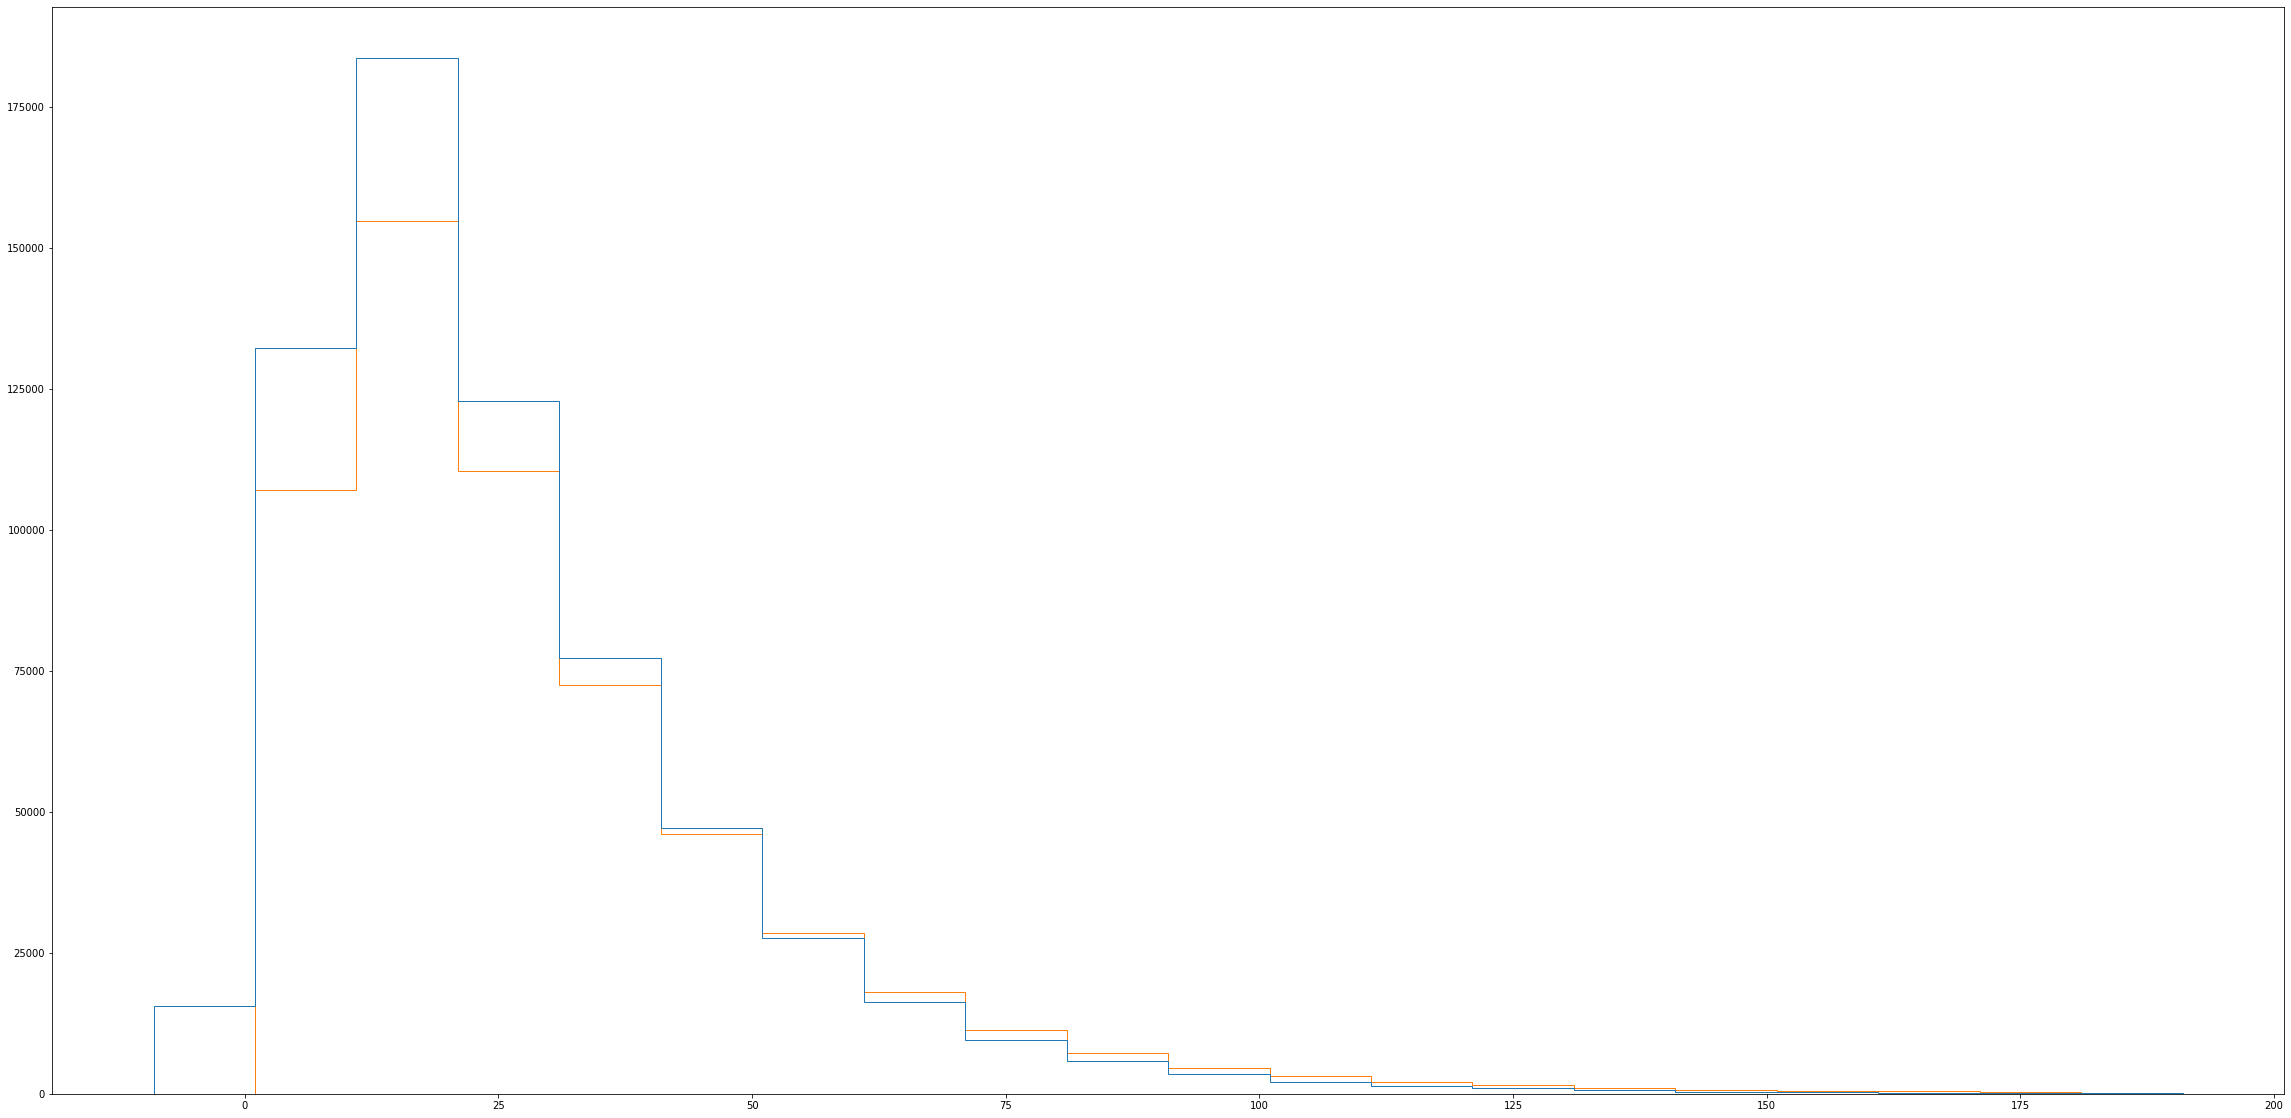

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_es, luzerak_hobea_es], bins=range(-9, 200, 10), histtype='step')

plt.show()

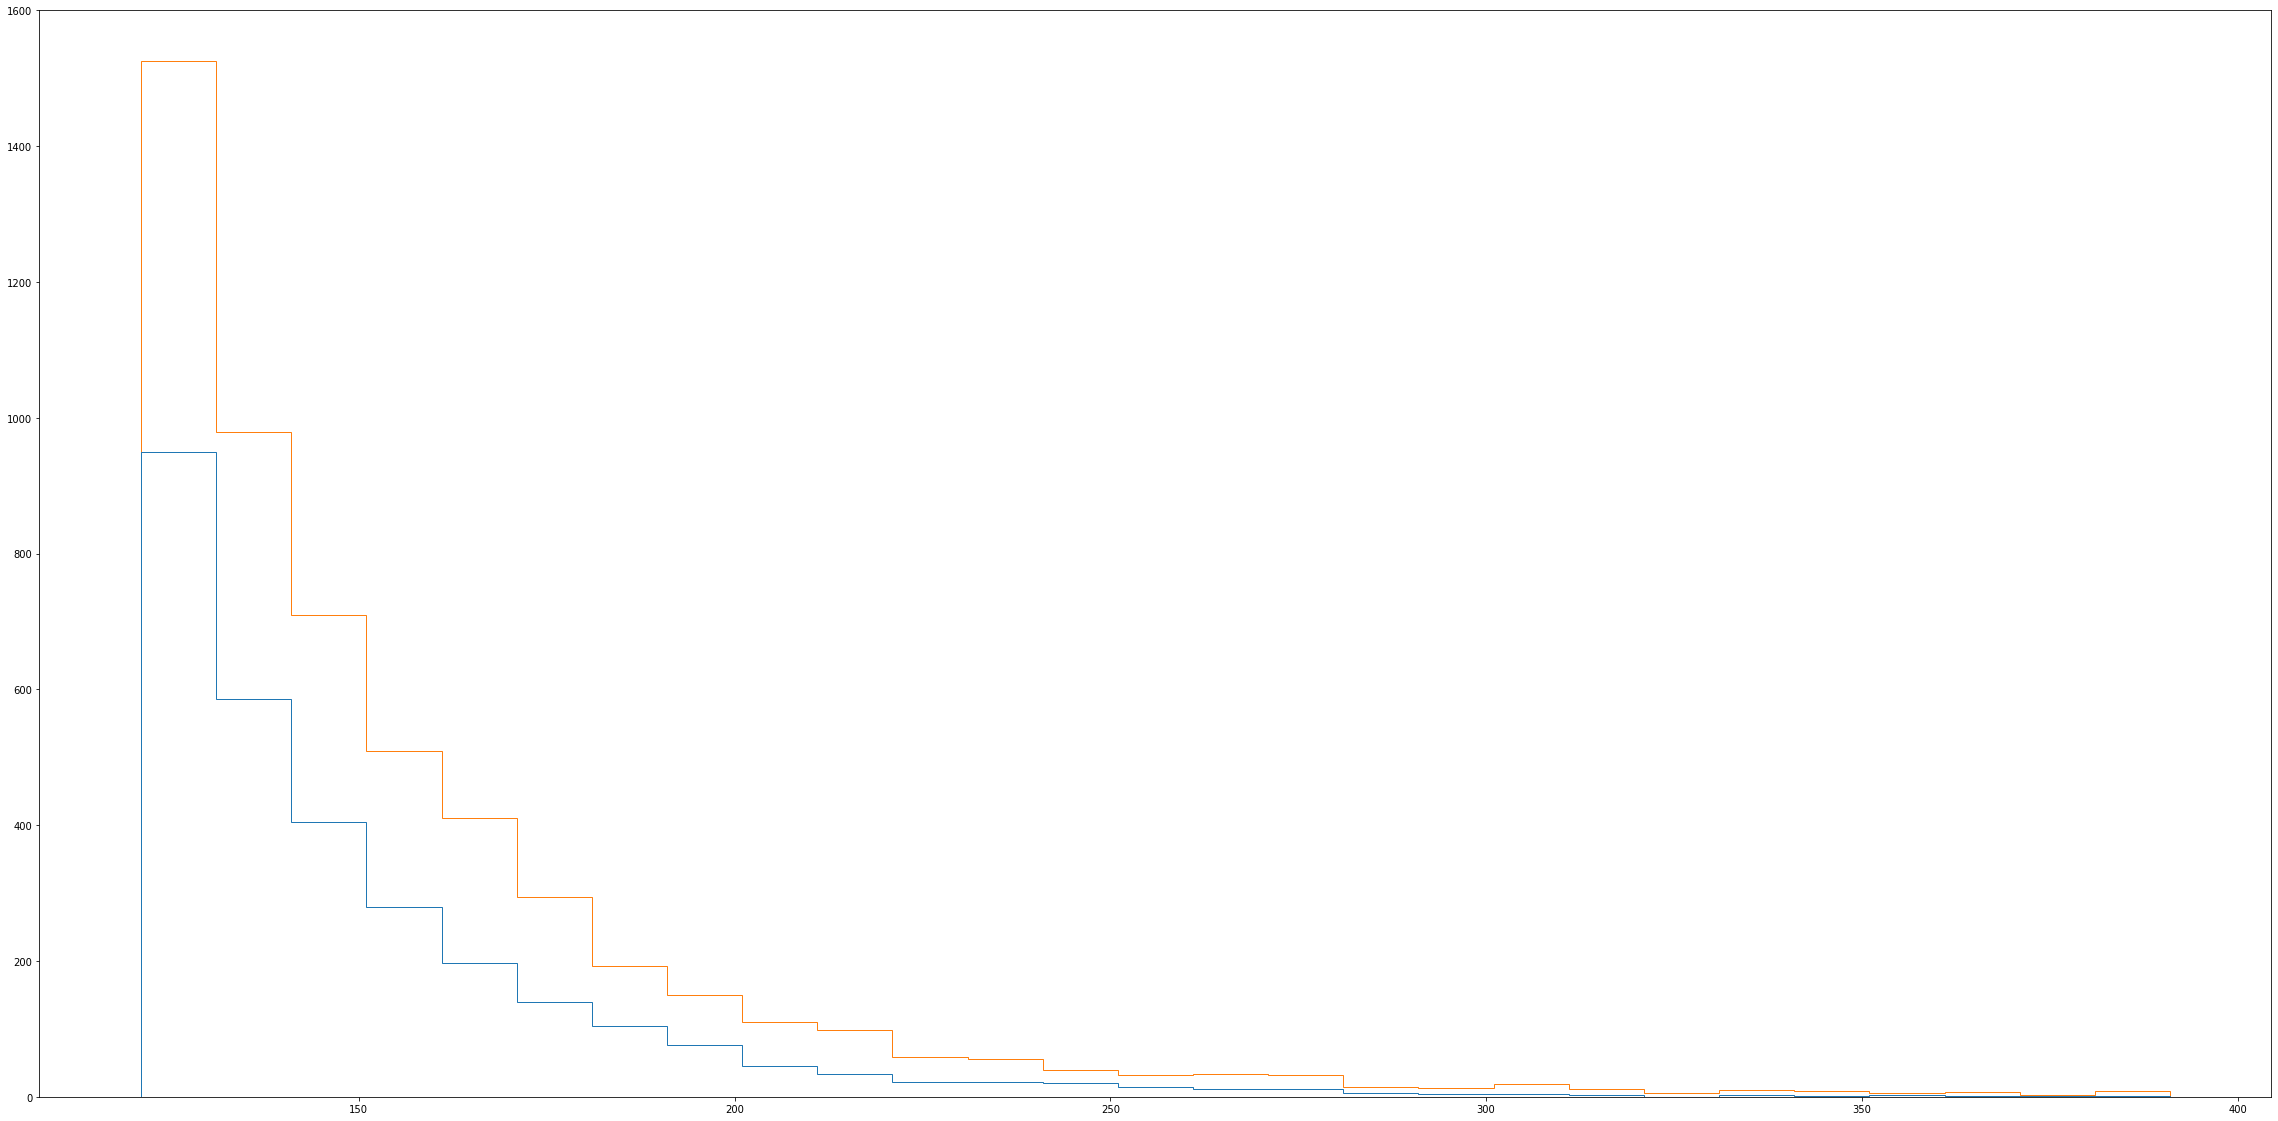

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_es, luzerak_hobea_es], bins=range(121, 400, 10), histtype='step')

plt.show()

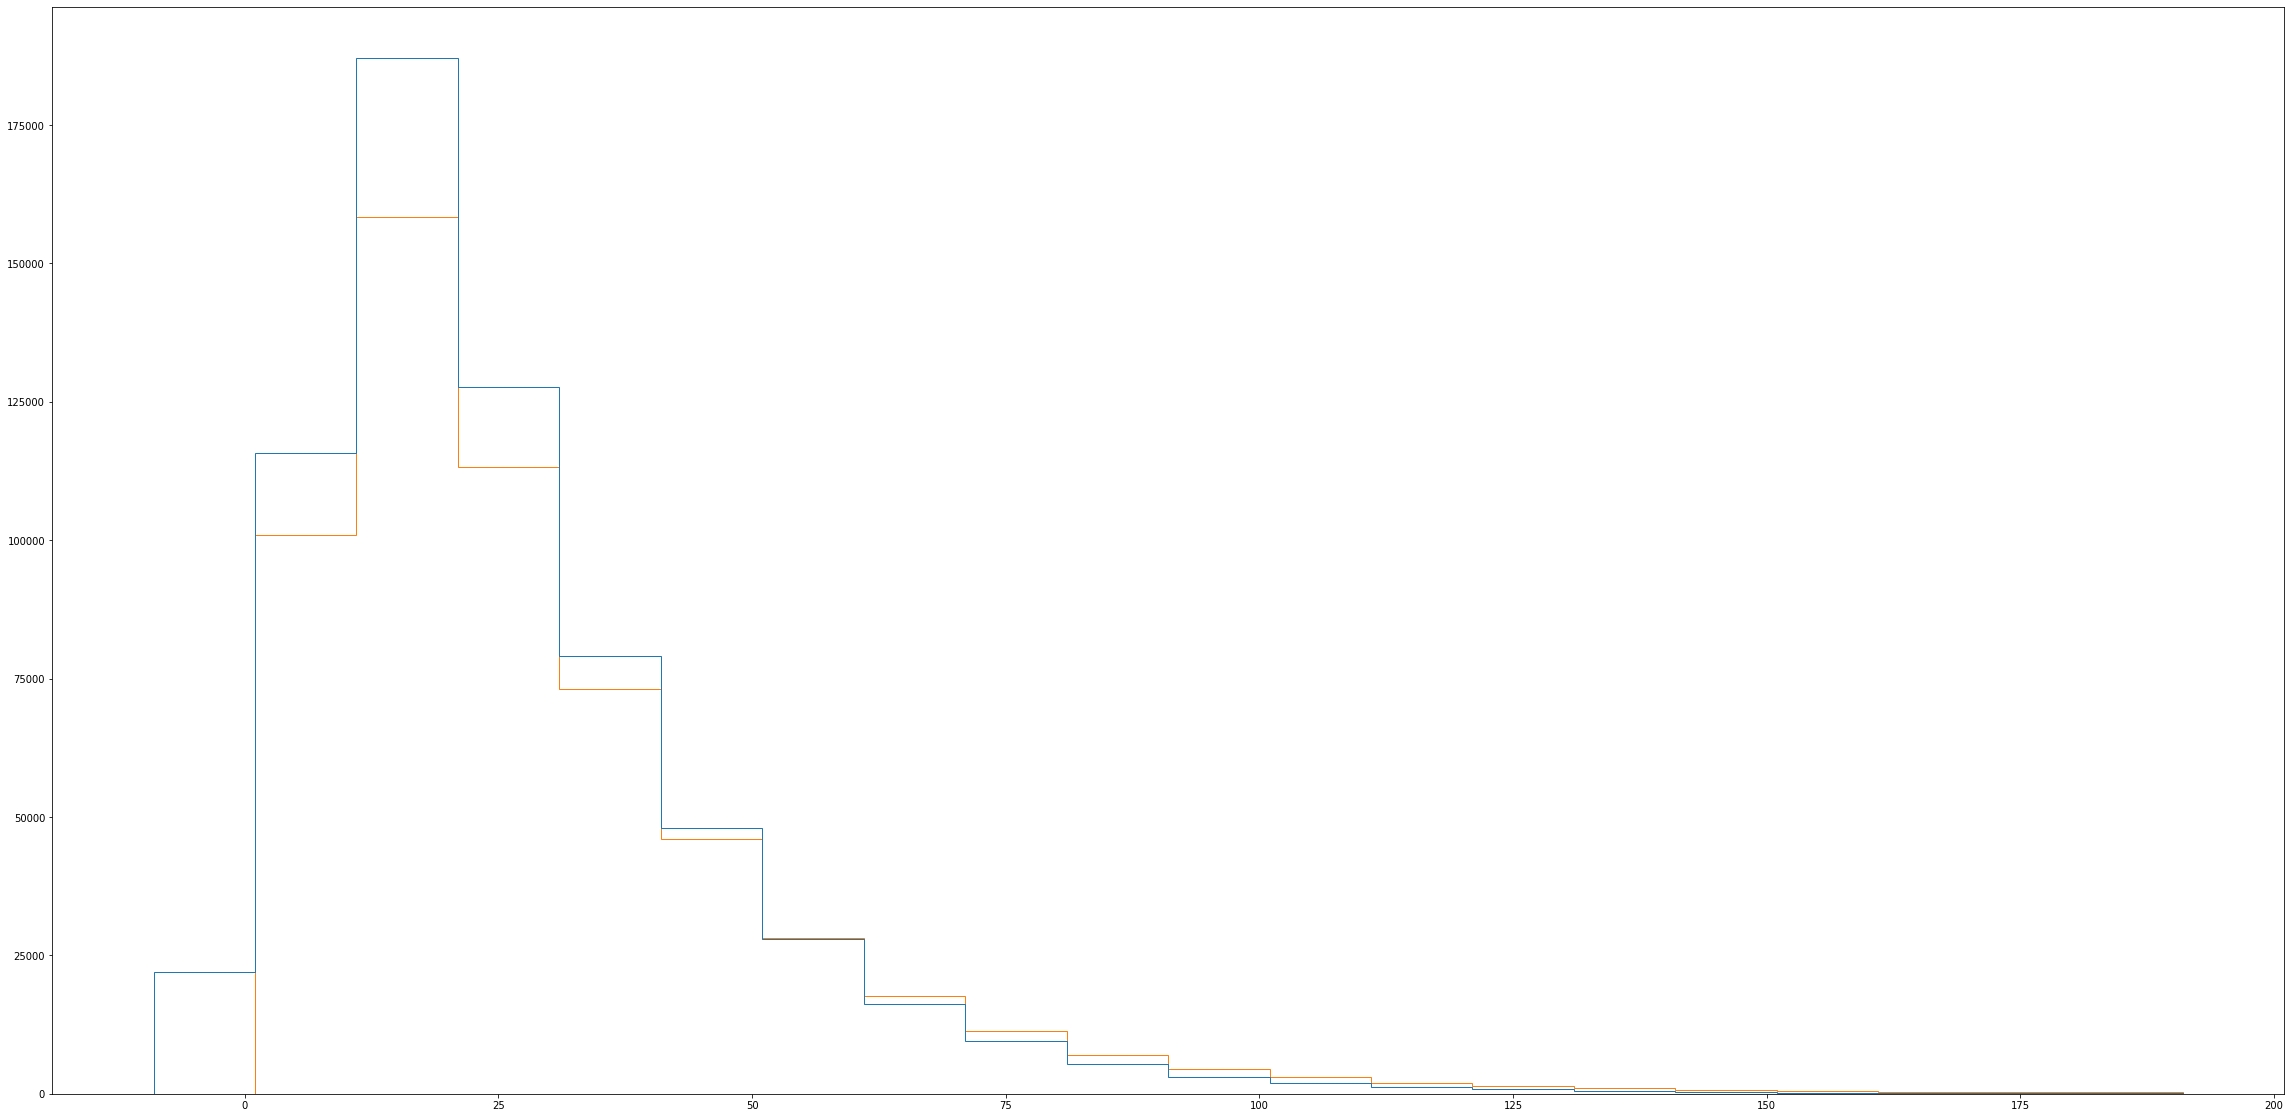

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_en, luzerak_hobea_en], bins=range(-9, 200, 10), histtype='step')
plt.show()

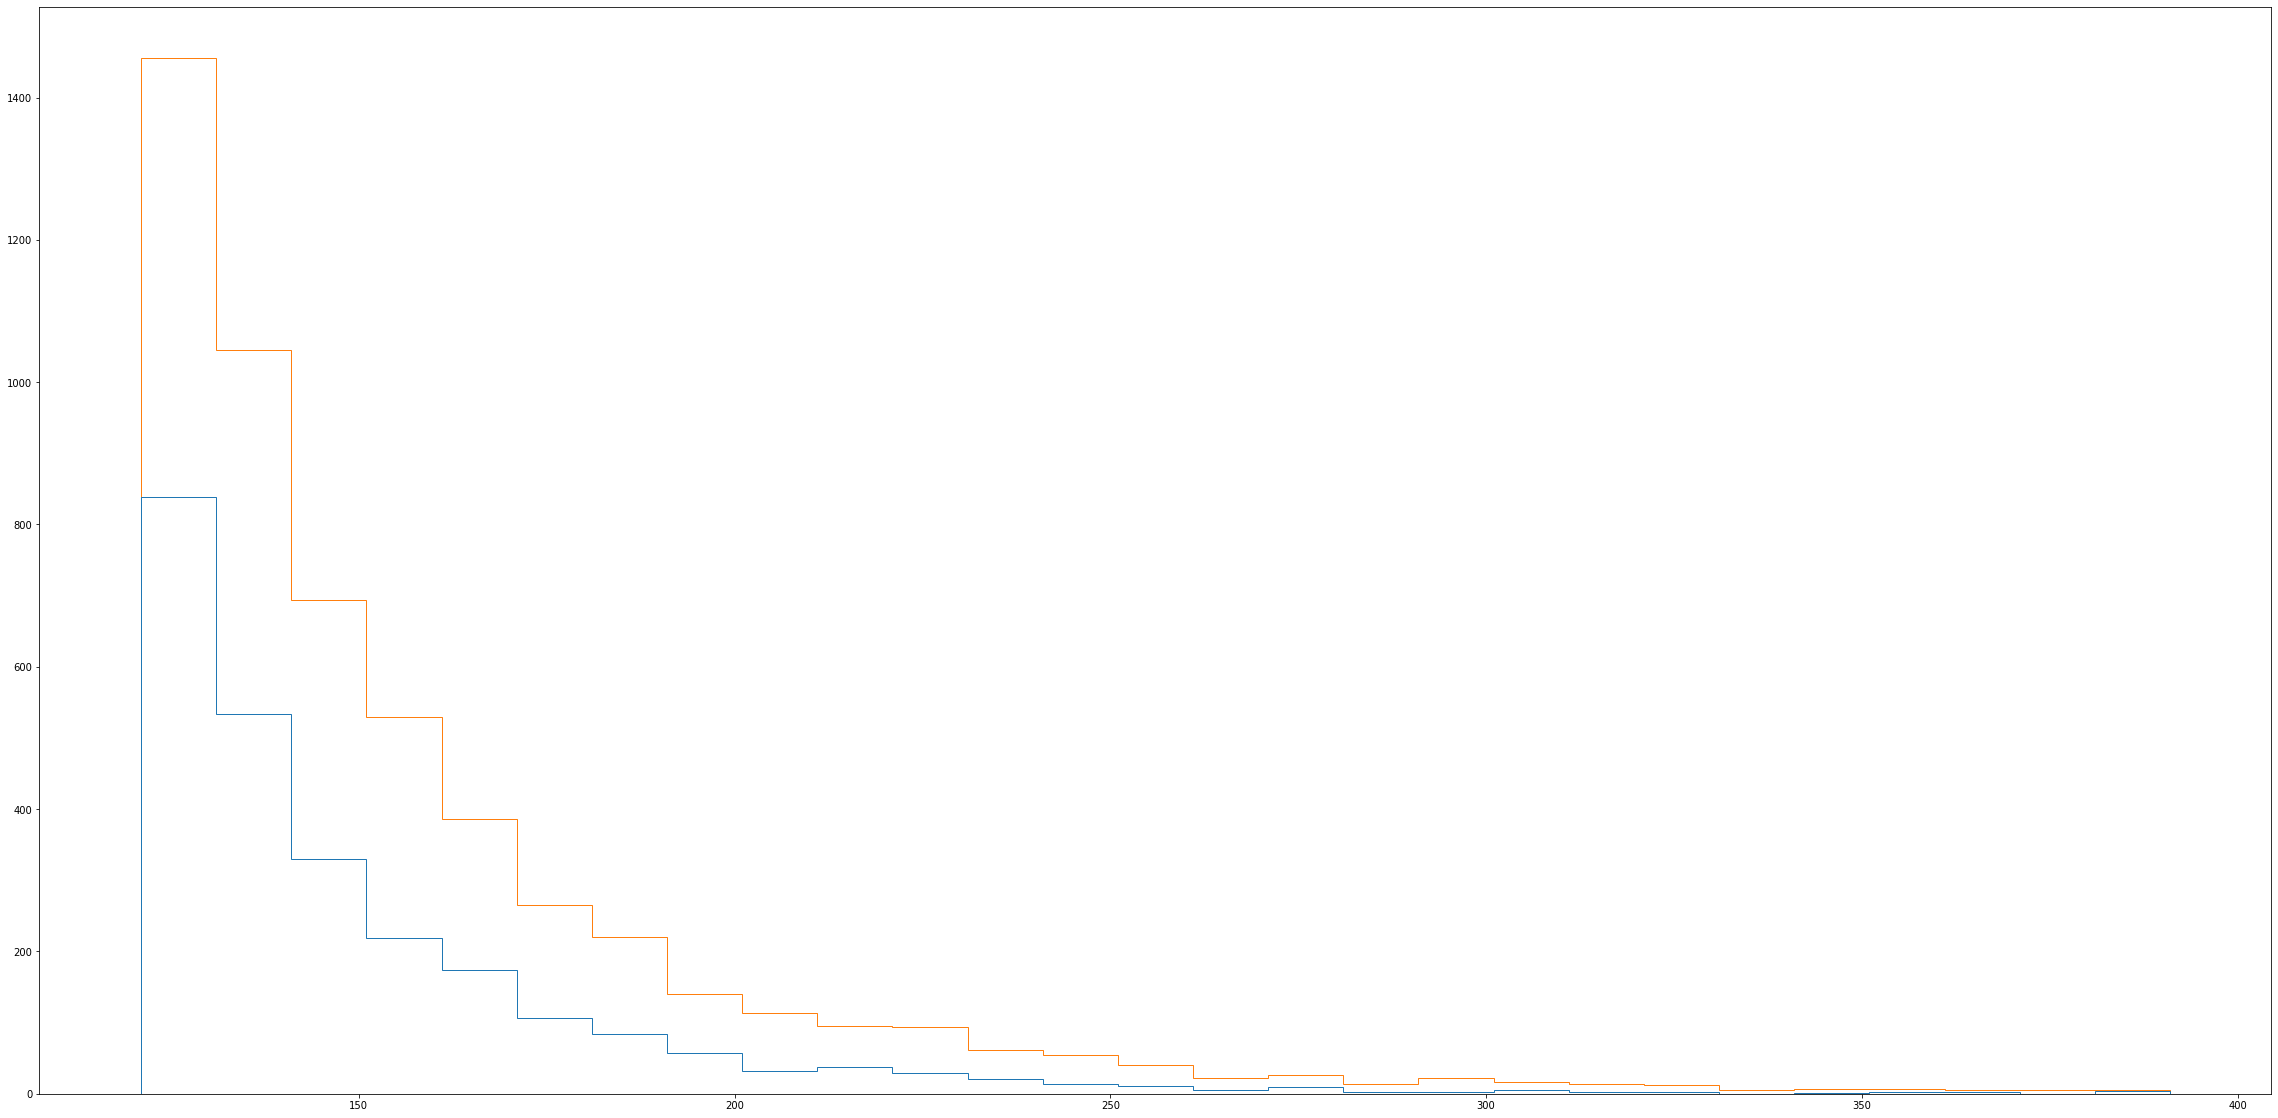

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_en, luzerak_hobea_en], bins=range(121, 400, 10), histtype='step')
plt.show()

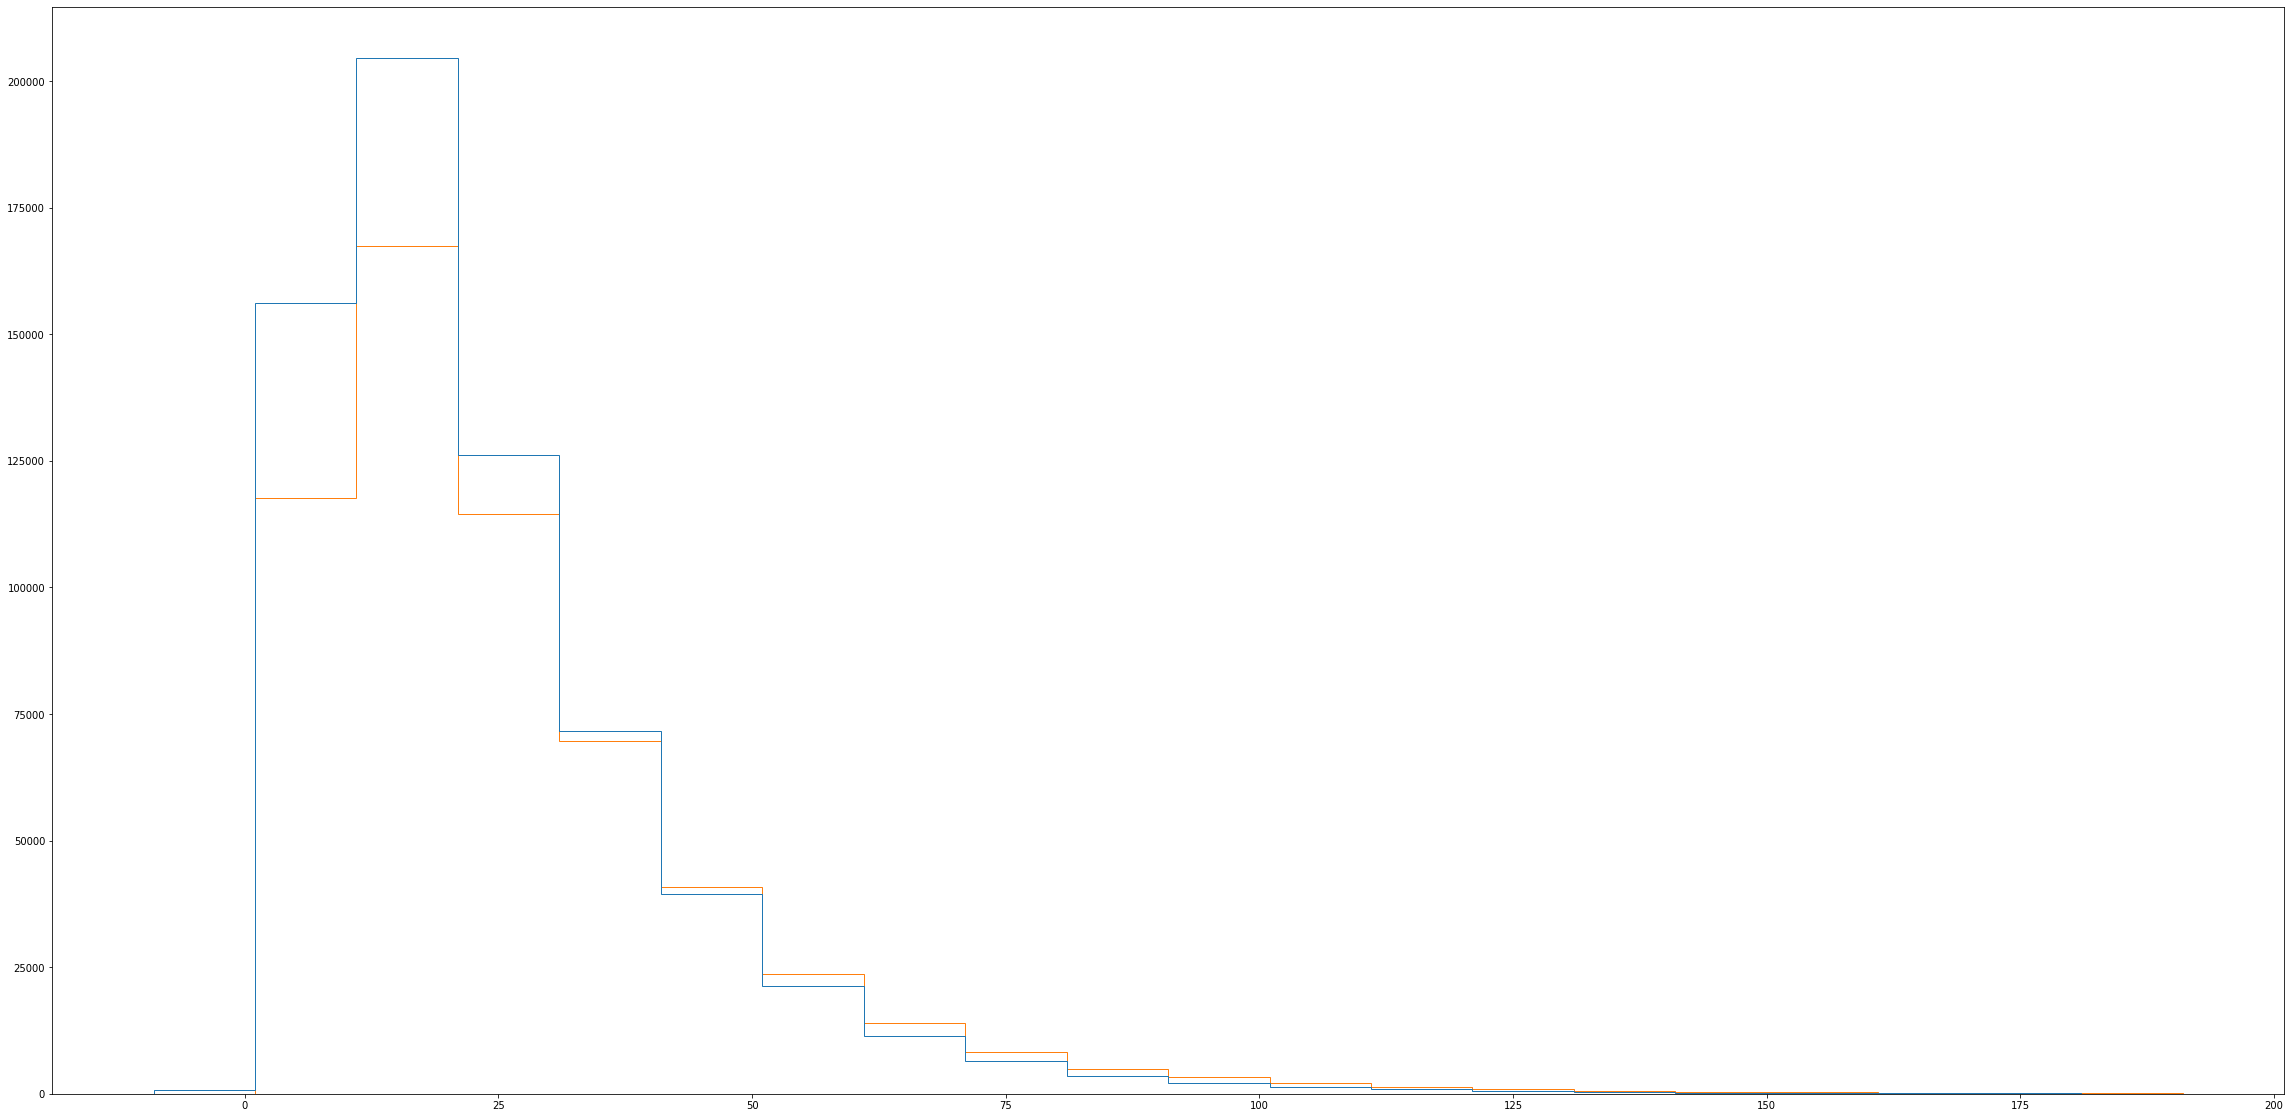

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_eu, luzerak_hobea_eu], bins=range(-9, 200, 10), histtype='step')
plt.show()

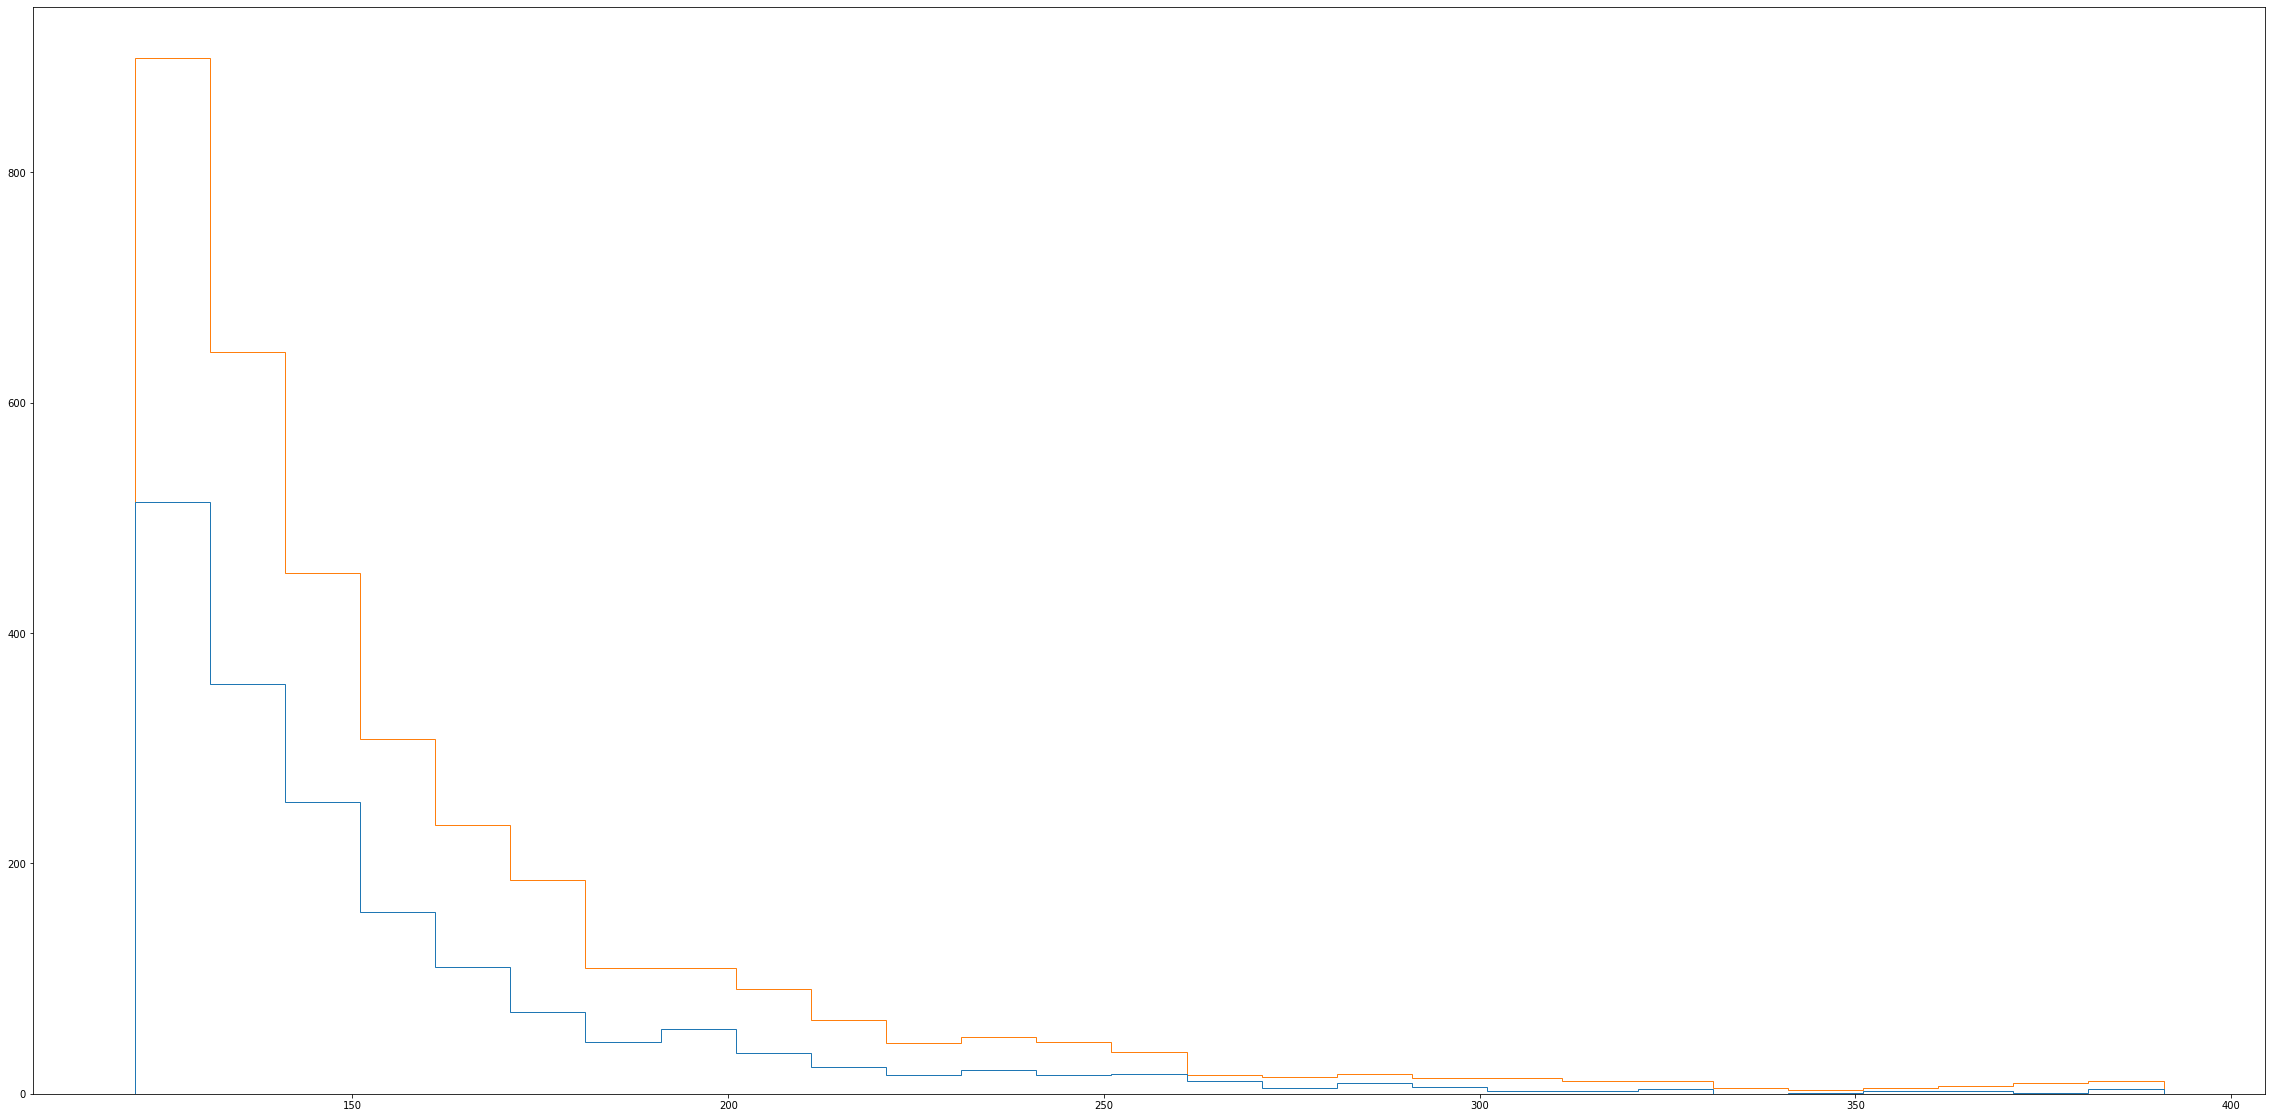

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_eu, luzerak_hobea_eu], bins=range(121, 400, 10), histtype='step')
plt.show()

In [ ]:
labels = ['ES', 'EN', 'EU']

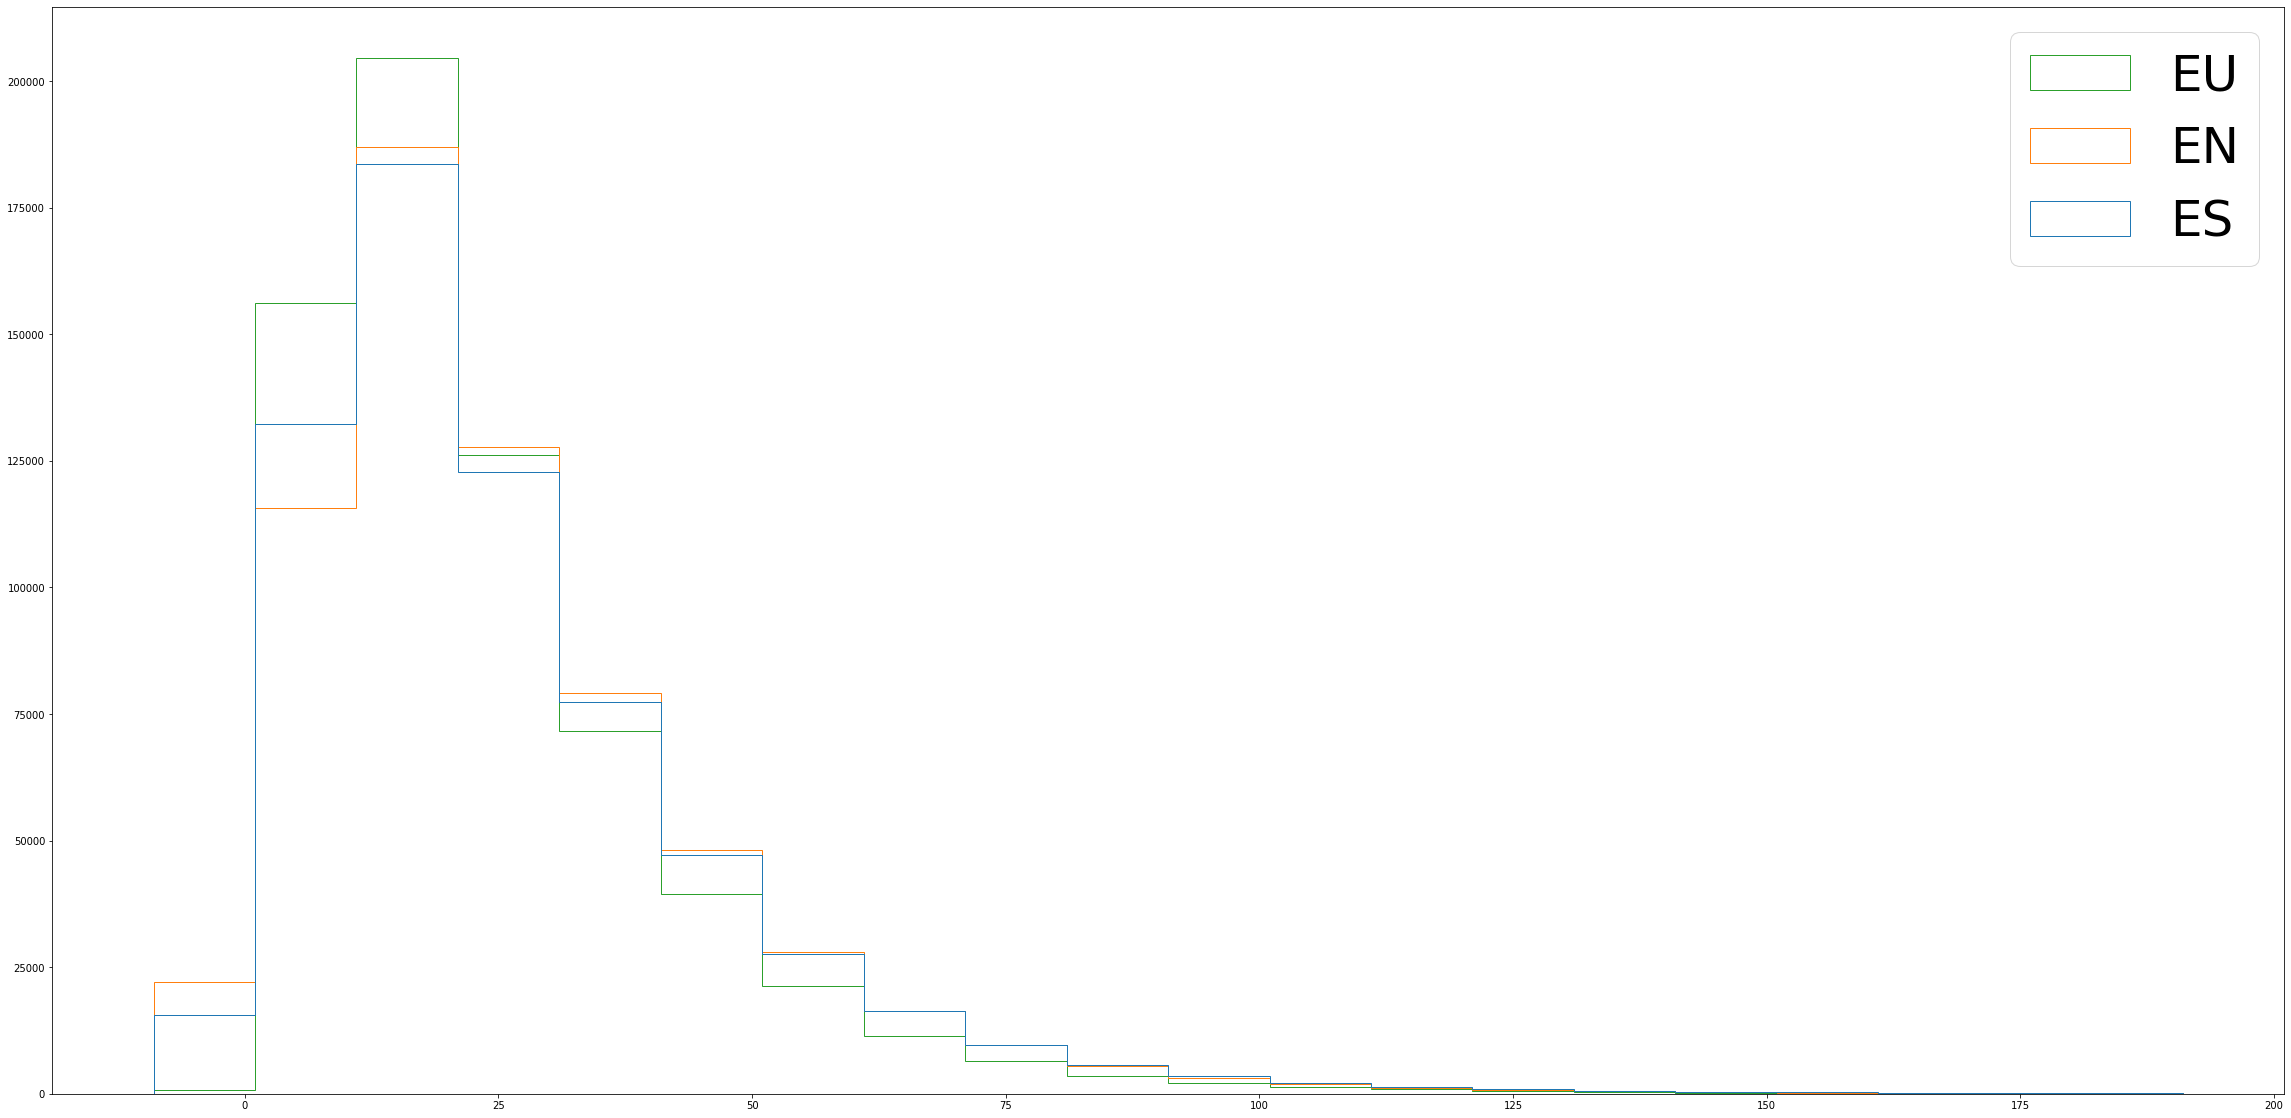

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_es, luzerak_orig_en, luzerak_orig_eu], bins=range(-9, 200, 10), histtype='step', label=labels)
plt.legend(prop={'size': 50})
plt.show()

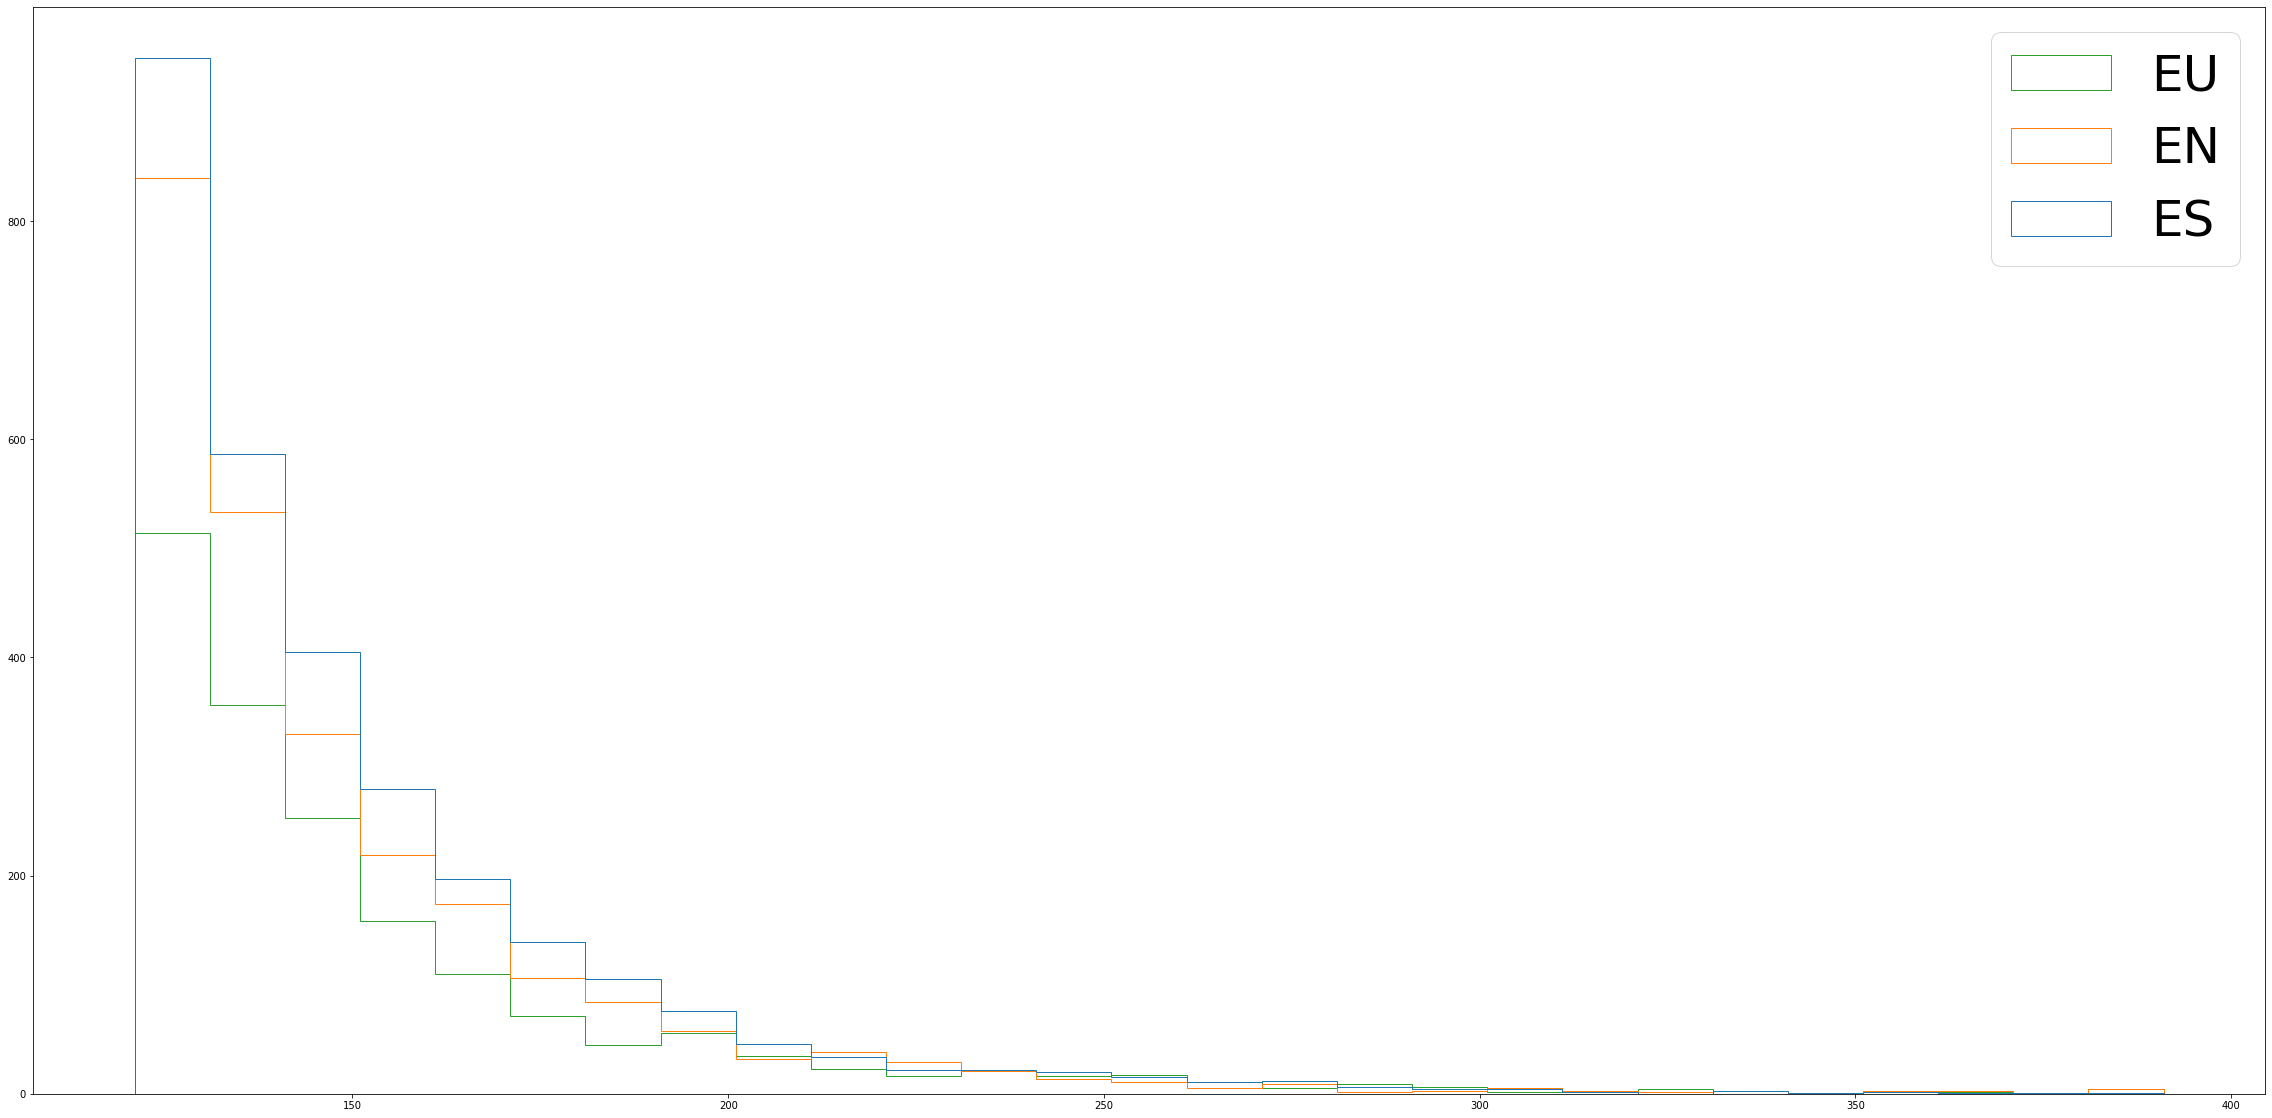

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_orig_es, luzerak_orig_en, luzerak_orig_eu], bins=range(121, 400, 10), histtype='step', label=labels)
plt.legend(prop={'size': 50})
plt.show()

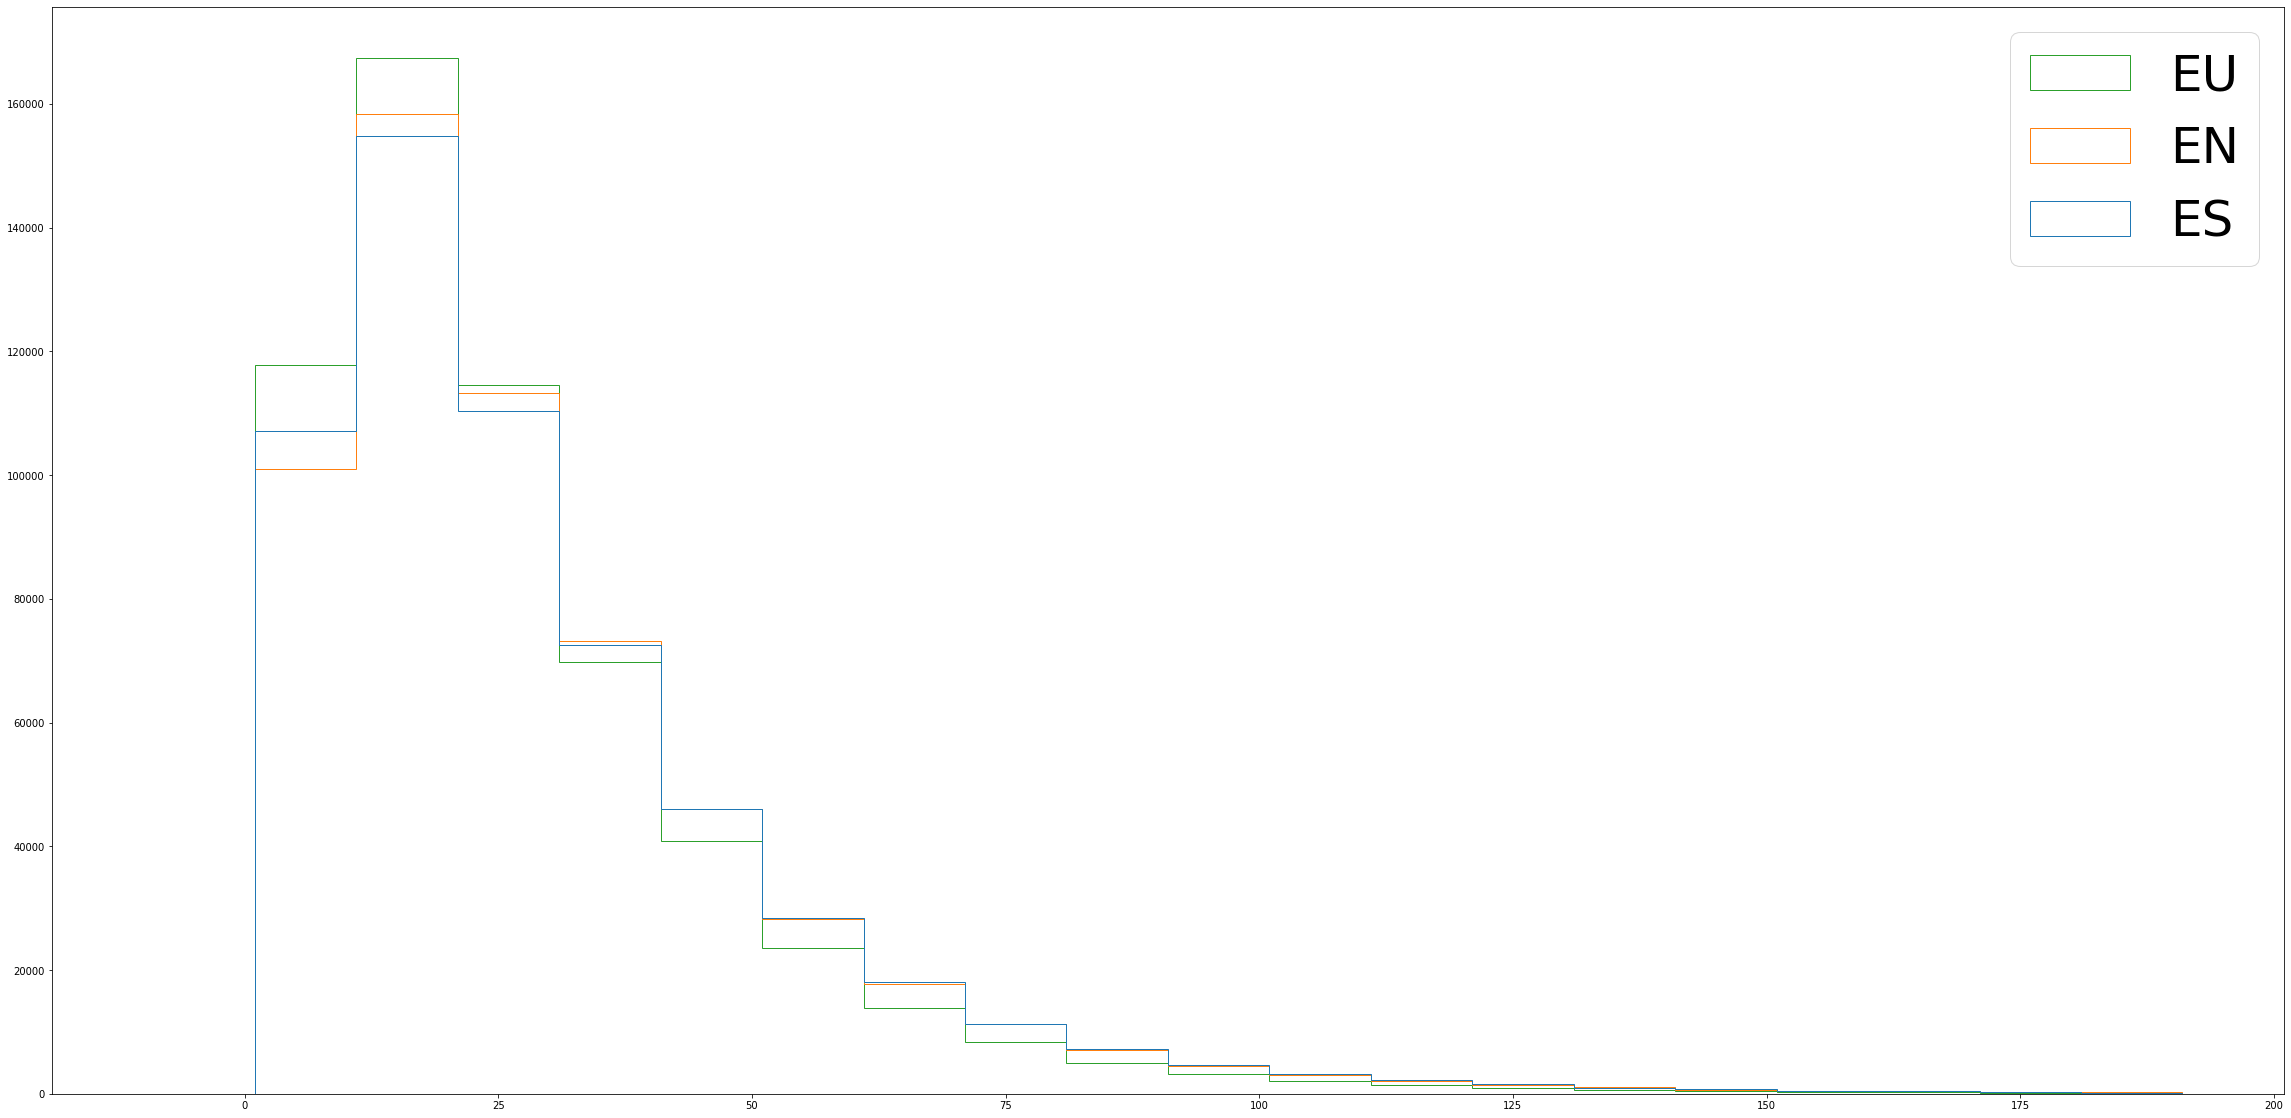

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_hobea_es, luzerak_hobea_en, luzerak_hobea_eu], bins=range(-9, 200, 10), histtype='step', label=labels)
plt.legend(prop={'size': 50})
plt.show()

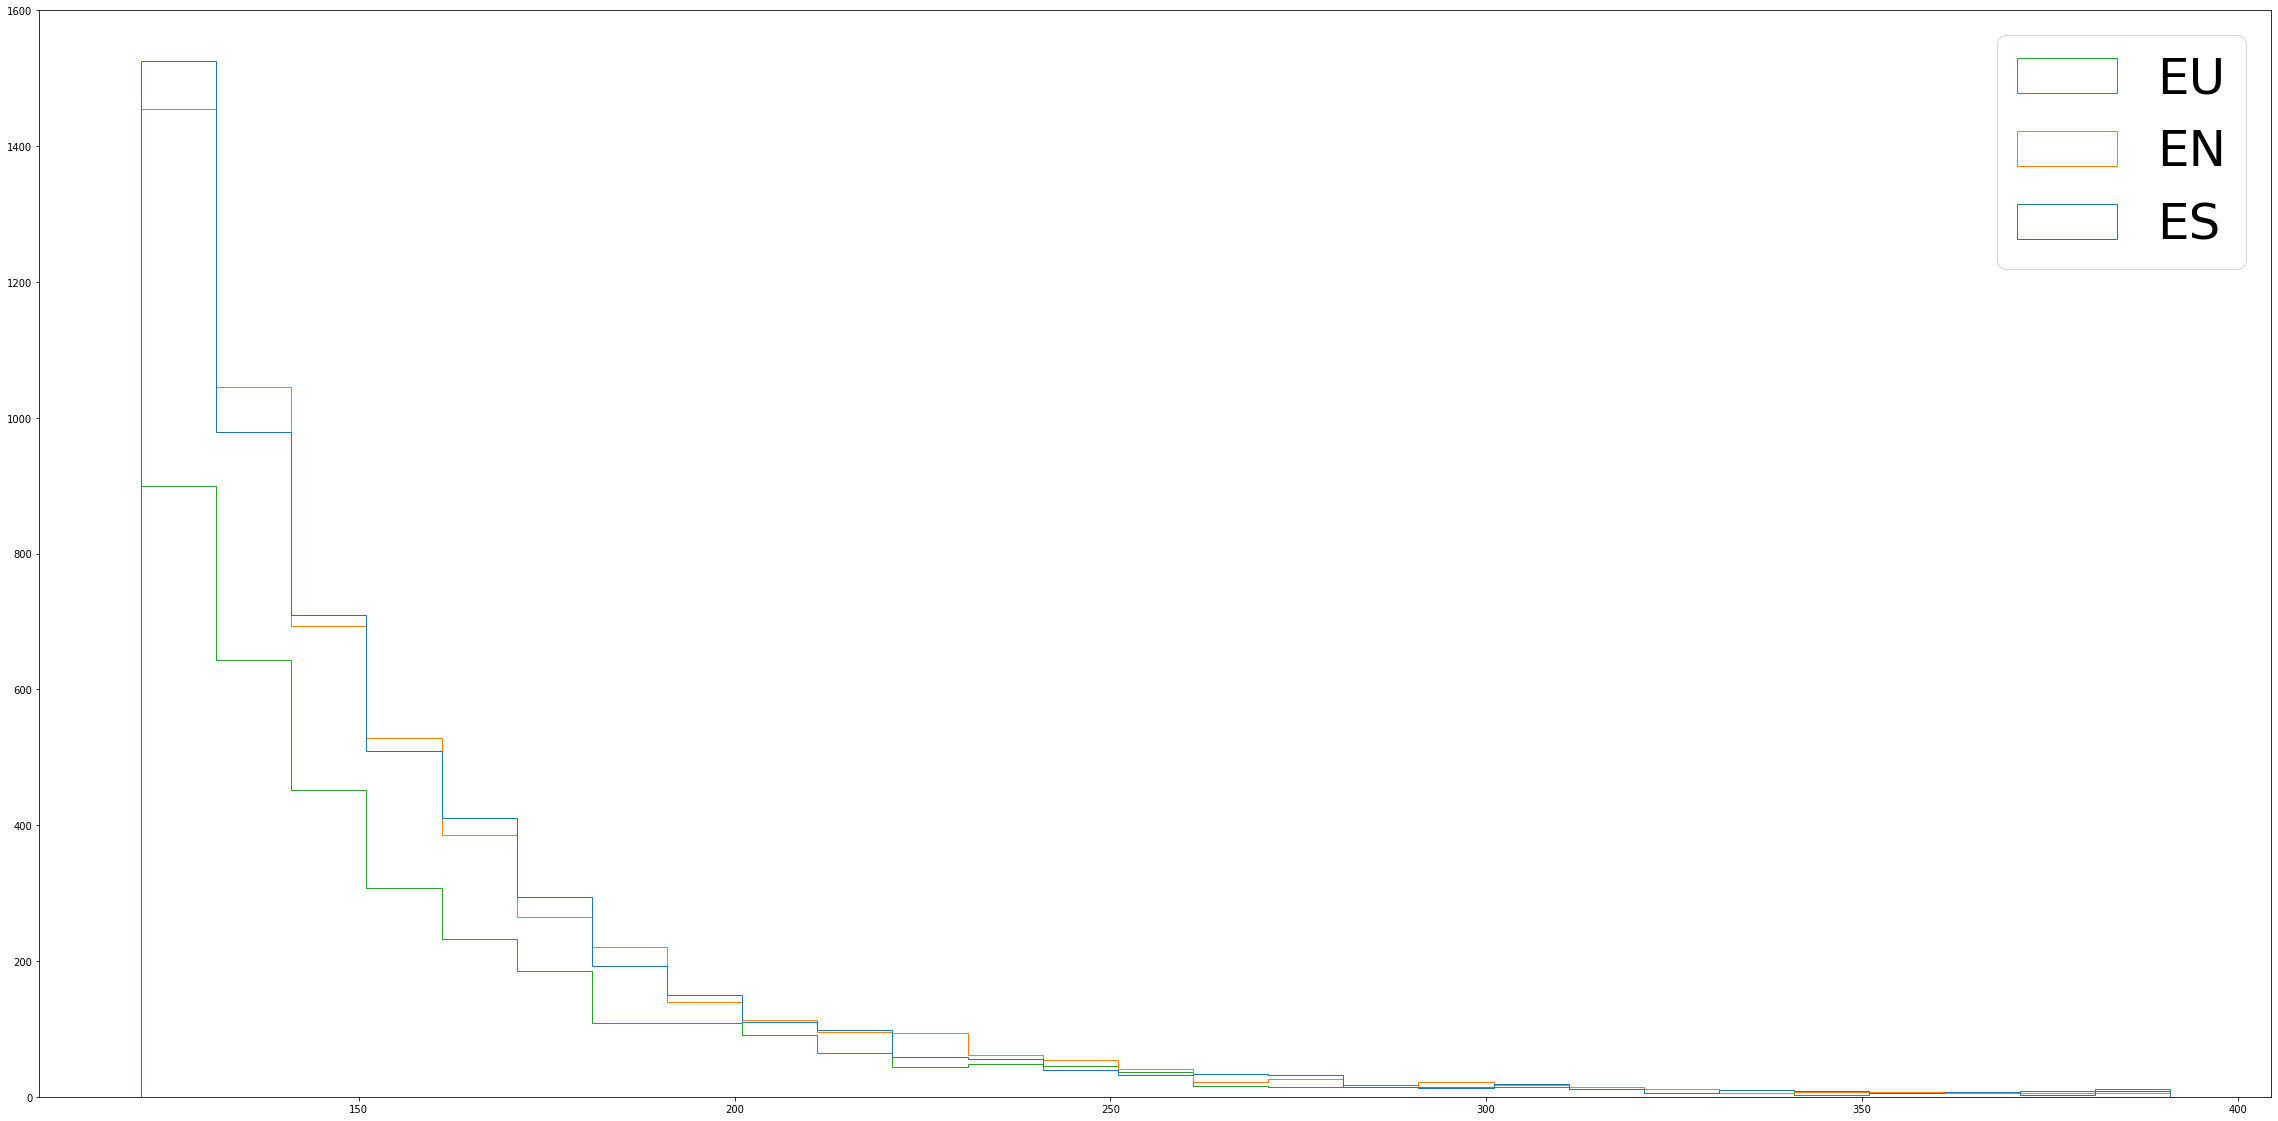

In [ ]:
plt.figure(figsize=(40, 20))
plt.hist([luzerak_hobea_es, luzerak_hobea_en, luzerak_hobea_eu], bins=range(121, 400, 10), histtype='step', label=labels)
plt.legend(prop={'size': 50})
plt.show()